# Project 2: NLP with Neural Networks

## Importing necessary libraries and loading the dataset

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
import re
import string
import time

from typing import Optional, Tuple, List, Dict, Any, Union

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from category_encoders import TargetEncoder

from sentence_transformers import SentenceTransformer

import joblib

import os

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download once
# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')


RANDOM_SEED = 42
FILEPATH = "Train_rev1.csv"
MODELS_DIR = "models/"
PREPROCESSORS_DIR = "preprocessors/"

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)

torch.use_deterministic_algorithms(True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [16]:
def set_seed(seed_value=RANDOM_SEED):
    """Set seeds for reproducibility."""
    random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed(seed_value)
    torch.backends.cudnn.deterministic = True
    
set_seed()

In [17]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(RANDOM_SEED)

In [4]:
df = pd.read_csv(FILEPATH)  

## Exploratory Data Analysis (EDA)

In [5]:
df.head()

,Id,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
0,12612628,Engineering Systems Analyst,Engineering Systems Analyst Dorking Surrey Sal...,"Dorking, Surrey, Surrey",Dorking,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk
1,12612830,Stress Engineer Glasgow,Stress Engineer Glasgow Salary **** to **** We...,"Glasgow, Scotland, Scotland",Glasgow,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 35000/annum 25-35K,30000,cv-library.co.uk
2,12612844,Modelling and simulation analyst,Mathematical Modeller / Simulation Analyst / O...,"Hampshire, South East, South East",Hampshire,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 40000/annum 20-40K,30000,cv-library.co.uk
3,12613049,Engineering Systems Analyst / Mathematical Mod...,Engineering Systems Analyst / Mathematical Mod...,"Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,25000 - 30000/annum 25K-30K negotiable,27500,cv-library.co.uk
4,12613647,"Pioneer, Miser Engineering Systems Analyst","Pioneer, Miser Engineering Systems Analyst Do...","Surrey, South East, South East",Surrey,NaN,permanent,Gregory Martin International,Engineering Jobs,20000 - 30000/annum 20-30K,25000,cv-library.co.uk


In [6]:
df.shape

(244768, 12)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Id                  244768 non-null  int64 
 1   Title               244767 non-null  object
 2   FullDescription     244768 non-null  object
 3   LocationRaw         244768 non-null  object
 4   LocationNormalized  244768 non-null  object
 5   ContractType        65442 non-null   object
 6   ContractTime        180863 non-null  object
 7   Company             212338 non-null  object
 8   Category            244768 non-null  object
 9   SalaryRaw           244768 non-null  object
 10  SalaryNormalized    244768 non-null  int64 
 11  SourceName          244767 non-null  object
dtypes: int64(2), object(10)
memory usage: 22.4+ MB


In [8]:
df.isnull().sum()

Id                         0
Title                      1
FullDescription            0
LocationRaw                0
LocationNormalized         0
ContractType          179326
ContractTime           63905
Company                32430
Category                   0
SalaryRaw                  0
SalaryNormalized           0
SourceName                 1
dtype: int64

In [9]:
df.isnull().sum() / len(df) # Calculate the percentage of missing values for each column

Id                    0.000000
Title                 0.000004
FullDescription       0.000000
LocationRaw           0.000000
LocationNormalized    0.000000
ContractType          0.732637
ContractTime          0.261084
Company               0.132493
Category              0.000000
SalaryRaw             0.000000
SalaryNormalized      0.000000
SourceName            0.000004
dtype: float64

In [10]:
# Id column is not useful for prediction, so we will drop it
df = df.drop(columns=['Id'])

In [11]:
# Checking for duplicates
df.duplicated().sum()

np.int64(0)

In [12]:
df.nunique()

Title                 135435
FullDescription       242138
LocationRaw            20986
LocationNormalized      2732
ContractType               2
ContractTime               2
Company                20812
Category                  29
SalaryRaw              97286
SalaryNormalized        8454
SourceName               167
dtype: int64

### Univariate Analysis

#### Inspecting the 'Title' column

In [13]:
df['Title'].value_counts()

Title
Business Development Manager                                       921
Project Manager                                                    749
Management Accountant                                              661
Sales Executive                                                    603
Account Manager                                                    540
                                                                  ... 
Senior Build & Release Engineer (Java eCommerce Deployments)         1
Job Family Recruiter                                                 1
Leasehold Officer  Housing Services [Standard DBS/CRB required]      1
Sales/Retail Consultant                                              1
TEACHER OF ENGLISH                                                   1
Name: count, Length: 135435, dtype: int64

In [14]:
df[df['Title'].isna()]

,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
1588,NaN,Quality Improvement Manager North West England...,"Liverpool, Merseyside",Liverpool,full_time,NaN,NaN,Healthcare & Nursing Jobs,"40,000 to 45,000 per year",42500,careworx.co.uk


We can fill it manually.

In [15]:
df.loc[df['Title'].isnull(), 'Title'] = 'Quality Improvement Manager'

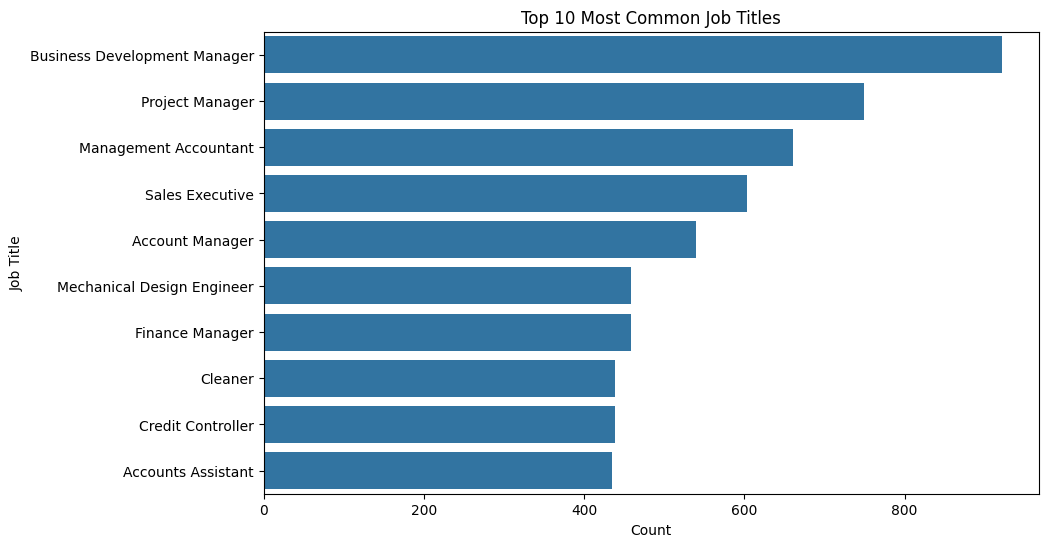

In [16]:
# Plot 10 most common titles
plt.figure(figsize=(10,6))
sns.countplot(y='Title', data=df, order=df['Title'].value_counts().index[:10])
plt.title('Top 10 Most Common Job Titles')
plt.xlabel('Count')
plt.ylabel('Job Title')
plt.show()

#### Inspecting the 'FullDescription' column

From the description on Kaggle, we now that *** hide salary information in description.

In [17]:
df['FullDescription'].head()

0    Engineering Systems Analyst Dorking Surrey Sal...
1    Stress Engineer Glasgow Salary **** to **** We...
2    Mathematical Modeller / Simulation Analyst / O...
3    Engineering Systems Analyst / Mathematical Mod...
4    Pioneer, Miser  Engineering Systems Analyst Do...
Name: FullDescription, dtype: object

Check for some common words in IT job descriptions:

In [18]:
words = ['python', 'java', 'c++', 'sql', 'html', 'css', 'tensorflow', 'pytorch']
for word in words:
    print(f"Number of job descriptions containing '{word}': {df['FullDescription'].str.contains(word, case=False).sum()}")

Number of job descriptions containing 'python': 1332
Number of job descriptions containing 'java': 10498
Number of job descriptions containing 'c++': 244750
Number of job descriptions containing 'sql': 16186
Number of job descriptions containing 'html': 7895
Number of job descriptions containing 'css': 6534
Number of job descriptions containing 'tensorflow': 0
Number of job descriptions containing 'pytorch': 0


#### Inspecting the 'LocationRaw' column

In [19]:
df['LocationRaw'].head(10)

0              Dorking, Surrey, Surrey
1          Glasgow, Scotland, Scotland
2    Hampshire, South East, South East
3       Surrey, South East, South East
4       Surrey, South East, South East
5      Dorking, Surrey, Surrey, Surrey
6                    Aberdeen, Borders
7       MANCHESTER, Greater Manchester
8                LEEDS, West Yorkshire
9                         Aberdeen, UK
Name: LocationRaw, dtype: object

In [20]:
df['LocationRaw'].value_counts()

LocationRaw
London                     15605
London South East           8689
UK                          5538
City London South East      2843
City of London - London     2344
                           ...  
TEDDINGTON, MIDDLESEX          1
SEVENOAKS, KENT                1
ELY, CAMBRIDGESHIRE            1
MORECAMBE, LANCASHIRE          1
Hampshire-wide                 1
Name: count, Length: 20986, dtype: int64

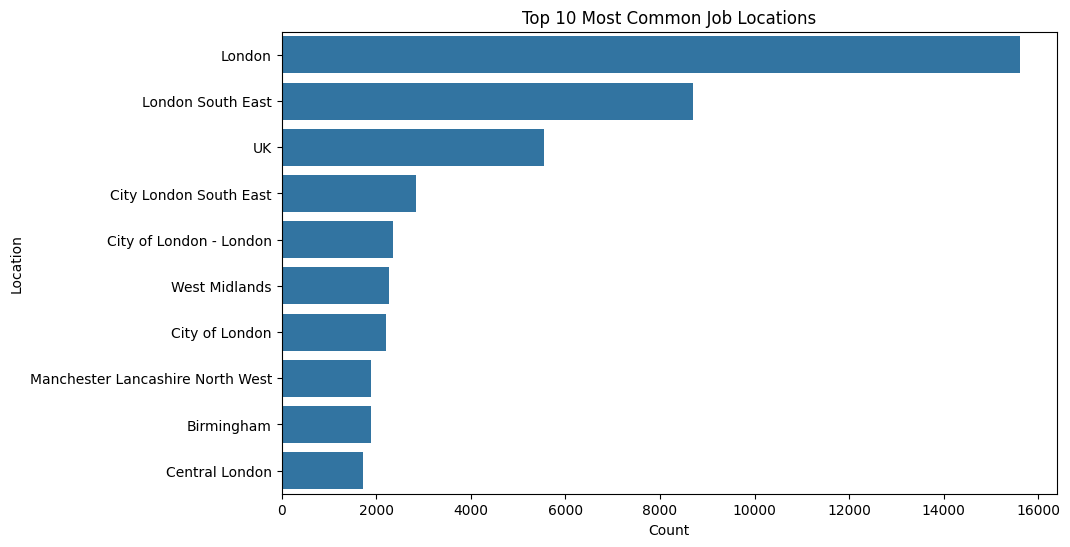

In [21]:
plt.figure(figsize=(10,6))
sns.countplot(y='LocationRaw', data=df, order=df['LocationRaw'].value_counts().index[:10])
plt.title('Top 10 Most Common Job Locations')
plt.xlabel('Count')
plt.ylabel('Location')
plt.show()

#### Inspecting the 'LocationNormalized' column

In [22]:
df['LocationNormalized'].head(10)

0       Dorking
1       Glasgow
2     Hampshire
3        Surrey
4        Surrey
5       Dorking
6            UK
7    Manchester
8         Leeds
9      Aberdeen
Name: LocationNormalized, dtype: object

In [23]:
df['LocationNormalized'].value_counts()

LocationNormalized
UK                    41093
London                30522
South East London     11713
The City               6678
Manchester             3516
                      ...  
Oldbrook                  1
Berrycroft                1
Pinchbeck                 1
Peasedown St. John        1
Temple                    1
Name: count, Length: 2732, dtype: int64

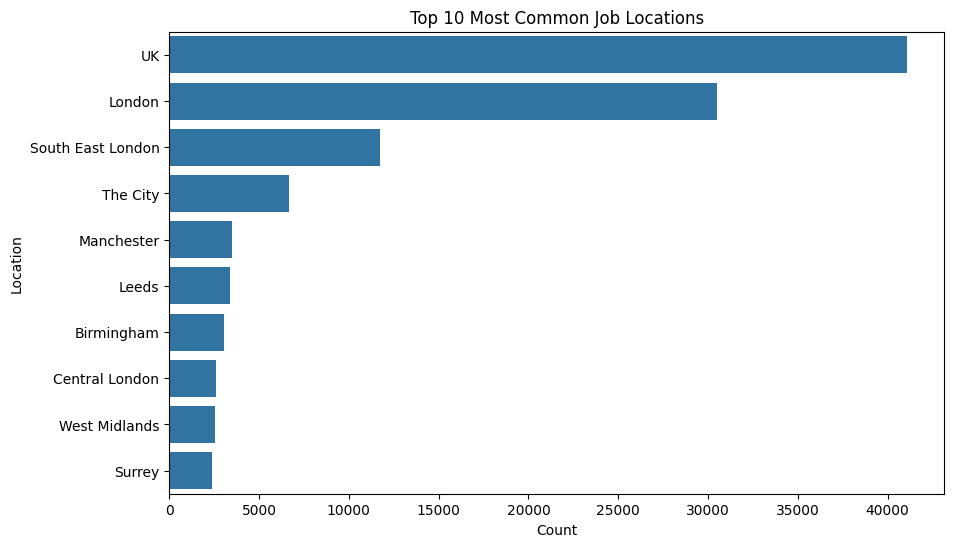

In [24]:
plt.figure(figsize=(10,6))
sns.countplot(y='LocationNormalized', data=df, order=df['LocationNormalized'].value_counts().index[:10])
plt.title('Top 10 Most Common Job Locations')
plt.xlabel('Count')
plt.ylabel('Location')
plt.show()

#### Inspecting the 'ContractType' column

In [25]:
df['ContractType'].head(10)

0    NaN
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
6    NaN
7    NaN
8    NaN
9    NaN
Name: ContractType, dtype: object

In [26]:
df['ContractType'].isnull().sum() / len(df) 

np.float64(0.7326366191659041)

In [27]:
df['ContractType'].value_counts()

ContractType
full_time    57538
part_time     7904
Name: count, dtype: int64

#### Inspecting the 'ContractTime' column

In [28]:
df['ContractTime'].head(10)

0    permanent
1    permanent
2    permanent
3    permanent
4    permanent
5    permanent
6    permanent
7    permanent
8    permanent
9    permanent
Name: ContractTime, dtype: object

In [29]:
df['ContractTime'].isnull().sum() / len(df)

np.float64(0.2610839652242123)

In [30]:
df['ContractTime'].value_counts()

ContractTime
permanent    151521
contract      29342
Name: count, dtype: int64

#### Inspecting the 'Company' column

In [31]:
df['Company'].head(10)

0    Gregory Martin International
1    Gregory Martin International
2    Gregory Martin International
3    Gregory Martin International
4    Gregory Martin International
5    Gregory Martin International
6                   Indigo 21 Ltd
7           Code Blue Recruitment
8           Code Blue Recruitment
9                   Indigo 21 Ltd
Name: Company, dtype: object

In [32]:
df['Company'].isnull().sum() / len(df)

np.float64(0.132492809517584)

In [33]:
df['Company'].value_counts()

Company
UKStaffsearch          4997
CVbrowser              2977
London4Jobs            2345
Hays                   1784
JAM Recruitment Ltd    1122
                       ... 
Your Golf Travel          1
YMCAfit                   1
The Park Club             1
Celtic Manor Resort       1
DMC Healthcare            1
Name: count, Length: 20812, dtype: int64

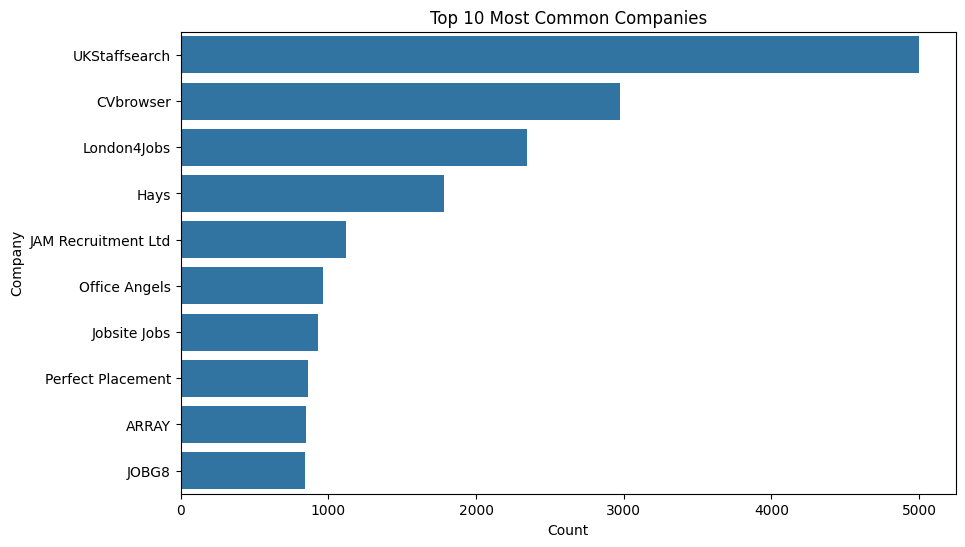

In [34]:
plt.figure(figsize=(10,6))
sns.countplot(y='Company', data=df, order=df['Company'].value_counts().index[:10])
plt.title('Top 10 Most Common Companies')
plt.xlabel('Count')
plt.ylabel('Company')
plt.show()

#### Inspecting the 'Category' column

In [35]:
df['Category'].head(10)

0         Engineering Jobs
1         Engineering Jobs
2         Engineering Jobs
3         Engineering Jobs
4         Engineering Jobs
5         Engineering Jobs
6         Engineering Jobs
7    HR & Recruitment Jobs
8    HR & Recruitment Jobs
9         Engineering Jobs
Name: Category, dtype: object

In [36]:
df['Category'].value_counts()

Category
IT Jobs                             38483
Engineering Jobs                    25174
Accounting & Finance Jobs           21846
Healthcare & Nursing Jobs           21076
Sales Jobs                          17272
Other/General Jobs                  17055
Teaching Jobs                       12637
Hospitality & Catering Jobs         11351
PR, Advertising & Marketing Jobs     8854
Trade & Construction Jobs            8837
HR & Recruitment Jobs                7713
Admin Jobs                           7614
Retail Jobs                          6584
Customer Services Jobs               6063
Legal Jobs                           3939
Manufacturing Jobs                   3765
Logistics & Warehouse Jobs           3633
Social work Jobs                     3455
Consultancy Jobs                     3263
Travel Jobs                          3126
Scientific & QA Jobs                 2489
Charity & Voluntary Jobs             2332
Energy, Oil & Gas Jobs               2255
Creative & Design Jobs   

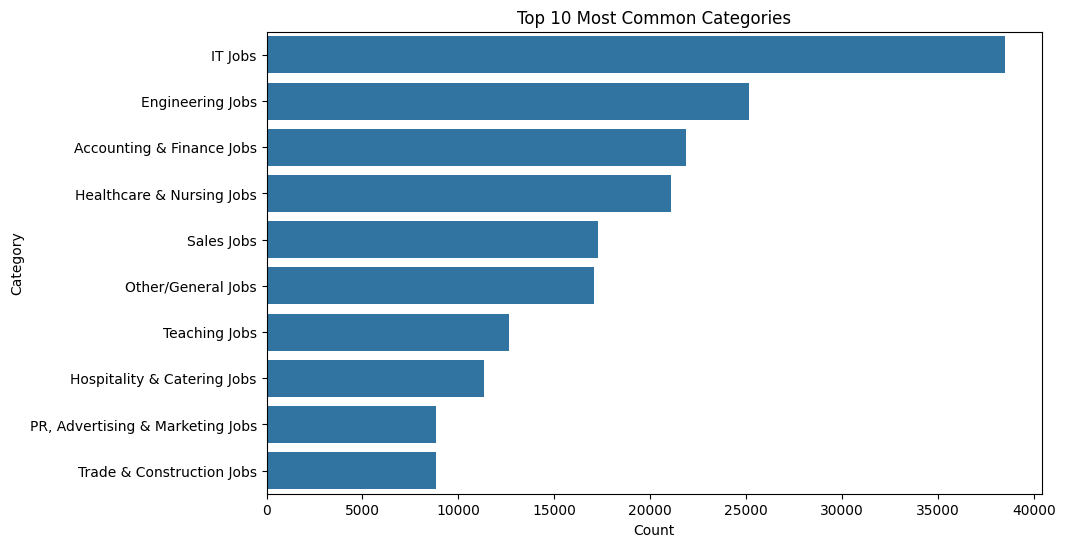

In [37]:
plt.figure(figsize=(10,6))
sns.countplot(y='Category', data=df, order=df['Category'].value_counts().index[:10])
plt.title('Top 10 Most Common Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()

#### Inspecting the 'SalaryRow' column

In [38]:
df['SalaryRaw'].head(10)

0                          20000 - 30000/annum 20-30K
1                          25000 - 35000/annum 25-35K
2                          20000 - 40000/annum 20-40K
3              25000 - 30000/annum 25K-30K negotiable
4                          20000 - 30000/annum 20-30K
5                      20000 - 30000/annum 20K to 30K
6                                50000 - 100000/annum
7      18000 - 26000/annum TO 26K BASIC + COMM + BENS
8    18000 - 28000/annum 18 - 28K BASIC + COMM + BENS
9                                70000 - 100000/annum
Name: SalaryRaw, dtype: object

In [39]:
df['SalaryRaw'].value_counts()

SalaryRaw
50,000-74,999 yearly                                   1923
35000                                                   868
40000                                                   834
45000                                                   764
30k - 40k                                               742
                                                       ... 
28,000.00 - 40,000.00 per year Company Car, Pension       1
21294, circa                                              1
36000 - 40000, Company Benfits                            1
7.64 - 8 p/h                                              1
30000 - 34000 per annum + Vehicle                         1
Name: count, Length: 97286, dtype: int64

#### Inspecting the 'SalaryNormalized' column

In [40]:
df['SalaryNormalized'].head(10)

0    25000
1    30000
2    30000
3    27500
4    25000
5    25000
6    75000
7    22000
8    23000
9    85000
Name: SalaryNormalized, dtype: int64

In [41]:
df['SalaryNormalized'].describe()

count    244768.000000
mean      34122.577576
std       17640.543124
min        5000.000000
25%       21500.000000
50%       30000.000000
75%       42500.000000
max      200000.000000
Name: SalaryNormalized, dtype: float64

In [42]:
df[['SalaryRaw','SalaryNormalized']].head(10)

,SalaryRaw,SalaryNormalized
0,20000 - 30000/annum 20-30K,25000
1,25000 - 35000/annum 25-35K,30000
2,20000 - 40000/annum 20-40K,30000
3,25000 - 30000/annum 25K-30K negotiable,27500
4,20000 - 30000/annum 20-30K,25000
5,20000 - 30000/annum 20K to 30K,25000
6,50000 - 100000/annum,75000
7,18000 - 26000/annum TO 26K BASIC + COMM + BENS,22000
8,18000 - 28000/annum 18 - 28K BASIC + COMM + BENS,23000
9,70000 - 100000/annum,85000


In [43]:
df['SalaryNormalized'].value_counts()

SalaryNormalized
35000    9178
30000    8319
40000    7688
45000    6735
25000    6309
         ... 
15765       1
23507       1
48300       1
29745       1
37804       1
Name: count, Length: 8454, dtype: int64

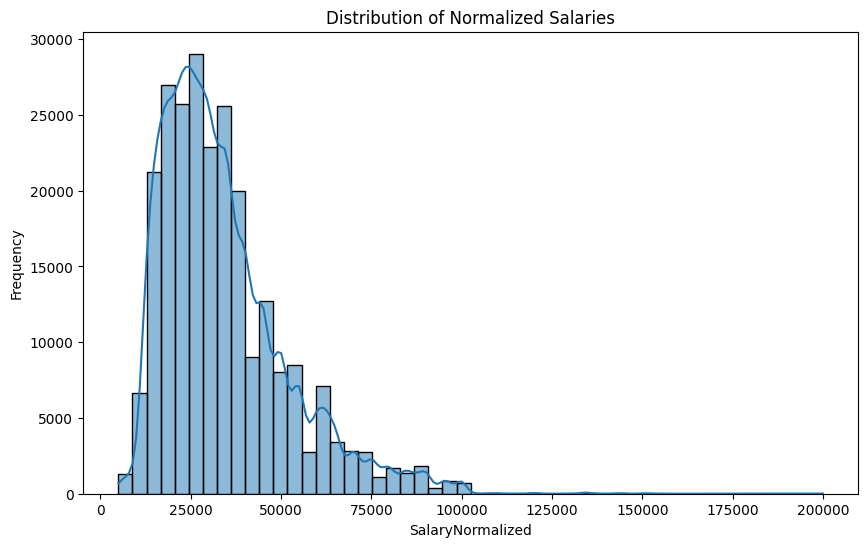

In [44]:
plt.figure(figsize=(10,6))
sns.histplot(df['SalaryNormalized'], bins=50, kde=True)
plt.title('Distribution of Normalized Salaries')
plt.xlabel('SalaryNormalized')
plt.ylabel('Frequency')
plt.show()

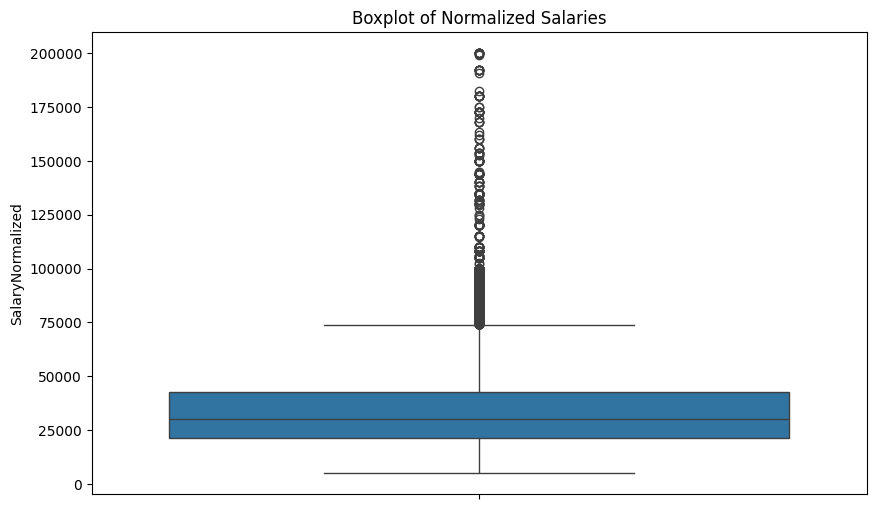

In [45]:
plt.figure(figsize=(10,6))
sns.boxplot(y='SalaryNormalized', data=df)
plt.title('Boxplot of Normalized Salaries')
plt.ylabel('SalaryNormalized')
plt.show()

I will also look how the salary is distributed after some transformations. Let's start with log transformation.

##### Log transformed salary distribution

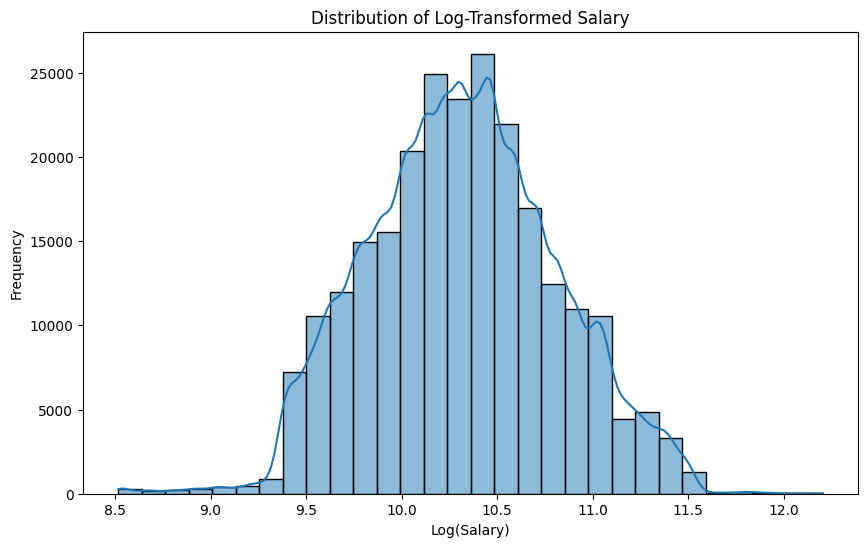

In [239]:
df['Salary_log1p'] = np.log1p(df['SalaryNormalized'])

plt.figure(figsize=(10,6))
sns.histplot(df['Salary_log1p'], bins=30, kde=True)
plt.title('Distribution of Log-Transformed Salary')
plt.xlabel('Log(Salary)')
plt.ylabel('Frequency')
plt.show()

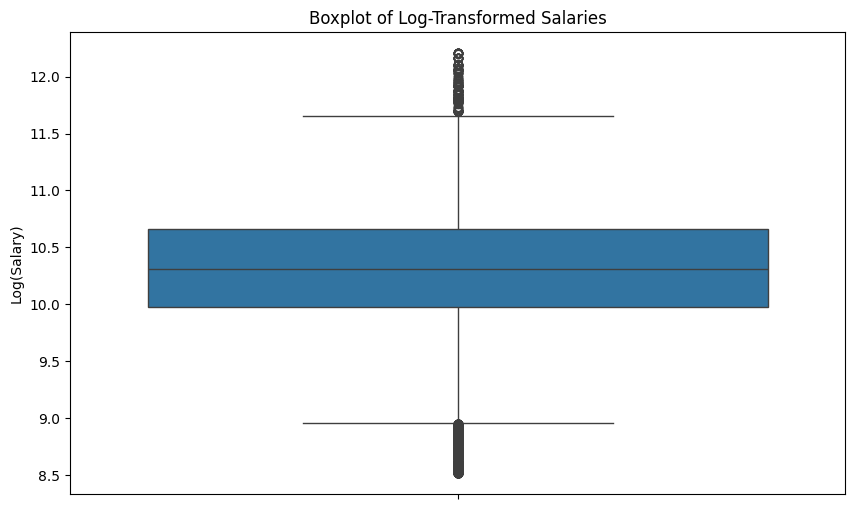

In [240]:
plt.figure(figsize=(10,6))
sns.boxplot(y=df['Salary_log1p'])
plt.title('Boxplot of Log-Transformed Salaries')
plt.ylabel('Log(Salary)')
plt.show()

In [245]:
# to inverse if needed
original_salary = np.expm1(df['Salary_log1p'])
np.allclose(original_salary, df['SalaryNormalized'])

True

##### Standardized salary distribution

We know that standardization and normalization don't change the shape of the distribution, so we will only plot it to check values.

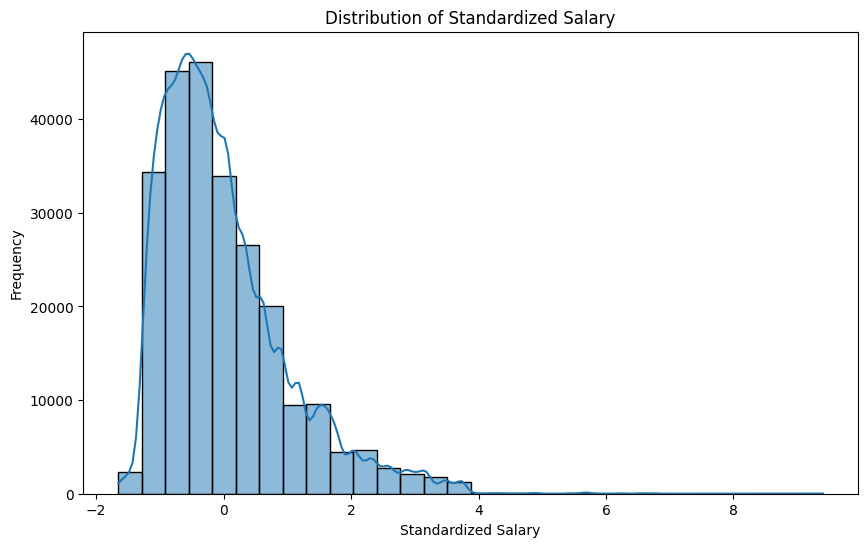

In [241]:
df['Salary_standardized'] = (df['SalaryNormalized'] - df['SalaryNormalized'].mean()) / df['SalaryNormalized'].std()

plt.figure(figsize=(10,6))
sns.histplot(df['Salary_standardized'], bins=30, kde=True)
plt.title('Distribution of Standardized Salary')
plt.xlabel('Standardized Salary')
plt.ylabel('Frequency')
plt.show()

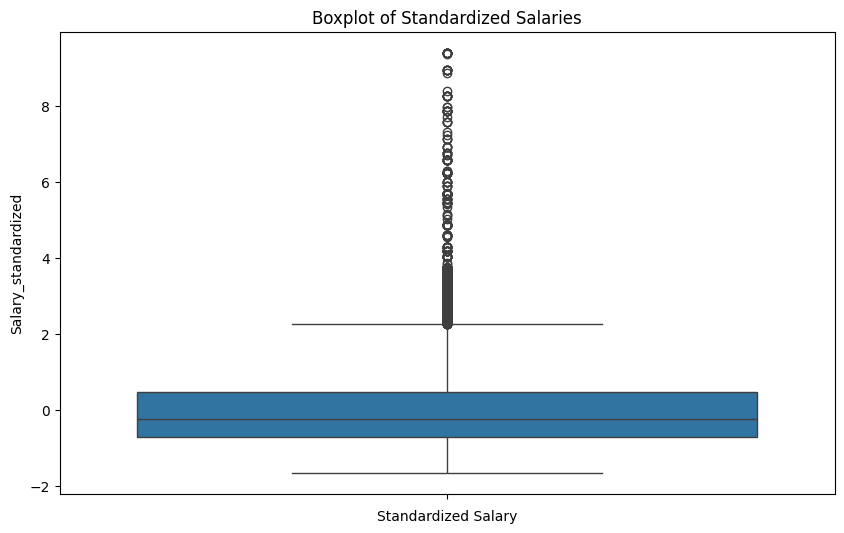

In [250]:
plt.figure(figsize=(10,6))
sns.boxplot(y=df['Salary_standardized'])
plt.title('Boxplot of Standardized Salaries')
plt.xlabel('Standardized Salary')
plt.show()

##### Normalized (Min-Max) salary distribution

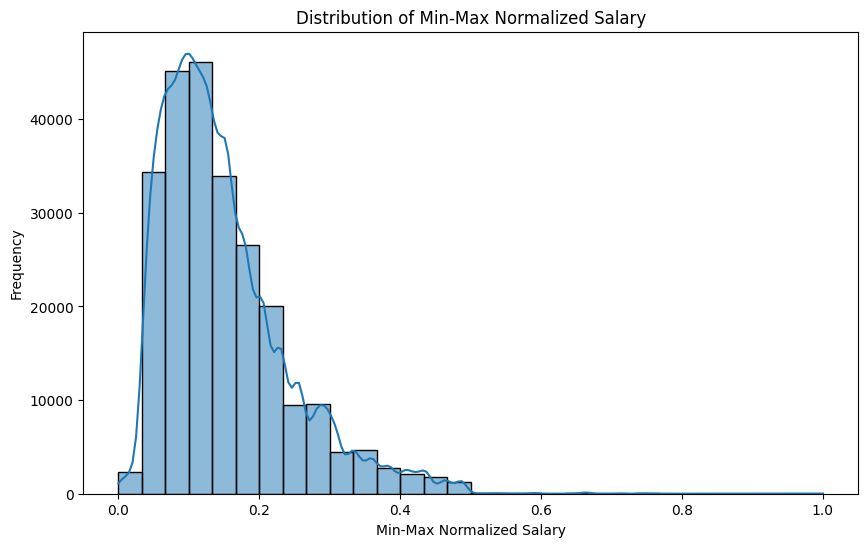

In [246]:
df['Salary_minmax'] = (df['SalaryNormalized'] - df['SalaryNormalized'].min()) / (df['SalaryNormalized'].max() - df['SalaryNormalized'].min())

plt.figure(figsize=(10,6))
sns.histplot(df['Salary_minmax'], bins=30, kde=True)
plt.title('Distribution of Min-Max Normalized Salary')
plt.xlabel('Min-Max Normalized Salary')
plt.ylabel('Frequency')
plt.show()

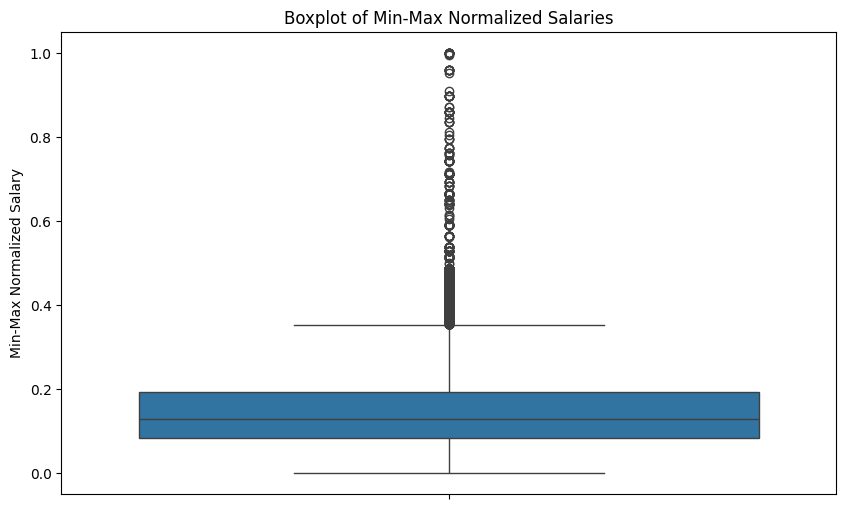

In [247]:
plt.figure(figsize=(10,6))
sns.boxplot(y='Salary_minmax', data=df)
plt.title('Boxplot of Min-Max Normalized Salaries')
plt.ylabel('Min-Max Normalized Salary')
plt.show()

#### Inspecting the 'SourceName' column

In [46]:
df['SourceName'].head(10)

0    cv-library.co.uk
1    cv-library.co.uk
2    cv-library.co.uk
3    cv-library.co.uk
4    cv-library.co.uk
5    cv-library.co.uk
6    cv-library.co.uk
7    cv-library.co.uk
8    cv-library.co.uk
9    cv-library.co.uk
Name: SourceName, dtype: object

In [47]:
df['SourceName'].isnull().sum() 

np.int64(1)

In [48]:
df.loc[df['SourceName'].isnull()]

,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
224434,Senior C++ Engineer / C++ Performance Optimisa...,"Tier One Investment Bank""",Senior C++ Engineer / C++ Performance Optimisa...,London,NaN,NaN,Montash Limited,Accounting & Finance Jobs,"Up To 120,000 Plus Uncapped Bonus",120000,NaN


In [49]:
df['SourceName'].value_counts()

SourceName
totaljobs.com             48149
cv-library.co.uk          34279
Jobcentre Plus            17929
jobsite.co.uk             12225
cwjobs.co.uk               7011
                          ...  
eastmidlandsjobs.co.uk        2
greatbritishjobs.co.uk        2
broadcastjobs.co.uk           2
jobs.cabincrew.com            1
cvjobstore.com                1
Name: count, Length: 167, dtype: int64

In [50]:
df['SourceName'].nunique()

167

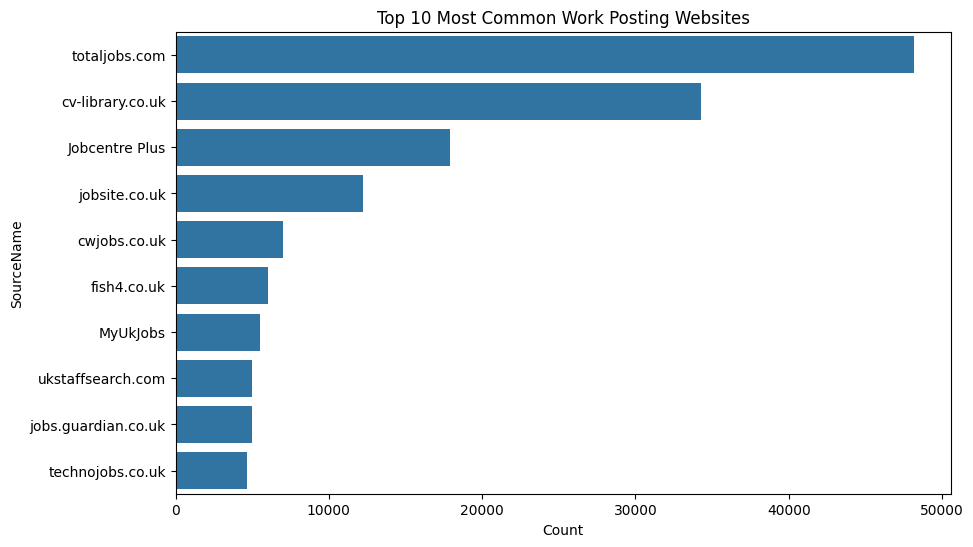

In [51]:
plt.figure(figsize=(10,6))
sns.countplot(y='SourceName', data=df, order=df['SourceName'].value_counts().index[:10])
plt.title('Top 10 Most Common Work Posting Websites')
plt.xlabel('Count')
plt.ylabel('SourceName')
plt.show()

We have missing values only in categorical columns. As for now we will fill them with 'Unknown' value.

In [52]:
cols_with_na = ["ContractType", "ContractTime", "Company", "SourceName"]

df[cols_with_na] = df[cols_with_na].fillna("Unknown")

df.isnull().sum()

Title                 0
FullDescription       0
LocationRaw           0
LocationNormalized    0
ContractType          0
ContractTime          0
Company               0
Category              0
SalaryRaw             0
SalaryNormalized      0
SourceName            0
dtype: int64

### Bivariate Analysis

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244768 entries, 0 to 244767
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   Title               244768 non-null  object
 1   FullDescription     244768 non-null  object
 2   LocationRaw         244768 non-null  object
 3   LocationNormalized  244768 non-null  object
 4   ContractType        244768 non-null  object
 5   ContractTime        244768 non-null  object
 6   Company             244768 non-null  object
 7   Category            244768 non-null  object
 8   SalaryRaw           244768 non-null  object
 9   SalaryNormalized    244768 non-null  int64 
 10  SourceName          244768 non-null  object
dtypes: int64(1), object(10)
memory usage: 20.5+ MB


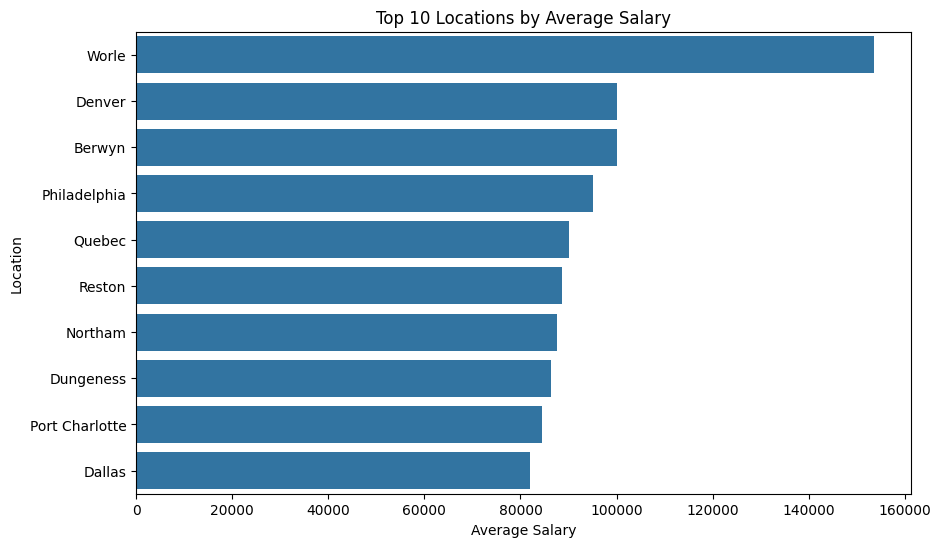

In [54]:
# Avg Salary by Location
salaries_by_location = df.groupby('LocationNormalized')['SalaryNormalized'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=salaries_by_location.values, y=salaries_by_location.index)
plt.title('Top 10 Locations by Average Salary')
plt.xlabel('Average Salary')
plt.ylabel('Location')
plt.show()

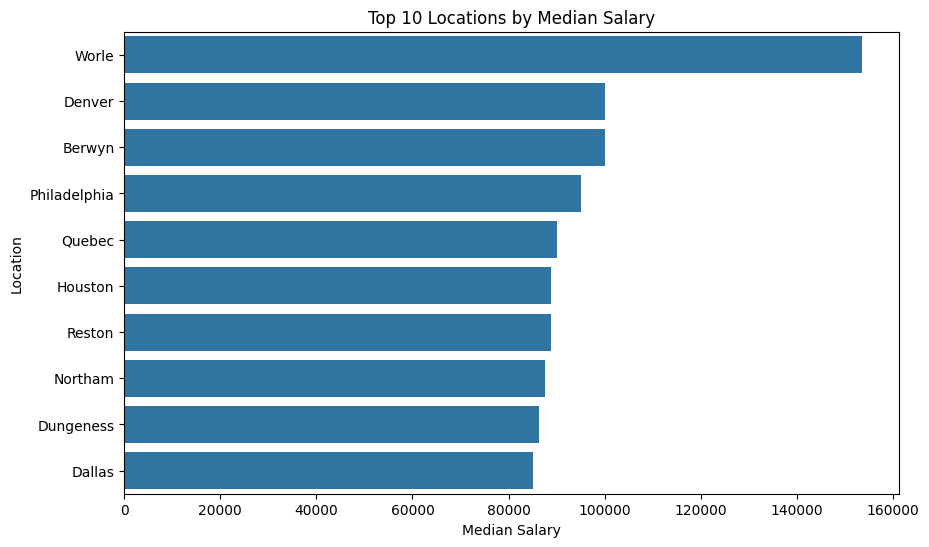

In [55]:
# Median Salary by Location
salaries_by_location_median = df.groupby('LocationNormalized')['SalaryNormalized'].median().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=salaries_by_location_median.values, y=salaries_by_location_median.index)
plt.title('Top 10 Locations by Median Salary')
plt.xlabel('Median Salary')
plt.ylabel('Location')
plt.show()

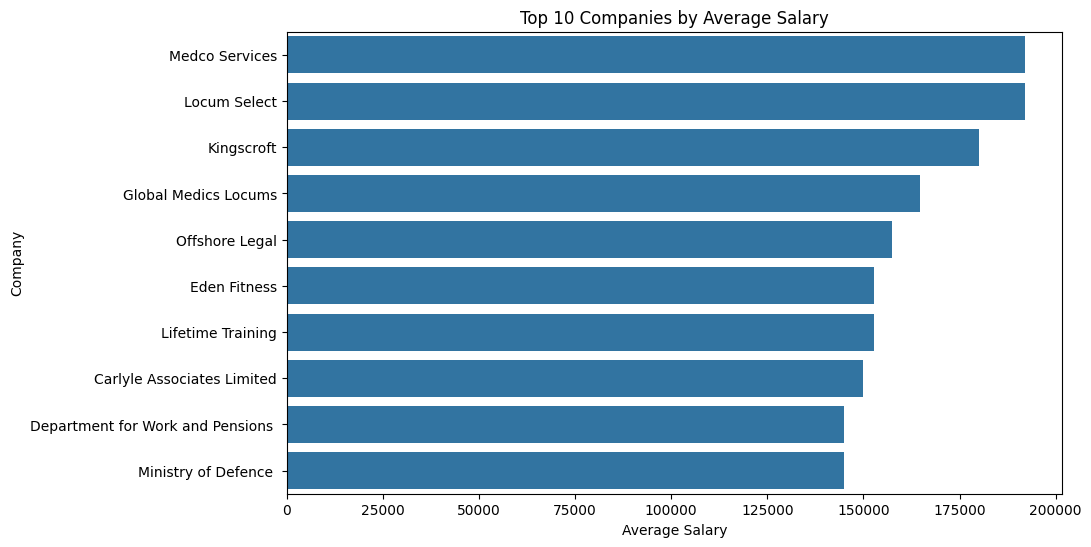

In [56]:
# Highest paying companies
highest_paying_companies = df.groupby('Company')['SalaryNormalized'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=highest_paying_companies.values, y=highest_paying_companies.index)
plt.title('Top 10 Companies by Average Salary')
plt.xlabel('Average Salary')
plt.ylabel('Company')
plt.show()

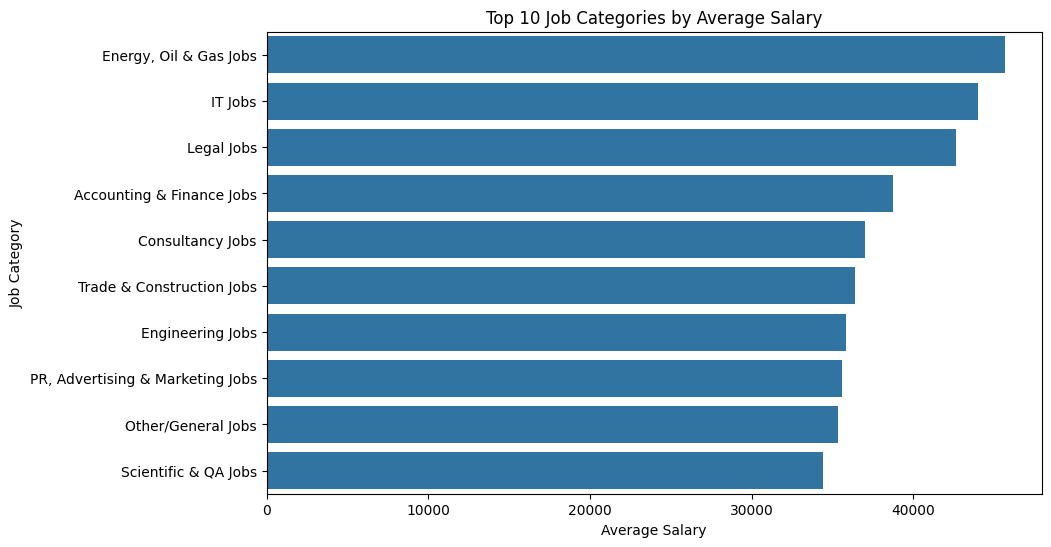

In [57]:
# Highest paying categories
salaries_by_category = df.groupby('Category')['SalaryNormalized'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=salaries_by_category.values, y=salaries_by_category.index)
plt.title('Top 10 Job Categories by Average Salary')    
plt.xlabel('Average Salary')
plt.ylabel('Job Category')
plt.show()

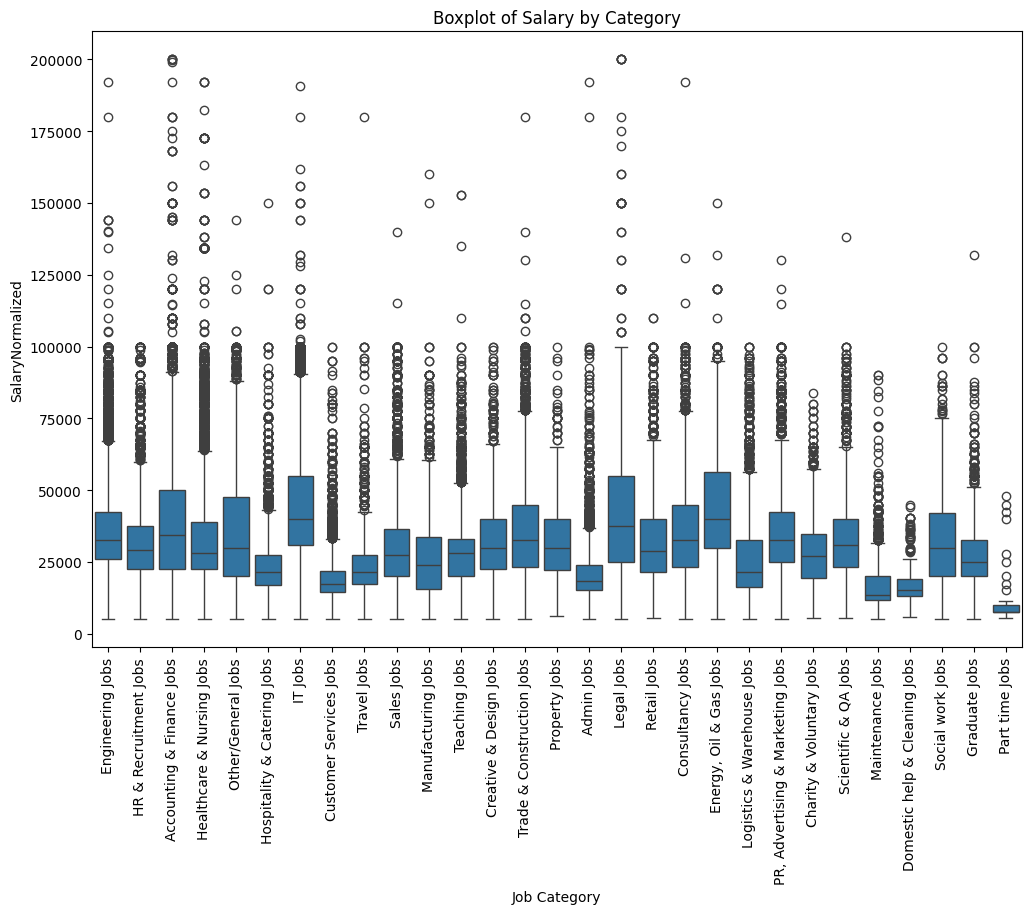

In [58]:
# Boxplot of Salary by Category
plt.figure(figsize=(12,8))
sns.boxplot(x='Category', y='SalaryNormalized', data=df)
plt.title('Boxplot of Salary by Category')
plt.xlabel('Job Category')
plt.ylabel('SalaryNormalized')
plt.xticks(rotation=90)
plt.show()

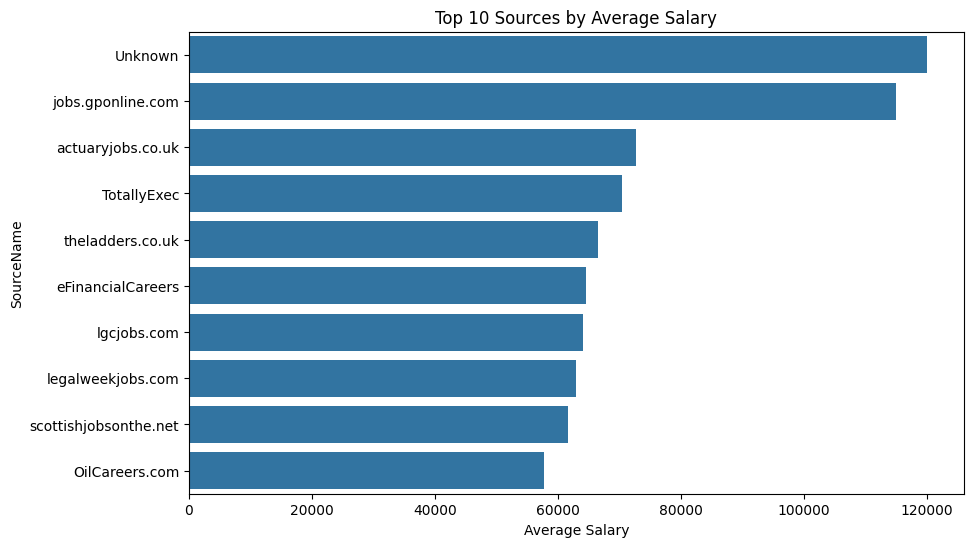

In [59]:
# Salary by SourceName
salaries_by_source = df.groupby('SourceName')['SalaryNormalized'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=salaries_by_source.values, y=salaries_by_source.index)
plt.title('Top 10 Sources by Average Salary')
plt.xlabel('Average Salary')
plt.ylabel('SourceName')    
plt.show()

## Phase 1: Baseline with categorical features

In the first phase, we will create a baseline model using only categorical features. This will help us understand the performance of a simple model before incorporating text data. We will include columns: Category, Company, LocationNormalized, ContractType and ContractTime. As for now we will fill missing values with 'Unknown' value.


In [60]:
df = pd.read_csv(FILEPATH)
df.loc[df['Title'].isnull(), 'Title'] = 'Quality Improvement Manager'
cols_with_na = ["ContractType", "ContractTime", "Company", "SourceName"]
df[cols_with_na] = df[cols_with_na].fillna("Unknown")

In [61]:
df_cat = df[['Category', 'Company', 'LocationNormalized', 'ContractType', 'ContractTime', 'SalaryNormalized']]
df_cat.head()

,Category,Company,LocationNormalized,ContractType,ContractTime,SalaryNormalized
0,Engineering Jobs,Gregory Martin International,Dorking,Unknown,permanent,25000
1,Engineering Jobs,Gregory Martin International,Glasgow,Unknown,permanent,30000
2,Engineering Jobs,Gregory Martin International,Hampshire,Unknown,permanent,30000
3,Engineering Jobs,Gregory Martin International,Surrey,Unknown,permanent,27500
4,Engineering Jobs,Gregory Martin International,Surrey,Unknown,permanent,25000


 We need to convert categorical variables into numerical format.

In [62]:
for col in df_cat.columns:
    print(f"{col}: {df_cat[col].nunique()} unique values")

Category: 29 unique values
Company: 20812 unique values
LocationNormalized: 2732 unique values
ContractType: 3 unique values
ContractTime: 3 unique values
SalaryNormalized: 8454 unique values


For columns Category, ContractType and ContractTime we will use One-Hot Encoding as they have a small number of unique values.
For columns Company and LocationNormalized we will use Target Encoding as they have a large number of unique values.

Before transforming our categorical variables, let's split the data into training, validation and test sets to avoid data leakage.

### Splitting the data into training, validation and test sets

In [63]:
X = df_cat.drop(columns=['SalaryNormalized'])
y = df_cat['SalaryNormalized']

# Split the data into training (80%), validation (10%) and test (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED)
print(f"Train set has {len(X_train)} entries")
print(f"Validation set has {len(X_valid)} entries")
print(f"Test set has {len(X_test)} entries")

Train set has 195814 entries
Validation set has 24477 entries
Test set has 24477 entries


### Creating custom Dataset class

In [4]:
class SalaryDataset(Dataset):
    def __init__(self, X: np.ndarray | pd.DataFrame, y: np.ndarray | pd.Series):
        """
        Custom PyTorch Dataset for salary prediction.

        This class handles the conversion of preprocessed features and scaled targets
        from numpy arrays or pandas data structures into PyTorch tensors.

        Args:
            X: Features for the dataset, can be a numpy array or a pandas DataFrame.
            y: Target values (salaries) for the dataset, can be a numpy array or a pandas Series.
        """
        self.X = torch.tensor(X.values, dtype=torch.float32) if isinstance(X, pd.DataFrame) else torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.X[idx], self.y[idx]

### Preprocessing pipeline

Before feeding the data into custom Dataset class, we will create a preprocessing pipeline that will handle the transformations of categorical variables and scaling of the target variable.

In [65]:
one_hot_cols = ['Category', 'ContractType', 'ContractTime']
target_enc_cols = ['Company', 'LocationNormalized']
target_col = 'SalaryNormalized'

# One-hot encoding pipeline for columns with few unique values
one_hot_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Target encoding pipeline for columns with many unique values, followed by scaling
target_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('target_enc', TargetEncoder()),
    ('scaler', StandardScaler())
])

# Combine both pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('onehot', one_hot_pipeline, one_hot_cols),
    ('target_scaled', target_pipeline, target_enc_cols)
])

# Fit and transform training data, transform validation and test data
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_valid_processed = preprocessor.transform(X_valid)
X_test_processed = preprocessor.transform(X_test)

# Scale target variable
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_valid_scaled = target_scaler.transform(y_valid.values.reshape(-1, 1)).ravel()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

# Create PyTorch datasets
train_dataset = SalaryDataset(X_train_processed, y_train_scaled)
valid_dataset = SalaryDataset(X_valid_processed, y_valid_scaled)
test_dataset = SalaryDataset(X_test_processed, y_test_scaled)

# Save preprocessor and scaler for later use
joblib.dump(preprocessor, PREPROCESSORS_DIR + 'preprocessor.pkl')
joblib.dump(target_scaler, PREPROCESSORS_DIR + 'target_scaler.pkl')


['preprocessors/target_scaler.pkl']

### Creating data loaders

In [66]:
batch_size = 32
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)

In [67]:
# Check number of batches
print(f"Number of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(valid_loader)}")
print(f"Number of test batches: {len(test_loader)}")

Number of training batches: 6120
Number of validation batches: 765
Number of test batches: 765


In [68]:
for X_batch, y_batch in train_loader:
    print(f"Batch X shape: {X_batch.shape}")
    print(f"Batch y shape: {y_batch.shape}")
    print(X_batch)
    print(y_batch)
    break  # Just to check the first batch

Batch X shape: torch.Size([32, 37])
Batch y shape: torch.Size([32])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  0.8252,  1.4715],
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  0.1705, -1.1909],
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0000, -0.0582, -0.0568],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  2.6743,  1.1740],
        [ 0.0000,  0.0000,  0.0000,  ...,  1.0000,  0.3381, -1.1879],
        [ 1.0000,  0.0000,  0.0000,  ...,  1.0000,  0.0488,  1.9749]])
tensor([ 0.3334,  0.3334, -0.0829, -0.2803,  0.1535,  0.6781, -0.7152, -0.5168,
         2.6009, -0.6007,  0.5318,  0.9286,  0.1379,  2.0340,  1.6088, -0.9136,
         1.1270,  0.2201, -0.2901,  0.4604, -0.2618, -0.5735, -0.2901,  2.5555,
         0.2427,  0.3901,  0.9003,  2.3174, -0.8570,  0.4043, -0.3751, -0.0917])


### Building simple model

In [69]:
class SimpleRegressor(nn.Module):
    def __init__(self, input_dim: int, hidden_size: int = 64, dropout_prob: float = 0.2):
        """
        A simple feed-forward neural network for regression tasks.

        This model consists of two hidden layers with ReLU activation and dropout,
        followed by an output layer with a single neuron.

        Args:
            input_dim: The number of features in the input data.
            hidden_size: The number of neurons in the first hidden layer. The second
                         hidden layer will have half this number. Defaults to 64.
            dropout_prob: The dropout probability for the dropout layers. Defaults to 0.2.
        """
        super(SimpleRegressor, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

### Training the model

#### Custom Early Stopping class

In [5]:
class EarlyStopping:
    """
    Early stops the training if validation loss doesn't improve after a given patience.
    
    This class monitors the validation loss and halts the training process if
    the loss does not decrease for a specified number of epochs. It can also
    restore the model's weights from the best-performing epoch.
    """
    def __init__(self, patience: int = 5, delta: float = 0, verbose: bool = False, restore_best_weights: bool = True):
        """
        Initializes the EarlyStopping instance.

        Args:
            patience: How many epochs to wait for a validation loss improvement before
                      stopping. Defaults to 5.
            delta: Minimum change in the monitored quantity to qualify as an improvement.
                   Defaults to 0.
            verbose: If True, prints a message for each improvement and when early stopping
                     is triggered. Defaults to False.
            restore_best_weights: If True, the model's weights from the best-performing
                                  epoch are restored upon early stopping. Defaults to True.
        """
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.best_weights = None
        self.no_improvement_count = 0
        self.stop_training = False

    def check_early_stop(self, val_loss: float, model: torch.nn.Module):
        """
        Checks the validation loss and updates the internal state.

        Args:
            val_loss: The current validation loss.
            model: The PyTorch model being trained.
        """
        if self.best_loss is None or val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.no_improvement_count = 0
            if self.restore_best_weights:
                self.best_weights = model.state_dict().copy()
            if self.verbose:
                print(f'Validation loss improved to {val_loss:.6f}.')
        else:
            self.no_improvement_count += 1
            if self.verbose:
                if self.no_improvement_count == 1:
                    print(f'No improvement in validation loss for {self.no_improvement_count} epoch.')
                else:
                    print(f'No improvement in validation loss for {self.no_improvement_count} epochs.')
            if self.no_improvement_count >= self.patience:
                self.stop_training = True
                if self.restore_best_weights and self.best_weights is not None:
                    model.load_state_dict(self.best_weights)
                    if self.verbose:
                        print('Restored best model weights.')
                if self.verbose:
                    print('Early stopping triggered.')

#### Fuction to plot training and validation loss

In [71]:
def plot_losses(
    train_losses: List[float], 
    valid_losses: List[float], 
    train_real_losses: Optional[List[float]] = None, 
    valid_real_losses: Optional[List[float]] = None
):
    """
    Plot training and validation losses.

    This function can plot either the scaled losses or both scaled and real-scale
    losses side-by-side, depending on whether the real-scale losses are provided.

    Args:
        train_losses: A list of scaled training loss values, one for each epoch.
        valid_losses: A list of scaled validation loss values, one for each epoch.
        train_real_losses: An optional list of real-scale training loss values.
                           Defaults to None.
        valid_real_losses: An optional list of real-scale validation loss values.
                           Defaults to None.
    """
    if train_real_losses is None or valid_real_losses is None:
        # Only plot scaled losses
        fig, ax = plt.subplots(1, 1, figsize=(10, 6))
        
        epochs = range(1, len(train_losses) + 1)
        ax.plot(epochs, train_losses, color='blue', label='Train Loss', linewidth=2)
        ax.plot(epochs, valid_losses, color='orange', label='Validation Loss', linewidth=2)
        ax.set_xlabel('Epoch', fontsize=12)
        ax.set_ylabel('Loss (Scaled MSE)', fontsize=12)
        ax.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
        ax.legend(fontsize=11)
        ax.grid(True, alpha=0.3)
        
    else:
        # Plot both scaled and real losses
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        epochs = range(1, len(train_losses) + 1)
        
        # Plot 1: Scaled MSE
        axes[0].plot(epochs, train_losses, color='blue', label='Train Loss', linewidth=2)
        axes[0].plot(epochs, valid_losses, color='orange', label='Validation Loss', linewidth=2)
        axes[0].set_xlabel('Epoch', fontsize=11)
        axes[0].set_ylabel('Loss (Scaled MSE)', fontsize=11)
        axes[0].set_title('Scaled MSE Loss', fontsize=12, fontweight='bold')
        axes[0].legend(fontsize=10)
        axes[0].grid(True, alpha=0.3)

        # Plot 2: Real MSE
        axes[1].plot(epochs, train_real_losses, color='blue', label='Train Loss', linewidth=2)
        axes[1].plot(epochs, valid_real_losses, color='orange', label='Validation Loss', linewidth=2)
        axes[1].set_xlabel('Epoch', fontsize=11)
        axes[1].set_ylabel('Loss (Real MSE)', fontsize=11)
        axes[1].set_title('Real Scale MSE Loss', fontsize=12, fontweight='bold')
        axes[1].legend(fontsize=10)
        axes[1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

#### Training loop

In [72]:
# Set random seed for reproducibility
set_seed()

# Define model hyperparameters
input_dim = X_train_processed.shape[1]
hidden_size = 128
dropout_prob = 0.2

# Initialize the model and move to device
model = SimpleRegressor(input_dim, hidden_size, dropout_prob).to(device)

# Define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load target scaler for inverse transformation
target_scaler = joblib.load(PREPROCESSORS_DIR + '/' + 'target_scaler.pkl')

# Training loop parameters
n_epochs = 30
patience = 4
delta = 0.001
early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True, restore_best_weights=True)

# Lists to store training and validation loss
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

# Training loop
for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss (scaled)
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate scaled loss
        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    # Average training losses
    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    # Validation loop
    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
            y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Average validation losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Print epoch results
    print(f'Epoch {epoch+1}/{n_epochs}:')
    print(f'  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}')
    print(f'  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}')

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg,  model)
    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch+1}") 
        break

Epoch 1/30:
  Train - MSE: 0.5856, Real MSE: 182261520.00, Real RMSE: 13500.43
  Valid - MSE: 0.6104, Real MSE: 189973344.00, Real RMSE: 13783.08
Validation loss improved to 0.610428.
Epoch 2/30:
  Train - MSE: 0.5714, Real MSE: 177831280.00, Real RMSE: 13335.34
  Valid - MSE: 0.6057, Real MSE: 188493072.00, Real RMSE: 13729.28
Validation loss improved to 0.605671.
Epoch 3/30:
  Train - MSE: 0.5685, Real MSE: 176913248.00, Real RMSE: 13300.87
  Valid - MSE: 0.6028, Real MSE: 187584944.00, Real RMSE: 13696.17
Validation loss improved to 0.602753.
Epoch 4/30:
  Train - MSE: 0.5660, Real MSE: 176151472.00, Real RMSE: 13272.21
  Valid - MSE: 0.6096, Real MSE: 189716960.00, Real RMSE: 13773.78
No improvement in validation loss for 1 epoch.
Epoch 5/30:
  Train - MSE: 0.5658, Real MSE: 176080512.00, Real RMSE: 13269.53
  Valid - MSE: 0.6029, Real MSE: 187629008.00, Real RMSE: 13697.77
No improvement in validation loss for 2 epochs.
Epoch 6/30:
  Train - MSE: 0.5639, Real MSE: 175500288.00, Re

- `.reshape(-1, 1)` - StandardScaler expects 2D input, so reshape the 1D arrays
- `.ravel()` - Flatten back to 1D after inverse transform for easier calculation
- `.detach()` - Remove from computation graph (important in training loop)
- `.cpu()` - Move to CPU for numpy operations

#### Plotting training and validation loss

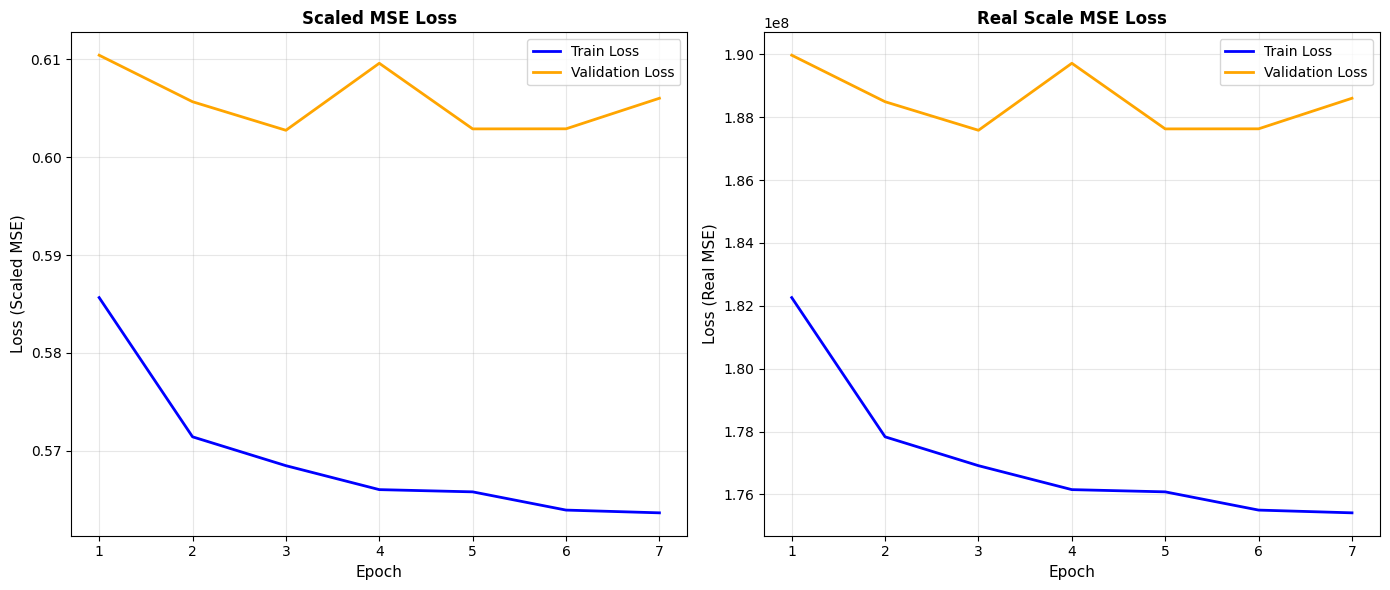

In [73]:
plot_losses(train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real)

#### Explore model parameters

In [74]:
import torch.nn as nn

def print_model_parameters_summary(model: nn.Module):
    """
    Prints the parameter count for each named layer and the total sum.
    """
    total_params = 0
    
    # Print layer-wise details
    for name, param in model.named_parameters():
        num_params = param.numel()
        print(f"{name}: {num_params:,} parameters, trainable={param.requires_grad}")
        total_params += num_params
    
    # Print summed total
    print("-" * 40)
    print(f"Total Parameters: {total_params:,}")

In [75]:
print_model_parameters_summary(model)

fc1.weight: 4,736 parameters, trainable=True
fc1.bias: 128 parameters, trainable=True
fc2.weight: 8,192 parameters, trainable=True
fc2.bias: 64 parameters, trainable=True
fc3.weight: 64 parameters, trainable=True
fc3.bias: 1 parameters, trainable=True
----------------------------------------
Total Parameters: 13,185


#### Save the model

In [76]:
model_name = 'cat_unk_bs32_adam_lrs_no_hid128_dr20'
torch.save(model.state_dict(), MODELS_DIR + model_name + '.pth')

#### Evaluate on test set for later comparison

In [77]:
baseline_models_test_scores = dict()

In [78]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    baseline_models_test_scores[model_name] = {
        'Test MSE (scaled)': test_loss_scaled_avg,
        'Test MSE (real)': test_loss_real_avg,
        'Test RMSE (real)': np.sqrt(test_loss_real_avg)
    }

### Hyperparameter tuning / other approaches

#### Replacing missing values with most frequent values

In [230]:
df = pd.read_csv(FILEPATH)  
df = df.drop(columns=['Id'])
df_cat = df[['Category', 'Company', 'LocationNormalized', 'ContractType', 'ContractTime', 'SalaryNormalized']]
X = df_cat.drop(columns=['SalaryNormalized'])
y = df_cat['SalaryNormalized']

# Split the data into training (80%), validation (10%) and test (10%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED)

one_hot_cols = ['Category', 'ContractType', 'ContractTime']
target_enc_cols = ['Company', 'LocationNormalized']
target_col = 'SalaryNormalized'

# One-hot encoding pipeline for columns with few unique values
one_hot_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # fill missing values with most frequent
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# Target encoding pipeline for columns with many unique values, followed by scaling
target_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # fill missing values with most frequent
    ('target_enc', TargetEncoder()),
    ('scaler', StandardScaler())
])

# Combine both pipelines using ColumnTransformer
preprocessor = ColumnTransformer([
    ('onehot', one_hot_pipeline, one_hot_cols),
    ('target_scaled', target_pipeline, target_enc_cols)
])

# Fit and transform training data, transform validation and test data
X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_valid_processed = preprocessor.transform(X_valid)
X_test_processed = preprocessor.transform(X_test)

# Scale target variable
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_valid_scaled = target_scaler.transform(y_valid.values.reshape(-1, 1)).ravel()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

# Create PyTorch datasets
train_dataset = SalaryDataset(X_train_processed, y_train_scaled)
valid_dataset = SalaryDataset(X_valid_processed, y_valid_scaled)
test_dataset = SalaryDataset(X_test_processed, y_test_scaled)

# Save preprocessor and scaler for later use
joblib.dump(preprocessor, PREPROCESSORS_DIR + 'preprocessor.pkl')
joblib.dump(target_scaler, PREPROCESSORS_DIR + 'target_scaler.pkl')

batch_size = 32
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)


In [238]:
# Set random seed for reproducibility
set_seed()

# Define model architecture parameters
input_dim = X_train_processed.shape[1]
hidden_size = 128
dropout_prob = 0.2

# Initialize the regression model and move to device
model = SimpleRegressor(input_dim, hidden_size, dropout_prob).to(device)

# Define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load target scaler for inverse transformation
target_scaler = joblib.load(PREPROCESSORS_DIR + 'target_scaler.pkl')

# Training configuration
n_epochs = 30
patience = 4
delta = 0.001
early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True, restore_best_weights=True)

# Lists to store training and validation loss for each epoch
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

# Training loop
for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss in scaled space
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate scaled loss
        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    # Calculate average training losses
    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    # Validation loop
    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
            y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Calculate average validation losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Print epoch results
    print(f'Epoch {epoch+1}/{n_epochs}:')
    print(f'  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}')
    print(f'  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}')

    # Check early stopping condition
    early_stopping.check_early_stop(valid_loss_scaled_avg,  model)
    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch+1}") 
        break

Epoch 1/30:
  Train - MSE: 0.5961, Real MSE: 185514640.00, Real RMSE: 13620.38
  Valid - MSE: 0.6214, Real MSE: 193394304.00, Real RMSE: 13906.63
Validation loss improved to 0.621420.
Epoch 2/30:
  Train - MSE: 0.5832, Real MSE: 181503776.00, Real RMSE: 13472.33
  Valid - MSE: 0.6234, Real MSE: 194010864.00, Real RMSE: 13928.78
No improvement in validation loss for 1 epoch.
Epoch 3/30:
  Train - MSE: 0.5803, Real MSE: 180600416.00, Real RMSE: 13438.77
  Valid - MSE: 0.6208, Real MSE: 193209728.00, Real RMSE: 13899.99
No improvement in validation loss for 2 epochs.
Epoch 4/30:
  Train - MSE: 0.5787, Real MSE: 180108848.00, Real RMSE: 13420.46
  Valid - MSE: 0.6234, Real MSE: 194002368.00, Real RMSE: 13928.47
No improvement in validation loss for 3 epochs.
Epoch 5/30:
  Train - MSE: 0.5786, Real MSE: 180075200.00, Real RMSE: 13419.21
  Valid - MSE: 0.6184, Real MSE: 192451248.00, Real RMSE: 13872.68
Validation loss improved to 0.618390.
Epoch 6/30:
  Train - MSE: 0.5776, Real MSE: 179742

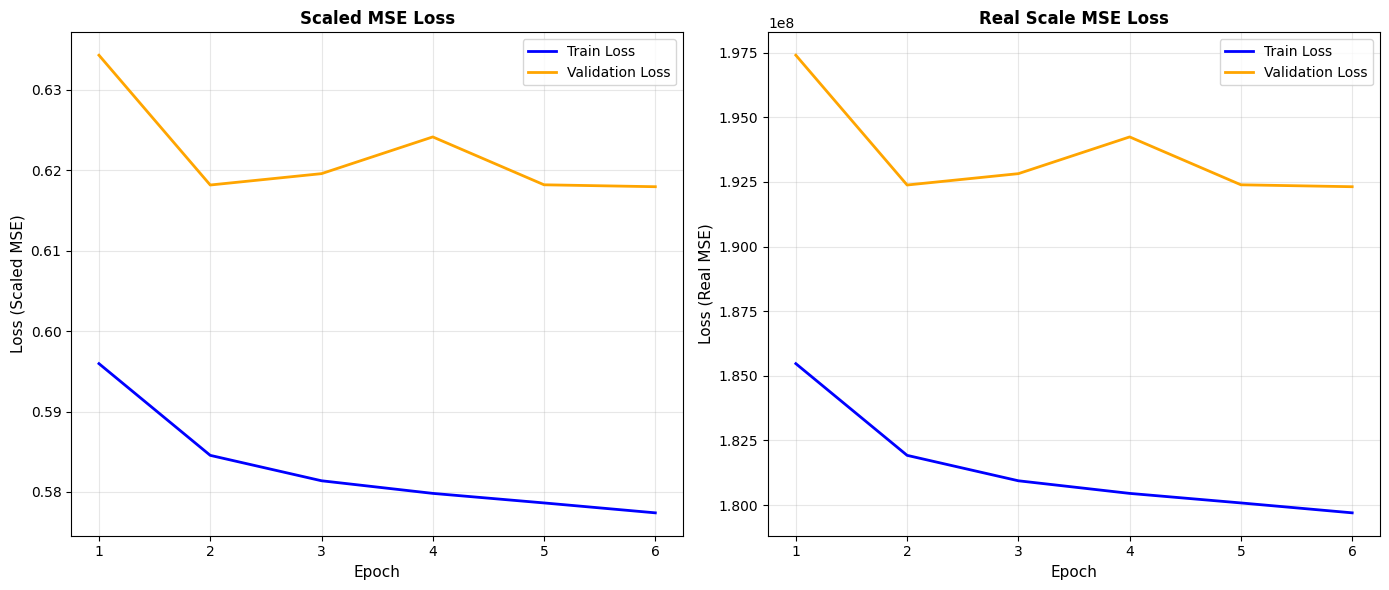

In [81]:
plot_losses(train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real)

In [82]:
print_model_parameters_summary(model)

fc1.weight: 4,480 parameters, trainable=True
fc1.bias: 128 parameters, trainable=True
fc2.weight: 8,192 parameters, trainable=True
fc2.bias: 64 parameters, trainable=True
fc3.weight: 64 parameters, trainable=True
fc3.bias: 1 parameters, trainable=True
----------------------------------------
Total Parameters: 12,929


In [83]:
model_name = 'cat_mf_bs32_adam_lrs_no_hid128_dr20'
torch.save(model.state_dict(), MODELS_DIR + model_name + '.pth')

In [84]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    baseline_models_test_scores[model_name] = {
        'Test MSE (scaled)': test_loss_scaled_avg,
        'Test MSE (real)': test_loss_real_avg,
        'Test RMSE (real)': np.sqrt(test_loss_real_avg)
    }

For the next approach we will replace missing values in categorical columns with 'Unknown' value as it did give better results in the previous experiments.

#### Trying batch size 64 

In [85]:
one_hot_cols = ['Category', 'ContractType', 'ContractTime']
target_enc_cols = ['Company', 'LocationNormalized']
target_col = 'SalaryNormalized'

one_hot_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

target_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('target_enc', TargetEncoder()),
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer([
    ('onehot', one_hot_pipeline, one_hot_cols),
    ('target_scaled', target_pipeline, target_enc_cols)
])

X_train_processed = preprocessor.fit_transform(X_train, y_train)
X_valid_processed = preprocessor.transform(X_valid)
X_test_processed = preprocessor.transform(X_test)

target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_valid_scaled = target_scaler.transform(y_valid.values.reshape(-1, 1)).ravel()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

train_dataset = SalaryDataset(X_train_processed, y_train_scaled)
valid_dataset = SalaryDataset(X_valid_processed, y_valid_scaled)
test_dataset = SalaryDataset(X_test_processed, y_test_scaled)

joblib.dump(preprocessor, PREPROCESSORS_DIR + 'preprocessor.pkl')
joblib.dump(target_scaler, PREPROCESSORS_DIR + 'target_scaler.pkl')

batch_size = 64
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)


In [86]:
# Set random seed for reproducibility
set_seed()

# Define model architecture parameters
input_dim = X_train_processed.shape[1]
hidden_size = 128
dropout_prob = 0.2

# Initialize the regression model and move to device
model = SimpleRegressor(input_dim, hidden_size, dropout_prob).to(device)

# Define loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Load target scaler for inverse transformation
target_scaler = joblib.load(PREPROCESSORS_DIR + 'target_scaler.pkl')

# Training configuration
n_epochs = 30
patience = 4
delta = 0.001
early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True, restore_best_weights=True)

# Lists to store training and validation loss for each epoch
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

# Training loop
for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss in scaled space
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Accumulate scaled loss
        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    # Calculate average training losses
    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    # Validation loop
    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
            y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Calculate average validation losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Print epoch results
    print(f'Epoch {epoch+1}/{n_epochs}:')
    print(f'  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}')
    print(f'  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}')

    # Check early stopping condition
    early_stopping.check_early_stop(valid_loss_scaled_avg,  model)
    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch+1}") 
        break

Epoch 1/30:
  Train - MSE: 0.5873, Real MSE: 182780032.00, Real RMSE: 13519.62
  Valid - MSE: 0.6036, Real MSE: 187839776.00, Real RMSE: 13705.46
Validation loss improved to 0.603572.
Epoch 2/30:
  Train - MSE: 0.5704, Real MSE: 177510032.00, Real RMSE: 13323.29
  Valid - MSE: 0.6094, Real MSE: 189662352.00, Real RMSE: 13771.80
No improvement in validation loss for 1 epoch.
Epoch 3/30:
  Train - MSE: 0.5670, Real MSE: 176468176.00, Real RMSE: 13284.13
  Valid - MSE: 0.6032, Real MSE: 187723040.00, Real RMSE: 13701.21
No improvement in validation loss for 2 epochs.
Epoch 4/30:
  Train - MSE: 0.5653, Real MSE: 175943696.00, Real RMSE: 13264.38
  Valid - MSE: 0.6024, Real MSE: 187480080.00, Real RMSE: 13692.34
Validation loss improved to 0.602417.
Epoch 5/30:
  Train - MSE: 0.5636, Real MSE: 175402768.00, Real RMSE: 13243.97
  Valid - MSE: 0.6023, Real MSE: 187446944.00, Real RMSE: 13691.13
No improvement in validation loss for 1 epoch.
Epoch 6/30:
  Train - MSE: 0.5627, Real MSE: 1751096

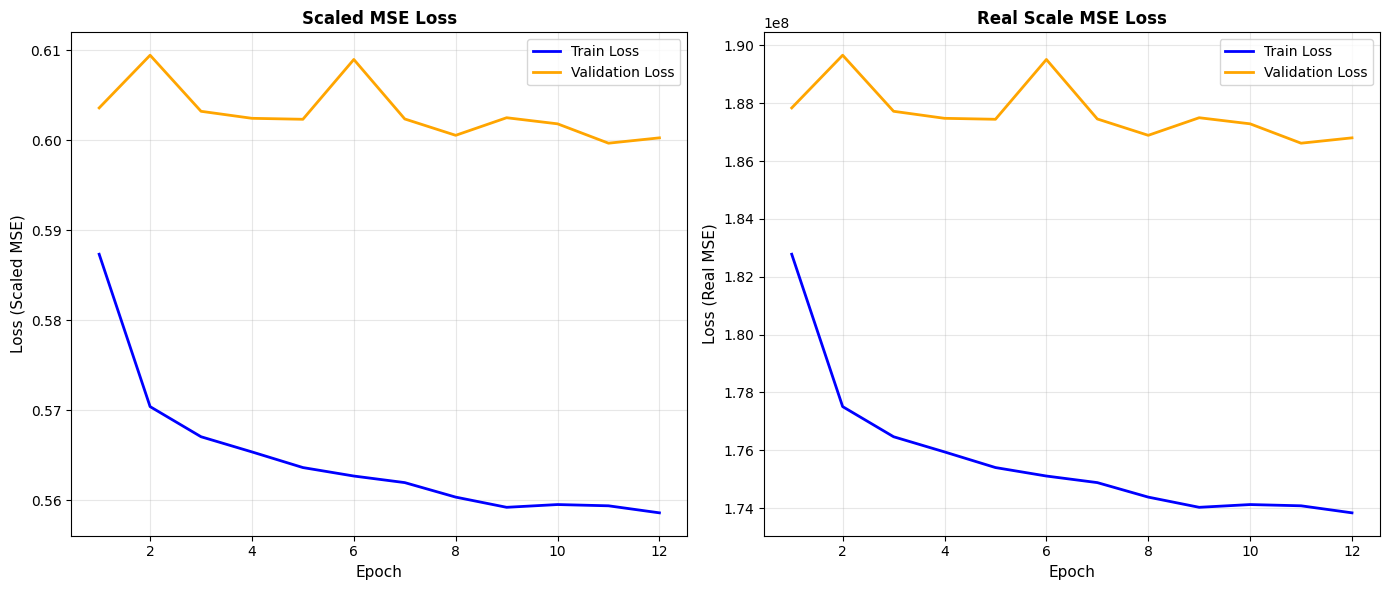

In [87]:
plot_losses(train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real)

In [88]:
print_model_parameters_summary(model)

fc1.weight: 4,736 parameters, trainable=True
fc1.bias: 128 parameters, trainable=True
fc2.weight: 8,192 parameters, trainable=True
fc2.bias: 64 parameters, trainable=True
fc3.weight: 64 parameters, trainable=True
fc3.bias: 1 parameters, trainable=True
----------------------------------------
Total Parameters: 13,185


In [89]:
model_name = 'cat_unk_bs64_adam_lrs_no_hid128_dr20'
torch.save(model.state_dict(), MODELS_DIR + model_name + '.pth')

In [90]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    baseline_models_test_scores[model_name] = {
        'Test MSE (scaled)': test_loss_scaled_avg,
        'Test MSE (real)': test_loss_real_avg,
        'Test RMSE (real)': np.sqrt(test_loss_real_avg)
    }

#### Trying less neurons

In [91]:
set_seed()

input_dim = X_train_processed.shape[1]
hidden_size = 64
dropout_prob = 0.2

model = SimpleRegressor(input_dim, hidden_size, dropout_prob).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

target_scaler = joblib.load(PREPROCESSORS_DIR + 'target_scaler.pkl')

n_epochs = 30
patience = 4
delta = 0.001
early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True, restore_best_weights=True)

# Lists to store training and validation loss
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
            y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Average losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Print epoch results
    print(f'Epoch {epoch+1}/{n_epochs}:')
    print(f'  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}')
    print(f'  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}')

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg,  model)
    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch+1}") 
        break

Epoch 1/30:
  Train - MSE: 0.5990, Real MSE: 186417984.00, Real RMSE: 13653.50
  Valid - MSE: 0.6075, Real MSE: 189051072.00, Real RMSE: 13749.58
Validation loss improved to 0.607464.
Epoch 2/30:
  Train - MSE: 0.5764, Real MSE: 179375104.00, Real RMSE: 13393.10
  Valid - MSE: 0.6046, Real MSE: 188152544.00, Real RMSE: 13716.87
Validation loss improved to 0.604577.
Epoch 3/30:
  Train - MSE: 0.5735, Real MSE: 178487264.00, Real RMSE: 13359.91
  Valid - MSE: 0.6019, Real MSE: 187323680.00, Real RMSE: 13686.62
Validation loss improved to 0.601914.
Epoch 4/30:
  Train - MSE: 0.5721, Real MSE: 178032688.00, Real RMSE: 13342.89
  Valid - MSE: 0.6028, Real MSE: 187598496.00, Real RMSE: 13696.66
No improvement in validation loss for 1 epoch.
Epoch 5/30:
  Train - MSE: 0.5706, Real MSE: 177585728.00, Real RMSE: 13326.13
  Valid - MSE: 0.6002, Real MSE: 186803728.00, Real RMSE: 13667.62
Validation loss improved to 0.600243.
Epoch 6/30:
  Train - MSE: 0.5698, Real MSE: 177338544.00, Real RMSE: 1

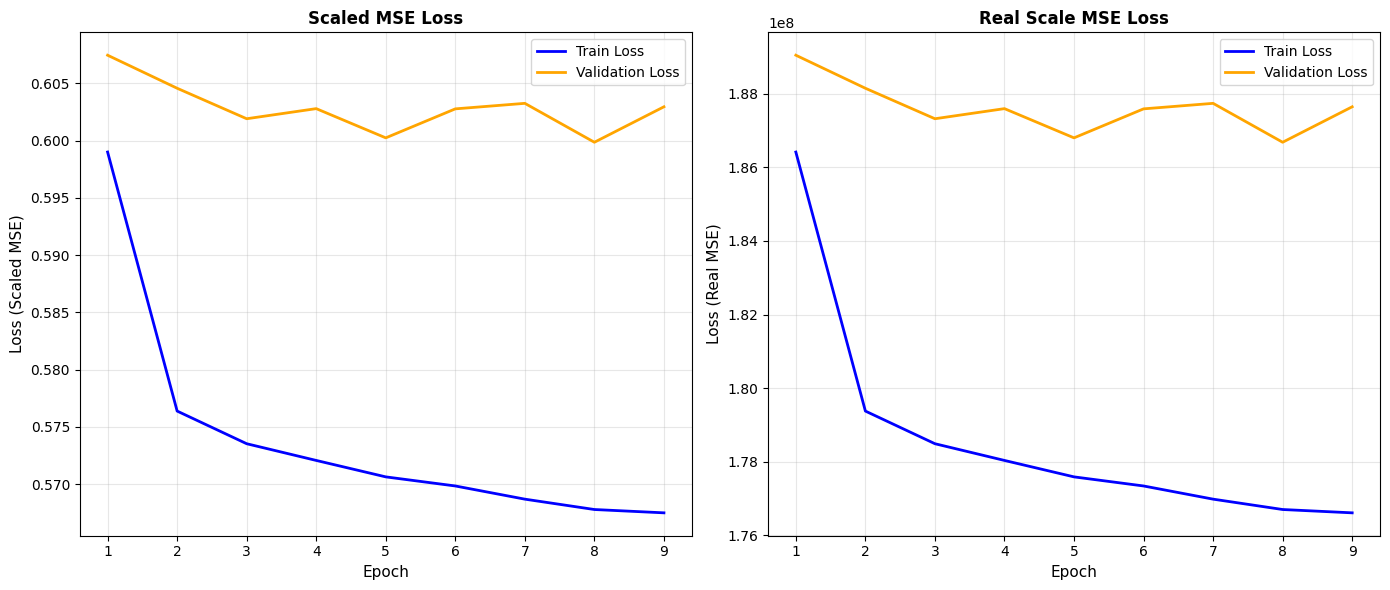

In [92]:
plot_losses(train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real)

In [93]:
print_model_parameters_summary(model)

fc1.weight: 2,368 parameters, trainable=True
fc1.bias: 64 parameters, trainable=True
fc2.weight: 2,048 parameters, trainable=True
fc2.bias: 32 parameters, trainable=True
fc3.weight: 32 parameters, trainable=True
fc3.bias: 1 parameters, trainable=True
----------------------------------------
Total Parameters: 4,545


In [94]:
model_name = 'cat_unk_bs32_adam_lrs_no_hid64_dr20'
torch.save(model.state_dict(), MODELS_DIR + model_name + '.pth')

In [95]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    baseline_models_test_scores[model_name] = {
        'Test MSE (scaled)': test_loss_scaled_avg,
        'Test MSE (real)': test_loss_real_avg,
        'Test RMSE (real)': np.sqrt(test_loss_real_avg)
    }

#### Different optimizer

In [96]:
# SGD optimizer with momentum
set_seed()

input_dim = X_train_processed.shape[1]
hidden_size = 128
dropout_prob = 0.2

model = SimpleRegressor(input_dim, hidden_size, dropout_prob).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

target_scaler = joblib.load(PREPROCESSORS_DIR + 'target_scaler.pkl')

n_epochs = 30
patience = 4
delta = 0.001
early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True, restore_best_weights=True)

# Lists to store training and validation loss
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
            y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Average losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Print epoch results
    print(f'Epoch {epoch+1}/{n_epochs}:')
    print(f'  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}')
    print(f'  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}')

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg,  model)
    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch+1}") 
        break

Epoch 1/30:
  Train - MSE: 0.6026, Real MSE: 187529216.00, Real RMSE: 13694.13
  Valid - MSE: 0.6134, Real MSE: 190883280.00, Real RMSE: 13816.05
Validation loss improved to 0.613352.
Epoch 2/30:
  Train - MSE: 0.5806, Real MSE: 180698800.00, Real RMSE: 13442.43
  Valid - MSE: 0.6105, Real MSE: 190005024.00, Real RMSE: 13784.23
Validation loss improved to 0.610529.
Epoch 3/30:
  Train - MSE: 0.5762, Real MSE: 179331808.00, Real RMSE: 13391.48
  Valid - MSE: 0.6087, Real MSE: 189444640.00, Real RMSE: 13763.89
Validation loss improved to 0.608729.
Epoch 4/30:
  Train - MSE: 0.5742, Real MSE: 178705440.00, Real RMSE: 13368.08
  Valid - MSE: 0.6023, Real MSE: 187445440.00, Real RMSE: 13691.07
Validation loss improved to 0.602305.
Epoch 5/30:
  Train - MSE: 0.5712, Real MSE: 177769136.00, Real RMSE: 13333.01
  Valid - MSE: 0.6049, Real MSE: 188267376.00, Real RMSE: 13721.06
No improvement in validation loss for 1 epoch.
Epoch 6/30:
  Train - MSE: 0.5704, Real MSE: 177519824.00, Real RMSE: 1

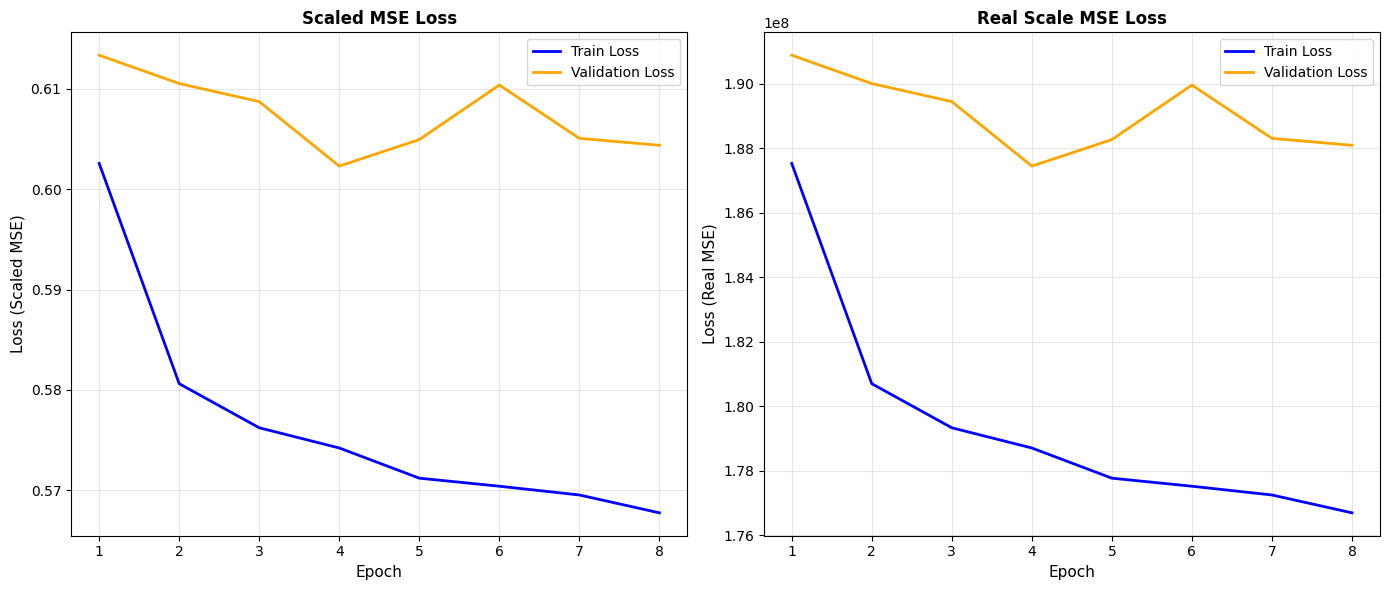

In [97]:
plot_losses(train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real)

In [98]:
print_model_parameters_summary(model)

fc1.weight: 4,736 parameters, trainable=True
fc1.bias: 128 parameters, trainable=True
fc2.weight: 8,192 parameters, trainable=True
fc2.bias: 64 parameters, trainable=True
fc3.weight: 64 parameters, trainable=True
fc3.bias: 1 parameters, trainable=True
----------------------------------------
Total Parameters: 13,185


In [99]:
model_name = 'cat_unk_bs64_sgd_lrs_no_hid128_dr20'
torch.save(model.state_dict(), MODELS_DIR + model_name + '.pth')

In [100]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    baseline_models_test_scores[model_name] = {
        'Test MSE (scaled)': test_loss_scaled_avg,
        'Test MSE (real)': test_loss_real_avg,
        'Test RMSE (real)': np.sqrt(test_loss_real_avg)
    }

#### Setting learning rate scheduler

In [101]:
set_seed()

input_dim = X_train_processed.shape[1]
hidden_size = 128
dropout_prob = 0.2

model = SimpleRegressor(input_dim, hidden_size, dropout_prob).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

target_scaler = joblib.load(PREPROCESSORS_DIR + 'target_scaler.pkl')

n_epochs = 30
patience = 4
delta = 0.001
early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True, restore_best_weights=True)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1)

# Lists to store training and validation loss
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
            y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Average losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Print epoch results
    print(f'Epoch {epoch+1}/{n_epochs}:')
    print(f'  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}')
    print(f'  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}')

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg,  model)
    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch+1}") 
        break

    # Step the learning rate scheduler
    lr_scheduler.step(valid_loss_scaled_avg)
    print(f"  Learning Rate: {optimizer.param_groups[0]['lr']:.6f}")

Epoch 1/30:
  Train - MSE: 0.5863, Real MSE: 182475936.00, Real RMSE: 13508.37
  Valid - MSE: 0.6070, Real MSE: 188897344.00, Real RMSE: 13743.99
Validation loss improved to 0.606970.
  Learning Rate: 0.001000
Epoch 2/30:
  Train - MSE: 0.5693, Real MSE: 177167184.00, Real RMSE: 13310.42
  Valid - MSE: 0.6075, Real MSE: 189058864.00, Real RMSE: 13749.87
No improvement in validation loss for 1 epoch.
  Learning Rate: 0.001000
Epoch 3/30:
  Train - MSE: 0.5671, Real MSE: 176476448.00, Real RMSE: 13284.44
  Valid - MSE: 0.6033, Real MSE: 187766896.00, Real RMSE: 13702.81
Validation loss improved to 0.603338.
  Learning Rate: 0.001000
Epoch 4/30:
  Train - MSE: 0.5657, Real MSE: 176063984.00, Real RMSE: 13268.91
  Valid - MSE: 0.6062, Real MSE: 188665696.00, Real RMSE: 13735.56
No improvement in validation loss for 1 epoch.
  Learning Rate: 0.001000
Epoch 5/30:
  Train - MSE: 0.5642, Real MSE: 175576032.00, Real RMSE: 13250.51
  Valid - MSE: 0.6052, Real MSE: 188356976.00, Real RMSE: 13724

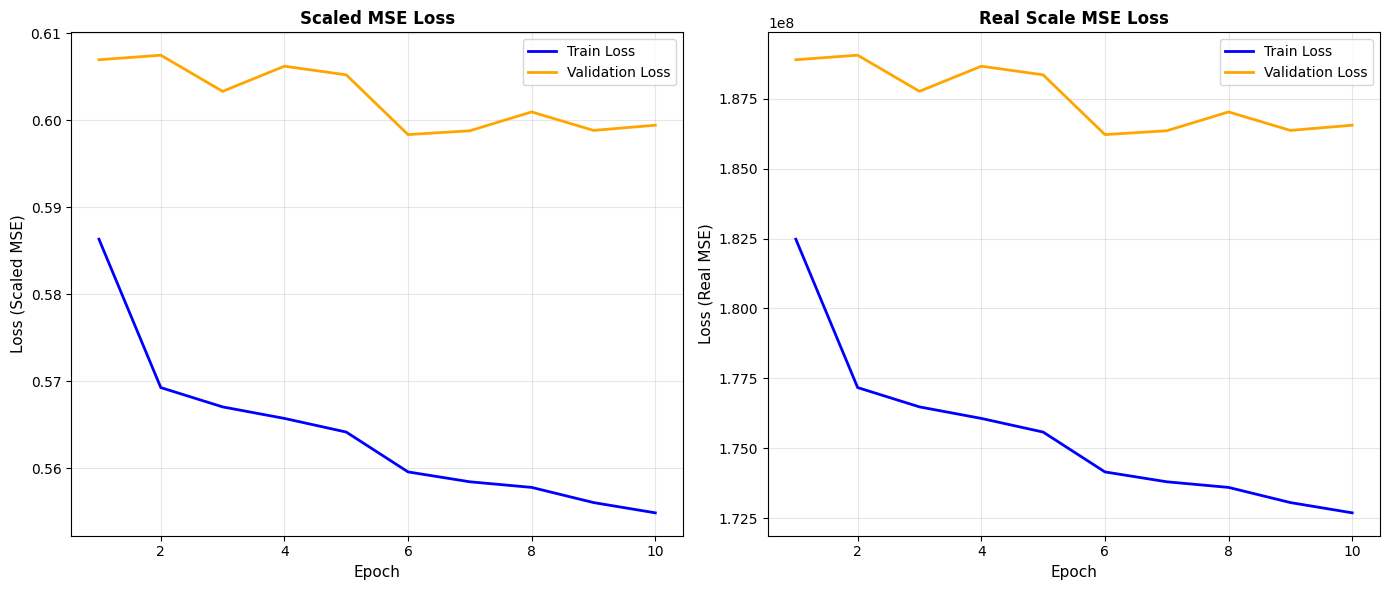

In [102]:
plot_losses(train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real)

In [103]:
print_model_parameters_summary(model)

fc1.weight: 4,736 parameters, trainable=True
fc1.bias: 128 parameters, trainable=True
fc2.weight: 8,192 parameters, trainable=True
fc2.bias: 64 parameters, trainable=True
fc3.weight: 64 parameters, trainable=True
fc3.bias: 1 parameters, trainable=True
----------------------------------------
Total Parameters: 13,185


In [104]:
model_name = 'cat_unk_bs64_adam_lrs_hid128_dr20'
torch.save(model.state_dict(), MODELS_DIR + model_name + '.pth')

In [105]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    baseline_models_test_scores[model_name] = {
        'Test MSE (scaled)': test_loss_scaled_avg,
        'Test MSE (real)': test_loss_real_avg,
        'Test RMSE (real)': np.sqrt(test_loss_real_avg)
    }

In [106]:
baseline_models_test_scores

{'cat_unk_bs32_adam_lrs_no_hid128_dr20': {'Test MSE (scaled)': 0.573598589123077,
  'Test MSE (real)': np.float32(1.785116e+08),
  'Test RMSE (real)': np.float32(13360.823)},
 'cat_mf_bs32_adam_lrs_no_hid128_dr20': {'Test MSE (scaled)': 0.5877375169451897,
  'Test MSE (real)': np.float32(1.8291189e+08),
  'Test RMSE (real)': np.float32(13524.492)},
 'cat_unk_bs64_adam_lrs_no_hid128_dr20': {'Test MSE (scaled)': 0.5651095204699705,
  'Test MSE (real)': np.float32(1.7586966e+08),
  'Test RMSE (real)': np.float32(13261.586)},
 'cat_unk_bs32_adam_lrs_no_hid64_dr20': {'Test MSE (scaled)': 0.5700162150829929,
  'Test MSE (real)': np.float32(1.7739672e+08),
  'Test RMSE (real)': np.float32(13319.036)},
 'cat_unk_bs64_sgd_lrs_no_hid128_dr20': {'Test MSE (scaled)': 0.572032193878573,
  'Test MSE (real)': np.float32(1.7802416e+08),
  'Test RMSE (real)': np.float32(13342.569)},
 'cat_unk_bs64_adam_lrs_hid128_dr20': {'Test MSE (scaled)': 0.5649678880832707,
  'Test MSE (real)': np.float32(1.7582563

### Evaluating models on the test set

/var/folders/t5/ct5bhs3j6k18hj1qyrkwmvj00000gp/T/ipykernel_71072/1889575017.py:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(models_sorted, rotation=45, ha='right')
/var/folders/t5/ct5bhs3j6k18hj1qyrkwmvj00000gp/T/ipykernel_71072/1889575017.py:28: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(models_sorted, rotation=45, ha='right')


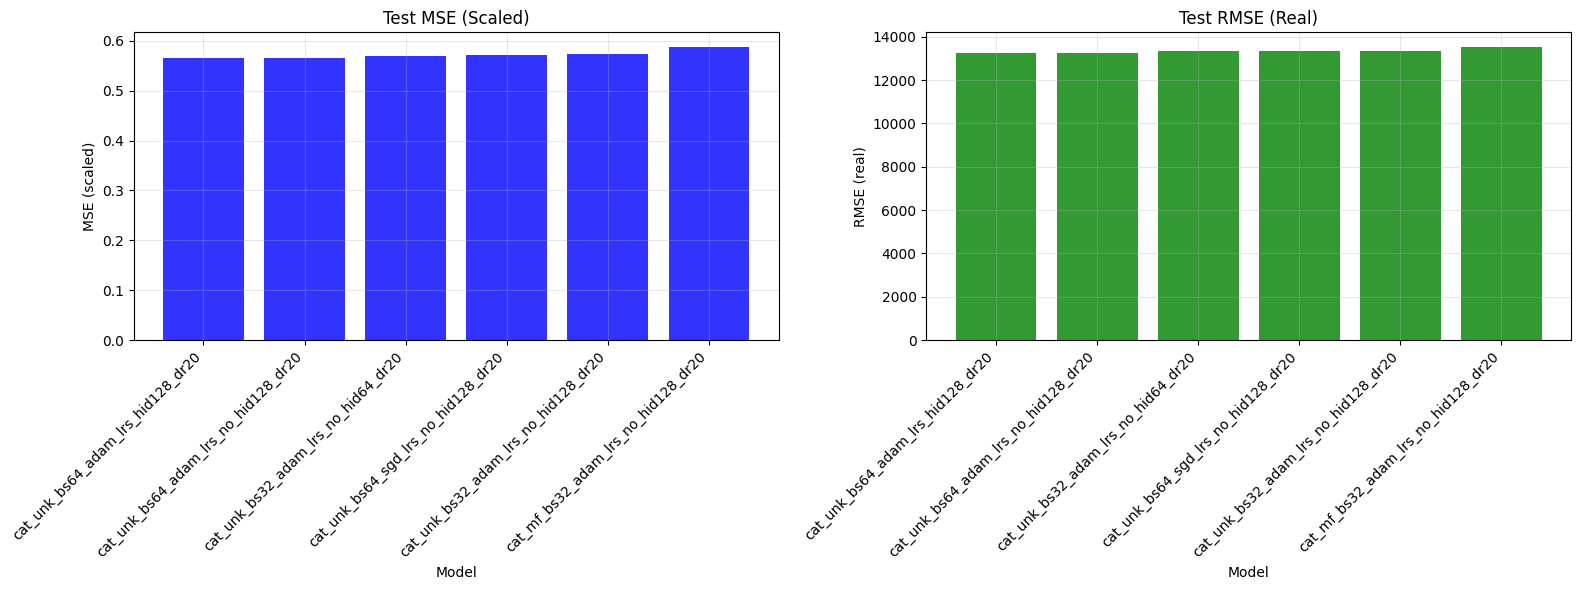

In [107]:
# Extract data
models = list(baseline_models_test_scores.keys())
mse_scaled = [baseline_models_test_scores[m]['Test MSE (scaled)'] for m in models]
mse_real = [baseline_models_test_scores[m]['Test MSE (real)'] for m in models]
rmse_real = [baseline_models_test_scores[m]['Test RMSE (real)'] for m in models]

# Sort by MSE real
sorted_indices = np.argsort(mse_real)
models_sorted = [models[i] for i in sorted_indices]
mse_scaled_sorted = [mse_scaled[i] for i in sorted_indices]
rmse_real_sorted = [rmse_real[i] for i in sorted_indices]

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Left: MSE (scaled only)
ax1.bar(models_sorted, mse_scaled_sorted, alpha=0.8, color='blue')
ax1.set_xlabel('Model')
ax1.set_ylabel('MSE (scaled)')
ax1.set_xticklabels(models_sorted, rotation=45, ha='right')
ax1.set_title('Test MSE (Scaled)')
ax1.grid(alpha=0.3)

# Right: RMSE (real)
ax2.bar(models_sorted, rmse_real_sorted, alpha=0.8, color='green')
ax2.set_xlabel('Model')
ax2.set_ylabel('RMSE (real)')
ax2.set_xticklabels(models_sorted, rotation=45, ha='right')
ax2.set_title('Test RMSE (Real)')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

We can see that tuning hyperparameters for such a simple model with a few categorical features does not bring significant improvements.

## Phase 2: Incorporating text data

Text data is present in the **`Title`** and **`FullDescription`** columns.  
We need to preprocess these texts and convert them into a numerical format.

### What we may try to extract from text data and what to do with it:
- **Numbers** — e.g., “5 years experience”, “3+ years”, “2 years of experience”
- **Programming languages** — e.g., “Python”, “Java”, “C++”, “JavaScript”
- **Job seniority levels** — e.g., “Junior”, “Manager”, “Senior”, “Lead”
- **Special characters** — e.g., “+” (C++), “#” (C#), “.” (.NET)
- **Convert all text to lowercase**

### What is not important and will be removed:
- URLs  
- Email addresses  
- Asterisks (`***`) used for salary masking  
- Excessive whitespaces  

### To consider carefully:
- **Stop words** — Usually removed, but in job descriptions they may be meaningful (e.g., “not”, “without”, “no experience required”).  
- **Lemmatization / Stemming** — May alter words with different meanings (e.g., “developer” vs “development”), so should be applied with caution.


When we clean our text data we need to tokenize it.  The text needs to be broken down into individual words or sub-words, called tokens. This is a crucial step in NLP as it allows us to analyze the text at a granular level.

Next step may be vectorization. This is the process of converting text data into numerical format that can be fed into machine learning models. There are several techniques for vectorization, including e.g.:

- TF-IDF (Term Frequency-Inverse Document Frequency)
- Word Embeddings (e.g., Word2Vec, GloVe)

At start I will try TF-IDF as it is simple and effective for many NLP tasks.

We may also try to include 'SourceName' column as it may contain some useful information about the job offer. It will be also target encoded as it has a large number of unique values.

In [108]:
df.sample(5)

,Title,FullDescription,LocationRaw,LocationNormalized,ContractType,ContractTime,Company,Category,SalaryRaw,SalaryNormalized,SourceName
30390,Business Account Manager,Business Account Manager Plumbing Heating Pro...,South West,South West London,NaN,permanent,BMS Sales Specialists,Sales Jobs,"22000 - 25000 per annum + Car,Mobile,Pension,L...",23500,totaljobs.com
108709,Staff Nurse RGN/RMN Newtown Abbey Nights Ne...,Job Title; Staff Nurse RGN/RMN – NightsLocatio...,Newtownabbey,Newtownabbey,full_time,NaN,Regional Recruitment Services,Healthcare & Nursing Jobs,12.00/Hour,23040,staffnurse.com
13924,Community Fundraising Manager,This dynamic international development charity...,London,London,full_time,permanent,TPP Not for Profit,Charity & Voluntary Jobs,33300 - 36400 per annum,34850,Third Sector Jobs
154606,Conveyancing Executive,Large regional law firm require a residential ...,Hampshire,Hampshire,full_time,permanent,PTP Consulting,Legal Jobs,"From 18,000 to 27,000 per year",22500,TotallyLegal
172891,Investment Compliance Analyst,This individual will work closely with the bus...,London South East,South East London,NaN,permanent,Michael Page Financial Services,Accounting & Finance Jobs,50000 to 60000 per annum,55000,totaljobs.com


In [109]:
# check wheter some descriptions have html tags
df['FullDescription'].str.contains('<.*?>').sum()
# no we don't have any html tags

np.int64(0)

### Custom Text Preprocessor and Tf-Idf Vectorizer

#### Building Text Preprocessor

In [6]:
class TextPreprocessor(BaseEstimator, TransformerMixin):
    """
    A custom scikit-learn compatible transformer for cleaning and preprocessing text data.

    This class handles various text cleaning steps such as converting to lowercase, 
    removing URLs, emails, HTML tags, and punctuation. It also includes optional steps 
    for removing numbers, stopwords, and lemmatization. It is designed to work with 
    pandas DataFrames containing 'Title' and 'FullDescription' columns.
    """
    def __init__(self,
                 lowercase: bool = True,
                 remove_punctuation: bool = False,
                 remove_stopwords: bool = False,
                 remove_numbers: bool = False,
                 lemmatize: bool = False):
        """
        Initializes the TextPreprocessor with various preprocessing options.

        Args:
            lowercase: If True, converts all text to lowercase. Defaults to True.
            remove_punctuation: If True, removes all punctuation from the text. 
                                Defaults to False.
            remove_stopwords: If True, removes common English stopwords. Defaults to False.
            remove_numbers: If True, removes all numbers from the text. Defaults to False.
            lemmatize: If True, reduces words to their base or root form. Defaults to False.
        """
        self.lowercase = lowercase
        self.remove_punctuation = remove_punctuation
        self.remove_stopwords = remove_stopwords
        self.remove_numbers = remove_numbers
        self.lemmatize = lemmatize

        if self.remove_stopwords:
            self.stop_words = set(stopwords.words('english'))
        if self.lemmatize:
            self.lemmatizer = WordNetLemmatizer()

    def clean_text(self, text: str) -> str:
        """
        Cleans a single text string based on the initialized parameters.

        Args:
            text: The text string to be cleaned.

        Returns:
            The cleaned text string.
        """
        if pd.isnull(text) or text.strip() == '':
            return ''
        
        text = str(text)
        
        if self.lowercase:
            text = text.lower()

        # Remove URLs
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

        # Remove email addresses
        text = re.sub(r'\S+@\S+', '', text)

        # Remove HTML tags (just in case)
        text = re.sub(r'<.*?>', '', text)

        # Remove multiple asterisks (e.g., *****)
        text = re.sub(r'\*{2,}', ' ', text)

        # Remove extra whitespaces
        text = re.sub(r'\s+', ' ', text).strip()

        # Remove special characters
        text = re.sub(r'[^\s\w+#.+-]', '', text)

        # Remove numbers - optional
        if self.remove_numbers:
            text = re.sub(r'\d+', '', text)

        # Remove punctuation - optional
        if self.remove_punctuation:
            text = text.translate(str.maketrans('', '', string.punctuation))

        # Tokenization
        tokens = text.split()

        # Remove stopwords - optional
        if self.remove_stopwords:
            tokens = [word for word in tokens if word not in self.stop_words]

        # Lemmatization - optional
        if self.lemmatize:
            tokens = [self.lemmatizer.lemmatize(word) for word in tokens]

        # Join tokens back into a single string
        text = ' '.join(tokens)

        return text.strip()
        
    
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_copy = X.copy()

        if 'Title' in X_copy.columns:
            X_copy['Title'] = X_copy['Title'].apply(self.clean_text)

        if 'FullDescription' in X_copy.columns:
            X_copy['FullDescription'] = X_copy['FullDescription'].apply(self.clean_text)

        return X_copy
    
    def fit_transform(self, X: pd.DataFrame, y: Optional[pd.Series] = None) -> pd.DataFrame:
        return self.transform(X)

In [111]:
tp = TextPreprocessor()
sample = df['FullDescription'].sample(1).values[0]
print("Original:")
print(sample)
print("\nCleaned:")
cleaned = tp.clean_text(sample)
print(cleaned)


Original:
Part Time Studio Team Member Required We are looking for people to join our team who must be confident, enthusiastic, love a fast paced environment, enjoy working with children, appreciate the value of portraits and believe in delivering excellent customer service. Job Description In this target driven role, you will be responsible for supporting the Studio Manager in Promoting, Telesales, Photography, Presenting Selling Portraits to clients in a busy retail environment. You will participate in a variety of promotional activities including High Street Promoting and organised outside events. You would then make telephone contact with interested customers to arrange appointments. During appointments, you will provide customers with a fantastic experience through our photography, editing and viewing sessions. Essential Requirements Must have a proven record in Sales or be confident in Promoting a product. Must be Confident working towards targets. Must be a strong team player. C

#### Building Tf-Idf Transformer

In [7]:
class TfidfTransformer(BaseEstimator, TransformerMixin):
    """
    A custom scikit-learn compatible transformer for applying TF-IDF vectorization
    and optional Singular Value Decomposition (SVD) for dimensionality reduction.

    This transformer is designed to process a specific text column in a pandas DataFrame,
    convert it into a TF-IDF matrix, and can optionally reduce its dimensions using SVD.
    """
    def __init__(self,
                 text_column: str = 'Title',
                 max_features: int = 50,
                 use_svd: bool = False,
                 n_components: int = 10,
                 stop_words: Optional[List[str] | str] = None):
        """
        Initializes the TfidfTransformer.

        Args:
            text_column: The name of the DataFrame column containing the text data.
                         Defaults to 'Title'.
            max_features: The maximum number of features (tokens) to be considered by
                          the TfidfVectorizer. Defaults to 50.
            use_svd: If True, applies TruncatedSVD for dimensionality reduction.
                     Defaults to False.
            n_components: The number of components to keep after SVD. This is only
                          used if `use_svd` is True. Defaults to 10.
            stop_words: A list of stop words or a string indicating a language
                        (e.g., 'english'). Passed directly to TfidfVectorizer.
                        Defaults to None.
        """
        self.text_column = text_column
        self.max_features = max_features
        self.use_svd = use_svd
        self.n_components = n_components
        self.stop_words = stop_words

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        # Underscore suffix for fitted attributes (sklearn convention)
        self.vectorizer_ = TfidfVectorizer(
            max_features=self.max_features,
            stop_words=self.stop_words,
            ngram_range=(1, 2),
            min_df=5
        )
        
        text_data = X[self.text_column].fillna('')
        tfidf_matrix = self.vectorizer_.fit_transform(text_data)
        
        if self.use_svd:
            self.svd_ = TruncatedSVD(n_components=self.n_components, random_state=RANDOM_SEED)
            self.svd_.fit(tfidf_matrix)
        
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame | np.ndarray:
        # Check for fitted attribute
        if not hasattr(self, 'vectorizer_'):
            raise RuntimeError("This TfidfTransformer instance is not fitted yet. Call 'fit' first.")
        
        text_data = X[self.text_column].fillna('')
        tfidf_matrix = self.vectorizer_.transform(text_data)
        
        if self.use_svd:
            tfidf_matrix = self.svd_.transform(tfidf_matrix)
            return tfidf_matrix  # Already a numpy array
        else:
            return tfidf_matrix.toarray()

#### Complete preprocessing pipeline

In [113]:
df = pd.read_csv(FILEPATH)
X = df[['Title', 'FullDescription', 'Category', 'Company', 'LocationNormalized', 'ContractType', 'ContractTime', 'SourceName']]
X['Title'] = X['Title'].fillna('Quality Improvement Manager') # based on EDA
y = df['SalaryNormalized']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=RANDOM_SEED)
print(f"Train set has {len(X_train)} entries")
print(f"Validation set has {len(X_valid)} entries")
print(f"Test set has {len(X_test)} entries")

Train set has 195814 entries
Validation set has 24477 entries
Test set has 24477 entries


/var/folders/t5/ct5bhs3j6k18hj1qyrkwmvj00000gp/T/ipykernel_71072/4235492946.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Title'] = X['Title'].fillna('Quality Improvement Manager') # based on EDA


In [114]:
text_columns = ['Title', 'FullDescription']
categorical_columns = ['Category', 'ContractType', 'ContractTime']
high_cardinality_columns = ['Company', 'LocationNormalized', 'SourceName']

one_hot_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),  
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

target_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')), 
    ('target_enc', TargetEncoder()),
    ('scaler', StandardScaler())
])

title_pipeline = make_pipeline(
    TextPreprocessor(lowercase=True, remove_punctuation=False, 
                    remove_stopwords=False, remove_numbers=False, lemmatize=False),
    TfidfTransformer(text_column='Title', max_features=50, use_svd=False, stop_words='english')
)

desc_pipeline = make_pipeline(
    TextPreprocessor(lowercase=True, remove_punctuation=False, 
                    remove_stopwords=False, remove_numbers=False, lemmatize=False),
    TfidfTransformer(text_column='FullDescription', max_features=800, use_svd=False, stop_words='english')
)

preprocessor_with_text = ColumnTransformer([
    ('title_tfidf', title_pipeline, ['Title']),
    ('desc_tfidf', desc_pipeline, ['FullDescription']),
    ('onehot', one_hot_pipeline, categorical_columns),
    ('target_scaled', target_pipeline, high_cardinality_columns)
])


target_scaler = StandardScaler() 
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()  
y_valid_scaled = target_scaler.transform(y_valid.values.reshape(-1, 1)).ravel()      
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()      

X_train_processed = preprocessor_with_text.fit_transform(X_train, y_train)  
X_valid_processed = preprocessor_with_text.transform(X_valid)               
X_test_processed = preprocessor_with_text.transform(X_test)                 

train_dataset = SalaryDataset(X_train_processed, y_train_scaled)
valid_dataset = SalaryDataset(X_valid_processed, y_valid_scaled)
test_dataset = SalaryDataset(X_test_processed, y_test_scaled)

# Save the preprocessor and target scaler for future use
joblib.dump(preprocessor_with_text, PREPROCESSORS_DIR + 'preprocessor_with_text.pkl')
joblib.dump(target_scaler, PREPROCESSORS_DIR + 'target_scaler.pkl')

['preprocessors/target_scaler.pkl']

#### Create dataloaders

In [115]:
batch_size = 64
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)

In [116]:
for X_batch, y_batch in train_loader:
    print(f"Batch X shape: {X_batch.shape}")
    print(f"Batch y shape: {y_batch.shape}")
    print(X_batch)
    print(y_batch)
    break  # Just to check the first batch

Batch X shape: torch.Size([64, 888])
Batch y shape: torch.Size([64])
tensor([[ 0.0000,  0.0000,  0.0000,  ..., -1.9432, -1.1129, -0.2698],
        [ 0.0000,  0.0000,  0.0000,  ...,  1.2685,  1.9749,  0.4062],
        [ 0.0000,  0.0000,  0.0000,  ..., -1.6540, -0.0574, -1.0886],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.3101, -0.0574,  0.4062],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.5112,  1.4822,  1.5470],
        [ 0.0000,  0.0000,  0.6941,  ...,  0.7289, -0.1110,  0.4062]])
tensor([-0.7152,  1.7506, -0.9420,  2.0340, -0.9703,  1.8073, -0.3559, -0.6302,
        -0.4602, -0.8570, -1.0807, -0.0917, -0.8003, -0.6869, -0.5168, -0.2334,
         3.1677, -1.1971,  0.7586, -1.5372,  0.2201, -0.8286, -0.1382,  0.1917,
        -0.9000, -0.7719, -0.7177,  1.3254, -0.1926, -0.2334, -0.3080, -0.9136,
        -0.9000, -0.4885, -0.0350,  1.4671, -0.7776,  1.6089, -0.3468, -0.5735,
         0.0500,  2.1757, -0.2051,  1.4671,  0.0500, -0.4602,  0.4752,  0.1917,
         0.9003, 

#### Training the model with text data

In [117]:
set_seed()

input_dim = X_train_processed.shape[1]
hidden_size = 128
dropout_prob = 0.3 #higher to prevent overfitting

model = SimpleRegressor(input_dim, hidden_size, dropout_prob).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

target_scaler = joblib.load(PREPROCESSORS_DIR + 'target_scaler.pkl')

n_epochs = 25
patience = 3
delta = 0.001
early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True, restore_best_weights=True)

# Lists to store training and validation loss
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
            y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Average losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Print epoch results
    print(f'Epoch {epoch+1}/{n_epochs}:')
    print(f'  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}')
    print(f'  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}')

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg,  model)
    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch+1}") 
        break

Epoch 1/25:
  Train - MSE: 0.3827, Real MSE: 119090856.00, Real RMSE: 10912.88
  Valid - MSE: 0.3395, Real MSE: 105669160.00, Real RMSE: 10279.55
Validation loss improved to 0.339539.
Epoch 2/25:
  Train - MSE: 0.3275, Real MSE: 101926920.00, Real RMSE: 10095.89
  Valid - MSE: 0.3177, Real MSE: 98883344.00, Real RMSE: 9944.01
Validation loss improved to 0.317735.
Epoch 3/25:
  Train - MSE: 0.3011, Real MSE: 93699976.00, Real RMSE: 9679.88
  Valid - MSE: 0.3045, Real MSE: 94754136.00, Real RMSE: 9734.17
Validation loss improved to 0.304467.
Epoch 4/25:
  Train - MSE: 0.2806, Real MSE: 87318984.00, Real RMSE: 9344.46
  Valid - MSE: 0.3020, Real MSE: 93980024.00, Real RMSE: 9694.33
Validation loss improved to 0.301979.
Epoch 5/25:
  Train - MSE: 0.2657, Real MSE: 82691648.00, Real RMSE: 9093.50
  Valid - MSE: 0.2968, Real MSE: 92365688.00, Real RMSE: 9610.71
Validation loss improved to 0.296792.
Epoch 6/25:
  Train - MSE: 0.2528, Real MSE: 78660072.00, Real RMSE: 8869.05
  Valid - MSE: 0.

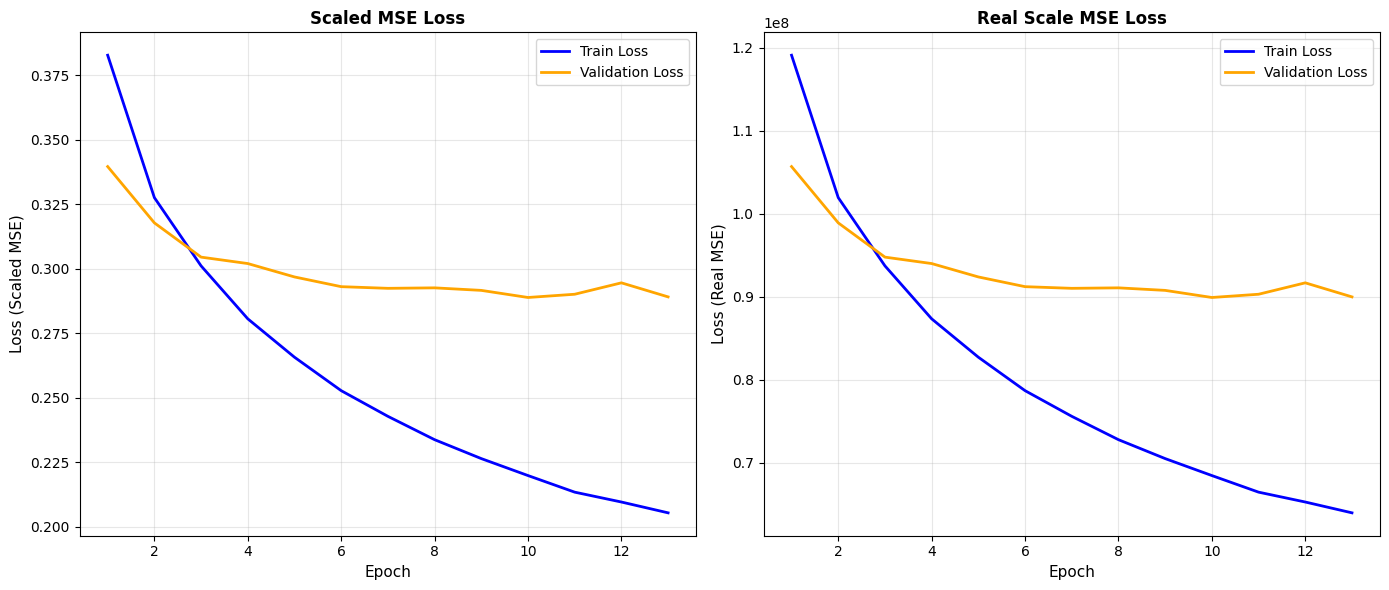

In [118]:
plot_losses(train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real)

In [119]:
print_model_parameters_summary(model)

fc1.weight: 113,664 parameters, trainable=True
fc1.bias: 128 parameters, trainable=True
fc2.weight: 8,192 parameters, trainable=True
fc2.bias: 64 parameters, trainable=True
fc3.weight: 64 parameters, trainable=True
fc3.bias: 1 parameters, trainable=True
----------------------------------------
Total Parameters: 122,113


#### Save the model

In [120]:
model_name = 'tfidf_800_50_sr_unk_bs64_adam_lrs_no_hid128_dr30'
torch.save(model.state_dict(), MODELS_DIR + model_name + '.pth')

#### Evaluate on the test set for later comparison

In [121]:
fulldata_best_models = dict()  # To store test scores of the best models

In [122]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)
    
    fulldata_best_models[model_name] = {
        'Test MSE (scaled)': test_loss_scaled_avg,
        'Test MSE (real)': test_loss_real_avg,
        'Test RMSE (real)': np.sqrt(test_loss_real_avg)
    }

#### Removing redundancy

**TextPreprocessor does:**
- Lowercase 
- Remove URLs, emails 
- Remove special chars
- Remove stopwords (optional)

**TfidfVectorizer ALSO does**
- Lowercase (by default)
- Remove stopwords (optional)
- Tokenization
- Filters by min_df

So if we know that despite TextPreprocessor we will also use TfidfVectorizer, we can simplify TextPreprocessor to only remove URLs and emails.

In [10]:
class MinimalTextPreprocessor(BaseEstimator, TransformerMixin):
    """
    A custom scikit-learn compatible transformer for minimal text cleaning.

    This class performs a streamlined set of text cleaning operations that are not
    typically handled by TF-IDF vectorizers, such as removing URLs, email addresses,
    HTML tags, and multiple asterisks. It is designed to work with pandas DataFrames
    containing 'Title' and 'FullDescription' columns.
    """
    
    def clean_text(self, text: str) -> str:
        """
        Cleans a single text string by removing specific patterns.

        Args:
            text: The text string to be cleaned.

        Returns:
            The cleaned text string.
        """
        if pd.isnull(text):
            return ''
        text = str(text).strip()
        if text == '':
            return ''
        
        # Remove URLs, emails, HTML, asterisks
        text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
        text = re.sub(r'\S+@\S+', '', text)
        text = re.sub(r'<.*?>', '', text)
        text = re.sub(r'\*{2,}', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        
        return text
    
    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        return self
    
    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        X_copy = X.copy()
        if 'Title' in X_copy.columns:
            X_copy['Title'] = X_copy['Title'].apply(self.clean_text)
        if 'FullDescription' in X_copy.columns:
            X_copy['FullDescription'] = X_copy['FullDescription'].apply(self.clean_text)
        return X_copy

In [124]:
text_columns = ['Title', 'FullDescription']
categorical_columns = ['Category', 'ContractType', 'ContractTime']
high_cardinality_columns = ['Company', 'LocationNormalized', 'SourceName']

# Shared text preprocessor 
shared_text_prep = MinimalTextPreprocessor()

# Title pipeline
title_pipeline = make_pipeline(
    TfidfTransformer(text_column='Title', max_features=50)
)

# Description pipeline
desc_pipeline = make_pipeline(
    TfidfTransformer(text_column='FullDescription', max_features=800)
)

# Categorical pipeline
one_hot_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),  
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

# High cardinality pipeline
target_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')), 
    ('target_enc', TargetEncoder()),
    ('scaler', StandardScaler())
])

# Clean text first (once for all text columns)
X_train_clean = shared_text_prep.fit_transform(X_train)
X_valid_clean = shared_text_prep.transform(X_valid)
X_test_clean = shared_text_prep.transform(X_test)

# Feature extraction
preprocessor = ColumnTransformer([
    ('title_tfidf', title_pipeline, ['Title']),
    ('desc_tfidf', desc_pipeline, ['FullDescription']),
    ('onehot', one_hot_pipeline, categorical_columns),
    ('target_scaled', target_pipeline, high_cardinality_columns)
])

# Fit and transform
X_train_processed = preprocessor.fit_transform(X_train_clean, y_train)
X_valid_processed = preprocessor.transform(X_valid_clean)
X_test_processed = preprocessor.transform(X_test_clean)

# Scale target
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_valid_scaled = target_scaler.transform(y_valid.values.reshape(-1, 1)).ravel()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

# Create datasets
train_dataset = SalaryDataset(X_train_processed, y_train_scaled)
valid_dataset = SalaryDataset(X_valid_processed, y_valid_scaled)
test_dataset = SalaryDataset(X_test_processed, y_test_scaled)

# Save for later
joblib.dump(shared_text_prep, PREPROCESSORS_DIR + 'text_preprocessor.pkl')
joblib.dump(preprocessor, PREPROCESSORS_DIR + 'preprocessor.pkl')
joblib.dump(target_scaler, PREPROCESSORS_DIR + 'target_scaler.pkl')

print(f"Final feature shape: {X_train_processed.shape}")

Final feature shape: (195814, 888)


- Now we can just repeat the training loop as before
- We may try to experiment with:
    - Different optimizers
    - Different learning rates (for example using learning rate schedulers)
    - Different batch sizes
    - Using stop words in TfidfVectorizer
    - Using SVD to reduce dimensionality of text features
    - Number of features in TfidfVectorizer

#### Building more complex model with text data

Now I will add batch normalization and **try** define learning rate scheduler.

In [11]:
import torch
import torch.nn as nn

class SimpleRegressorWithNormalization(nn.Module):
    def __init__(self, input_dim: int, hidden_size: int = 64, dropout_prob: float = 0.3):
        """
        A simple feed-forward neural network for regression with Batch Normalization.

        This model includes Batch Normalization layers after each linear layer and before the
        activation function, which helps to stabilize and accelerate training.

        Args:
            input_dim: The number of features in the input data.
            hidden_size: The number of neurons in the first hidden layer. The second
                         hidden layer will have half this number. Defaults to 64.
            dropout_prob: The dropout probability for the dropout layers. Defaults to 0.3.
        """
        super(SimpleRegressorWithNormalization, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [126]:
# Number of parameters
input_dim = X_train_processed.shape[1]
print(f"Input dimension: {input_dim}")
model = SimpleRegressorWithNormalization(input_dim, hidden_size=128, dropout_prob=0.3)
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} parameters, trainable={param.requires_grad}")

print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

Input dimension: 888
fc1.weight: 113664 parameters, trainable=True
fc1.bias: 128 parameters, trainable=True
bn1.weight: 128 parameters, trainable=True
bn1.bias: 128 parameters, trainable=True
fc2.weight: 8192 parameters, trainable=True
fc2.bias: 64 parameters, trainable=True
bn2.weight: 64 parameters, trainable=True
bn2.bias: 64 parameters, trainable=True
fc3.weight: 64 parameters, trainable=True
fc3.bias: 1 parameters, trainable=True
Total parameters: 122497


In [127]:
batch_size = 64
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)

In [128]:
set_seed()

input_dim = X_train_processed.shape[1]
hidden_size = 128
dropout_prob = 0.3
patience_scheduler = 2
lr = 0.001

model = SimpleRegressorWithNormalization(input_dim, hidden_size, dropout_prob).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
### scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience_scheduler)

target_scaler = joblib.load(PREPROCESSORS_DIR + 'target_scaler.pkl')

n_epochs = 25
patience = 3
delta = 0.001
early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True, restore_best_weights=True)

# Lists to store training and validation loss
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
            y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Average losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Step the scheduler
    ### scheduler.step(valid_loss_scaled_avg)

    # Print epoch results
    print(f'Epoch {epoch+1}/{n_epochs}:')
    print(f'  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}')
    print(f'  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}')

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg,  model)
    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch+1}") 
        break

Epoch 1/25:
  Train - MSE: 0.4150, Real MSE: 129165368.00, Real RMSE: 11365.09
  Valid - MSE: 0.3589, Real MSE: 111700032.00, Real RMSE: 10568.82
Validation loss improved to 0.358918.
Epoch 2/25:
  Train - MSE: 0.3679, Real MSE: 114508488.00, Real RMSE: 10700.86
  Valid - MSE: 0.3408, Real MSE: 106061544.00, Real RMSE: 10298.62
Validation loss improved to 0.340800.
Epoch 3/25:
  Train - MSE: 0.3462, Real MSE: 107746152.00, Real RMSE: 10380.08
  Valid - MSE: 0.3272, Real MSE: 101832208.00, Real RMSE: 10091.19
Validation loss improved to 0.327210.
Epoch 4/25:
  Train - MSE: 0.3315, Real MSE: 103170952.00, Real RMSE: 10157.31
  Valid - MSE: 0.3228, Real MSE: 100448072.00, Real RMSE: 10022.38
Validation loss improved to 0.322763.
Epoch 5/25:
  Train - MSE: 0.3187, Real MSE: 99181416.00, Real RMSE: 9958.99
  Valid - MSE: 0.3154, Real MSE: 98141256.00, Real RMSE: 9906.63
Validation loss improved to 0.315350.
Epoch 6/25:
  Train - MSE: 0.3087, Real MSE: 96064736.00, Real RMSE: 9801.26
  Valid

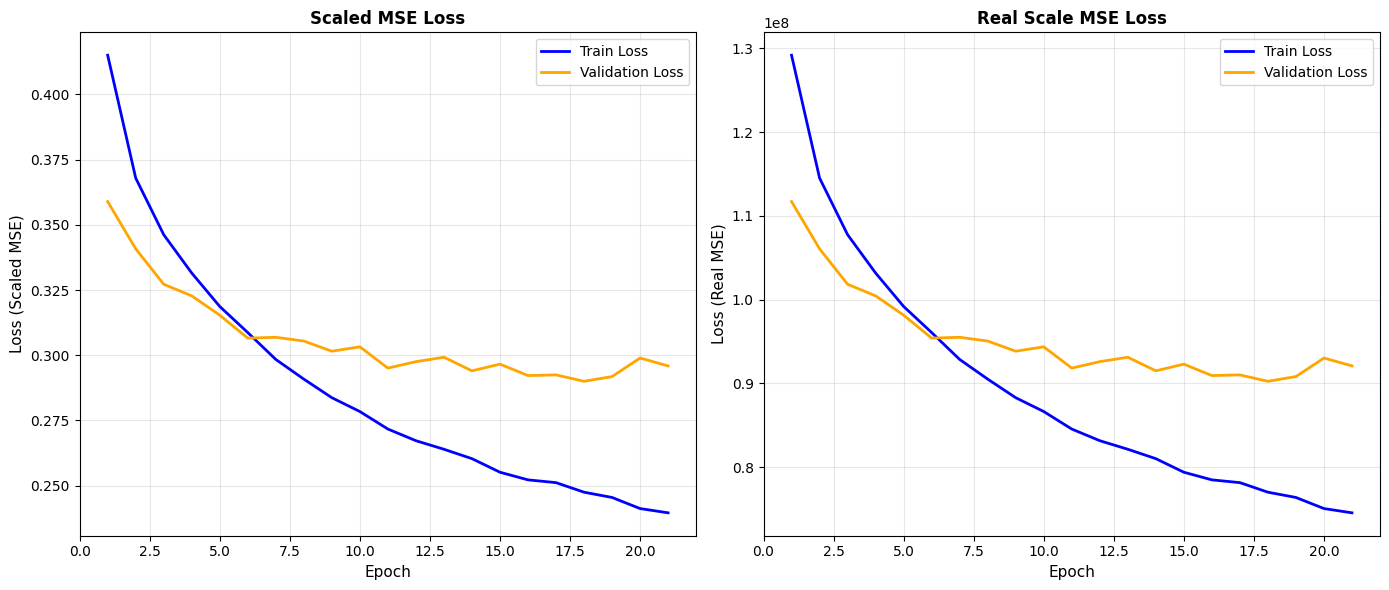

In [129]:
plot_losses(train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real)

In [130]:
print_model_parameters_summary(model)

fc1.weight: 113,664 parameters, trainable=True
fc1.bias: 128 parameters, trainable=True
bn1.weight: 128 parameters, trainable=True
bn1.bias: 128 parameters, trainable=True
fc2.weight: 8,192 parameters, trainable=True
fc2.bias: 64 parameters, trainable=True
bn2.weight: 64 parameters, trainable=True
bn2.bias: 64 parameters, trainable=True
fc3.weight: 64 parameters, trainable=True
fc3.bias: 1 parameters, trainable=True
----------------------------------------
Total Parameters: 122,497


In [131]:
model_name = 'tfidf_800_50_srbn_unk_bs64_adam_lrs_no_hid128_dr30'
torch.save(model.state_dict(), MODELS_DIR + model_name + '.pth')

In [132]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    fulldata_best_models[model_name] = {
        'Test MSE (scaled)': test_loss_scaled_avg,
        'Test MSE (real)': test_loss_real_avg,
        'Test RMSE (real)': np.sqrt(test_loss_real_avg)
    }

### Using Pretrained Embeddings

Firstly I will try with sentence-transformers library.

How to use it? - Code from the documentation:

In [133]:
# 1. Load a pretrained Sentence Transformer model
model = SentenceTransformer("all-MiniLM-L6-v2")

# The sentences to encode
sentences = [
    "The weather is lovely today.",
    "It's so sunny outside!",
    "He drove to the stadium.",
]

# 2. Calculate embeddings by calling model.encode()
embeddings = model.encode(sentences)
print(embeddings.shape)
# [3, 384]

# 3. Calculate the embedding similarities
similarities = model.similarity(embeddings, embeddings)
print(similarities)
# tensor([[1.0000, 0.6660, 0.1046],
#         [0.6660, 1.0000, 0.1411],
#         [0.1046, 0.1411, 1.0000]])

(3, 384)
tensor([[1.0000, 0.6660, 0.1046],
        [0.6660, 1.0000, 0.1411],
        [0.1046, 0.1411, 1.0000]])


### Pipeline for using pretrained embeddings

In [12]:
class TextEmbedder(BaseEstimator, TransformerMixin):
    """
    A scikit-learn compatible transformer to generate text embeddings using a pre-trained model.

    This class leverages the `sentence-transformers` library to convert text data into
    numerical vector representations (embeddings) suitable for machine learning models.
    """
    def __init__(self, model_name: str = 'all-MiniLM-L12-v2'):
        """
        Initializes the TextEmbedder.

        Args:
            model_name: The name of the pre-trained SentenceTransformer model to use.
                        Defaults to 'all-MiniLM-L12-v2'.
        """
        self.model_name = model_name
        self.model = None

    def fit(self, X: pd.DataFrame, y: Optional[pd.Series] = None):
        # The model is pre-trained, so we just load it here.
        self.model = SentenceTransformer(self.model_name)
        return self

    def transform(self, X: pd.DataFrame) -> np.ndarray:
        # Convert input to a list of strings and handle potential NaNs.
        X = [str(x) if x is not None else '' for x in X.iloc[:, 0].tolist()]

        # Generate the embeddings.
        embeddings = self.model.encode(X, show_progress_bar=False)
        return embeddings
    
    def _check_n_features(self, X, reset):
        """Ensure compatibility with sklearn's feature validation"""
        pass

In [135]:
categorical_columns = ['Category', 'ContractType', 'ContractTime']
high_cardinality_columns = ['Company', 'LocationNormalized', 'SourceName']

one_hot_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),  
    ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
])

target_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')), 
    ('target_enc', TargetEncoder()), 
    ('scaler', StandardScaler())
])

# New embedding pipelines
title_embedding_pipeline = Pipeline([
    ('embedder', TextEmbedder())
])

desc_embedding_pipeline = Pipeline([
    ('embedder', TextEmbedder())
])

preprocessor_with_embeddings = ColumnTransformer([
    ('title_embeddings', title_embedding_pipeline, ['Title']),
    ('desc_embeddings', desc_embedding_pipeline, ['FullDescription']),
    ('onehot', one_hot_pipeline, categorical_columns),
    ('target_scaled', target_pipeline, high_cardinality_columns)
])

# Fit and transform
X_train_processed = preprocessor_with_embeddings.fit_transform(X_train, y_train)
X_valid_processed = preprocessor_with_embeddings.transform(X_valid)
X_test_processed = preprocessor_with_embeddings.transform(X_test)

# Scale target
target_scaler = StandardScaler()
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
y_valid_scaled = target_scaler.transform(y_valid.values.reshape(-1, 1)).ravel()
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()

# Create datasets
train_dataset = SalaryDataset(X_train_processed, y_train_scaled)
valid_dataset = SalaryDataset(X_valid_processed, y_valid_scaled)
test_dataset = SalaryDataset(X_test_processed, y_test_scaled)

# Save for later
joblib.dump(preprocessor_with_embeddings, PREPROCESSORS_DIR + 'preprocessor_with_embeddings.pkl')
joblib.dump(target_scaler, PREPROCESSORS_DIR + 'target_scaler.pkl')

print(f"Final feature shape: {X_train_processed.shape}")

/Users/klipiec/Desktop/Internship/projects/project2_neural_networks/venv/lib/python3.13/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/klipiec/Desktop/Internship/projects/project2_neural_networks/venv/lib/python3.13/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/klipiec/Desktop/Internship/projects/project2_neural_networks/venv/lib/python3.13/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, 

Final feature shape: (195814, 806)


### Training the simplest model with pretrained embeddings

In [ ]:
batch_size = 64
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)

In [ ]:
set_seed()

input_dim = X_train_processed.shape[1]
hidden_size = 128
dropout_prob = 0.3
patience_scheduler = 2
lr = 0.001

model = SimpleRegressor(input_dim, hidden_size, dropout_prob).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

target_scaler = joblib.load(PREPROCESSORS_DIR + 'target_scaler.pkl')

n_epochs = 25
patience = 4
delta = 0.001
early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True, restore_best_weights=True)

train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
            y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Average losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Print epoch results
    print(f'Epoch {epoch+1}/{n_epochs}:')
    print(f'  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}')
    print(f'  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}')

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg,  model)
    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch+1}") 
        break

Epoch 1/25:
  Train - MSE: 0.4235, Real MSE: 131787336.00, Real RMSE: 11479.87
  Valid - MSE: 0.3549, Real MSE: 110440128.00, Real RMSE: 10509.05
Validation loss improved to 0.354869.
Epoch 2/25:
  Train - MSE: 0.3713, Real MSE: 115540360.00, Real RMSE: 10748.97
  Valid - MSE: 0.3353, Real MSE: 104346392.00, Real RMSE: 10215.01
Validation loss improved to 0.335289.
Epoch 3/25:
  Train - MSE: 0.3512, Real MSE: 109284312.00, Real RMSE: 10453.91
  Valid - MSE: 0.3277, Real MSE: 101989032.00, Real RMSE: 10098.96
Validation loss improved to 0.327714.
Epoch 4/25:
  Train - MSE: 0.3381, Real MSE: 105220152.00, Real RMSE: 10257.69
  Valid - MSE: 0.3200, Real MSE: 99592528.00, Real RMSE: 9979.61
Validation loss improved to 0.320013.
Epoch 5/25:
  Train - MSE: 0.3269, Real MSE: 101735512.00, Real RMSE: 10086.40
  Valid - MSE: 0.3081, Real MSE: 95891344.00, Real RMSE: 9792.41
Validation loss improved to 0.308121.
Epoch 6/25:
  Train - MSE: 0.3181, Real MSE: 98985960.00, Real RMSE: 9949.17
  Valid

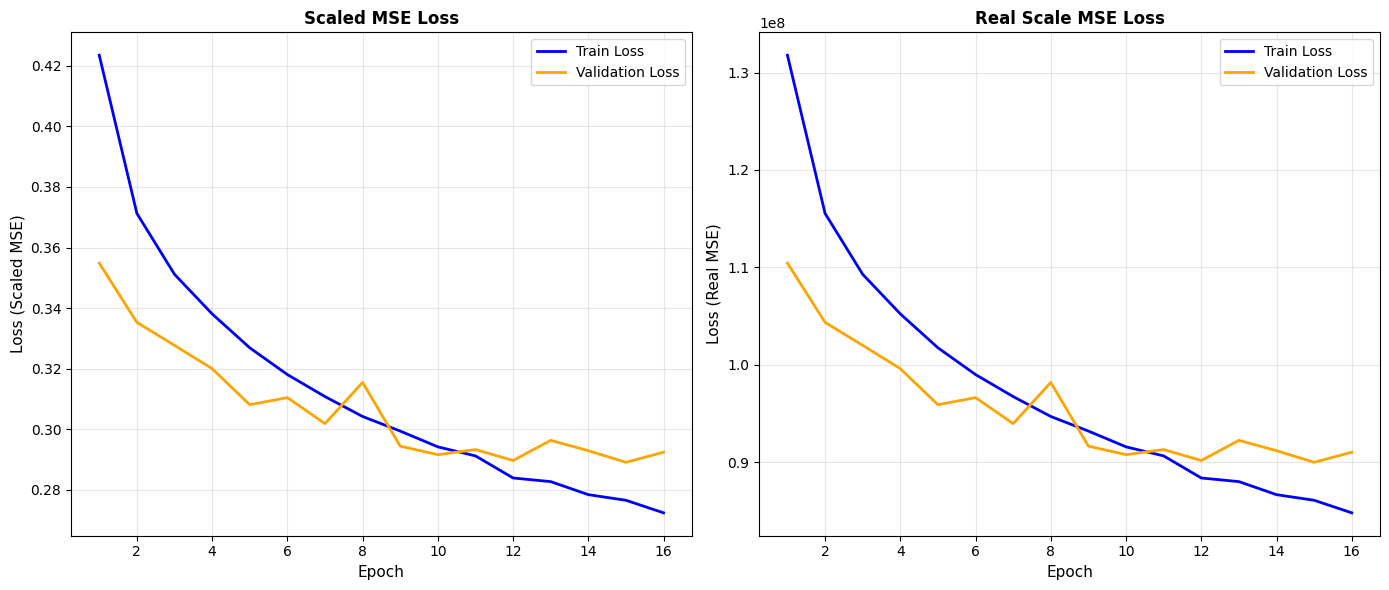

In [ ]:
plot_losses(train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real)

In [ ]:
print_model_parameters_summary(model)

fc1.weight: 103,168 parameters, trainable=True
fc1.bias: 128 parameters, trainable=True
bn1.weight: 128 parameters, trainable=True
bn1.bias: 128 parameters, trainable=True
fc2.weight: 8,192 parameters, trainable=True
fc2.bias: 64 parameters, trainable=True
bn2.weight: 64 parameters, trainable=True
bn2.bias: 64 parameters, trainable=True
fc3.weight: 64 parameters, trainable=True
fc3.bias: 1 parameters, trainable=True
----------------------------------------
Total Parameters: 112,001


In [ ]:
model_name = 'emb_srbn_unk_bs64_adam_lrs_no_hid128_dr30'
torch.save(model.state_dict(), MODELS_DIR + model_name + '.pth')

### Training simple model with batch normalization with embeddings

In [136]:
batch_size = 64
num_workers = 0

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)

In [ ]:
set_seed()

input_dim = X_train_processed.shape[1]
hidden_size = 128
dropout_prob = 0.3
patience_scheduler = 2
lr = 0.001

model = SimpleRegressorWithNormalization(input_dim, hidden_size, dropout_prob).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

target_scaler = joblib.load(PREPROCESSORS_DIR + 'target_scaler.pkl')

n_epochs = 25
patience = 4
delta = 0.001
early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True, restore_best_weights=True)

# Lists to store training and validation loss
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
            y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Average losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Print epoch results
    print(f'Epoch {epoch+1}/{n_epochs}:')
    print(f'  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}')
    print(f'  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}')

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg,  model)
    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch+1}") 
        break

Epoch 1/25:
  Train - MSE: 0.4235, Real MSE: 131787336.00, Real RMSE: 11479.87
  Valid - MSE: 0.3549, Real MSE: 110440128.00, Real RMSE: 10509.05
Validation loss improved to 0.354869.
Epoch 2/25:
  Train - MSE: 0.3713, Real MSE: 115540360.00, Real RMSE: 10748.97
  Valid - MSE: 0.3353, Real MSE: 104346392.00, Real RMSE: 10215.01
Validation loss improved to 0.335289.
Epoch 3/25:
  Train - MSE: 0.3512, Real MSE: 109284312.00, Real RMSE: 10453.91
  Valid - MSE: 0.3277, Real MSE: 101989032.00, Real RMSE: 10098.96
Validation loss improved to 0.327714.
Epoch 4/25:
  Train - MSE: 0.3381, Real MSE: 105220152.00, Real RMSE: 10257.69
  Valid - MSE: 0.3200, Real MSE: 99592528.00, Real RMSE: 9979.61
Validation loss improved to 0.320013.
Epoch 5/25:
  Train - MSE: 0.3269, Real MSE: 101735512.00, Real RMSE: 10086.40
  Valid - MSE: 0.3081, Real MSE: 95891344.00, Real RMSE: 9792.41
Validation loss improved to 0.308121.
Epoch 6/25:
  Train - MSE: 0.3181, Real MSE: 98985960.00, Real RMSE: 9949.17
  Valid

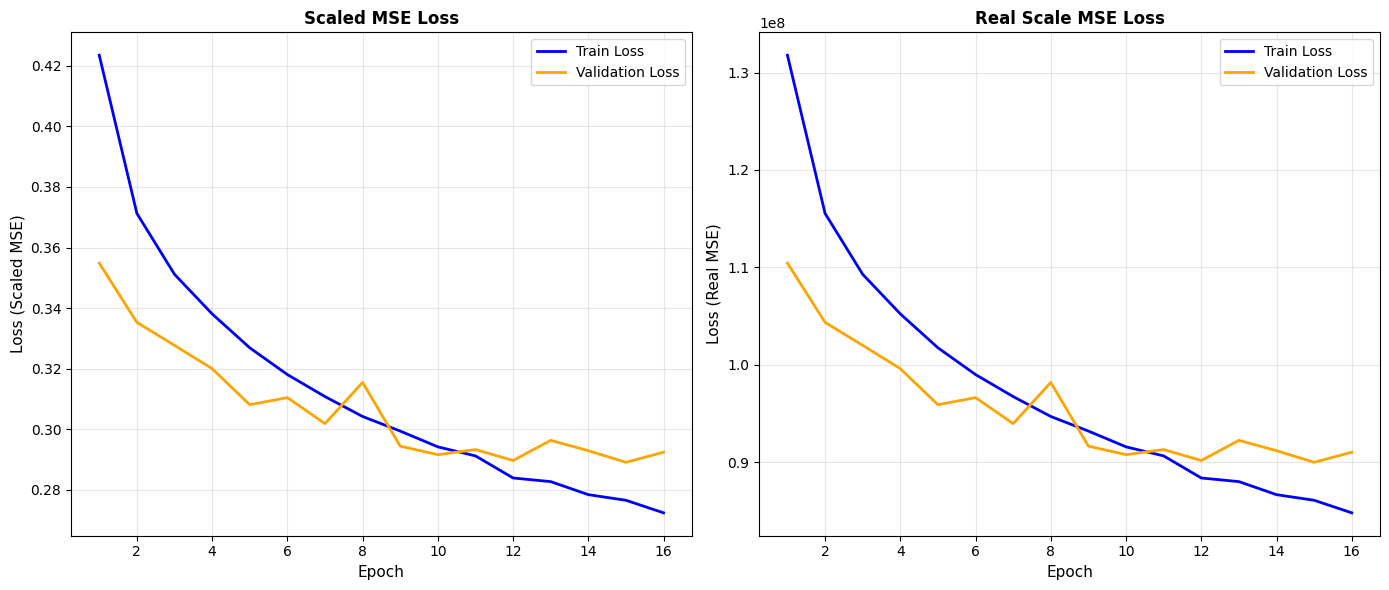

In [138]:
plot_losses(train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real)

In [139]:
print_model_parameters_summary(model)

fc1.weight: 103,168 parameters, trainable=True
fc1.bias: 128 parameters, trainable=True
bn1.weight: 128 parameters, trainable=True
bn1.bias: 128 parameters, trainable=True
fc2.weight: 8,192 parameters, trainable=True
fc2.bias: 64 parameters, trainable=True
bn2.weight: 64 parameters, trainable=True
bn2.bias: 64 parameters, trainable=True
fc3.weight: 64 parameters, trainable=True
fc3.bias: 1 parameters, trainable=True
----------------------------------------
Total Parameters: 112,001


In [140]:
model_name = 'emb_srbn_unk_bs64_adam_lrs_no_hid128_dr30'
torch.save(model.state_dict(), MODELS_DIR + model_name + '.pth')

In [141]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    fulldata_best_models[model_name] = {
        'Test MSE (scaled)': test_loss_scaled_avg,
        'Test MSE (real)': test_loss_real_avg,
        'Test RMSE (real)': np.sqrt(test_loss_real_avg)
    }

### Building deeper model for embeddings and tabular data

I will add one more layer, more neurons and try with batch normalization before and after activation functions.

In [13]:
class IntegratedNN(nn.Module):
    def __init__(self, input_dim: int, hidden_size: int = 256, dropout_prob: float = 0.3, batch_norm_before_activation: bool = True):
        """
        An integrated feed-forward neural network with configurable batch normalization placement.

        This model is a multi-layered perceptron designed for regression, featuring
        batch normalization and dropout for improved training stability and generalization.
        The order of batch normalization and activation can be specified.

        Args:
            input_dim: The number of input features.
            hidden_size: The number of neurons in the first hidden layer. Subsequent
                         layers will have a decreasing number of neurons. Defaults to 256.
            dropout_prob: The dropout probability applied after each activation. Defaults to 0.3.
            batch_norm_before_activation: If True, batch normalization is applied before
                                          the ReLU activation. If False, it is applied after.
                                          Defaults to True.
        """
        super(IntegratedNN, self).__init__()
        self.batch_norm_before_activation = batch_norm_before_activation
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.bn1 = nn.BatchNorm1d(hidden_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)
        self.bn2 = nn.BatchNorm1d(hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, hidden_size // 2 // 2)
        self.bn3 = nn.BatchNorm1d(hidden_size // 2 // 2)
        self.final_dropout = nn.Dropout(p=min(0.2, dropout_prob))
        self.fc4 = nn.Linear(hidden_size // 2 // 2, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.batch_norm_before_activation:
            x = self.fc1(x)
            x = self.bn1(x)
            x = self.relu(x)
            x = self.dropout(x)
            x = self.fc2(x)
            x = self.bn2(x)
            x = self.relu(x)
            x = self.dropout(x)
            x = self.fc3(x)
            x = self.bn3(x)
            x = self.relu(x)
            x = self.final_dropout(x)
            x = self.fc4(x)
        else:
            x = self.fc1(x)
            x = self.relu(x)
            x = self.bn1(x)
            x = self.dropout(x)
            x = self.fc2(x)
            x = self.relu(x)
            x = self.bn2(x)
            x = self.dropout(x)
            x = self.fc3(x)
            x = self.relu(x)
            x = self.bn3(x)
            x = self.final_dropout(x)
            x = self.fc4(x)
        return x

In [143]:
# Number of parameters
input_dim = X_train_processed.shape[1]
print(f"Input dimension: {input_dim}")
model = IntegratedNN(input_dim, hidden_size=256, dropout_prob=0.3)
for name, param in model.named_parameters():
    print(f"{name}: {param.numel()} parameters, trainable={param.requires_grad}")

print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")

Input dimension: 806
fc1.weight: 206336 parameters, trainable=True
fc1.bias: 256 parameters, trainable=True
bn1.weight: 256 parameters, trainable=True
bn1.bias: 256 parameters, trainable=True
fc2.weight: 32768 parameters, trainable=True
fc2.bias: 128 parameters, trainable=True
bn2.weight: 128 parameters, trainable=True
bn2.bias: 128 parameters, trainable=True
fc3.weight: 8192 parameters, trainable=True
fc3.bias: 64 parameters, trainable=True
bn3.weight: 64 parameters, trainable=True
bn3.bias: 64 parameters, trainable=True
fc4.weight: 64 parameters, trainable=True
fc4.bias: 1 parameters, trainable=True
Total parameters: 248705


In [144]:
input_dim = X_train_processed.shape[1]
hidden_size = 256
dropout_prob = 0.3
patience_scheduler = 2
lr = 0.001
batch_norm_before_activation = True

model = IntegratedNN(input_dim, hidden_size, dropout_prob, batch_norm_before_activation).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
### scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience_scheduler)

target_scaler = joblib.load(PREPROCESSORS_DIR + 'target_scaler.pkl')

n_epochs = 25
patience = 5
delta = 0.001
early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True, restore_best_weights=True)

# Lists to store training and validation loss
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
            y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Average losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Step the scheduler
    ### scheduler.step(valid_loss_scaled_avg)

    # Print epoch results
    print(f'Epoch {epoch+1}/{n_epochs}:')
    print(f'  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}')
    print(f'  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}')

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg,  model)
    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch+1}") 
        break

Epoch 1/25:
  Train - MSE: 0.4160, Real MSE: 129471776.00, Real RMSE: 11378.57
  Valid - MSE: 0.3660, Real MSE: 113912528.00, Real RMSE: 10672.98
Validation loss improved to 0.366027.
Epoch 2/25:
  Train - MSE: 0.3619, Real MSE: 112613656.00, Real RMSE: 10611.96
  Valid - MSE: 0.3349, Real MSE: 104229000.00, Real RMSE: 10209.26
Validation loss improved to 0.334912.
Epoch 3/25:
  Train - MSE: 0.3393, Real MSE: 105602216.00, Real RMSE: 10276.29
  Valid - MSE: 0.3156, Real MSE: 98207160.00, Real RMSE: 9909.95
Validation loss improved to 0.315562.
Epoch 4/25:
  Train - MSE: 0.3225, Real MSE: 100368472.00, Real RMSE: 10018.41
  Valid - MSE: 0.3083, Real MSE: 95949848.00, Real RMSE: 9795.40
Validation loss improved to 0.308309.
Epoch 5/25:
  Train - MSE: 0.3096, Real MSE: 96338768.00, Real RMSE: 9815.23
  Valid - MSE: 0.2951, Real MSE: 91851424.00, Real RMSE: 9583.92
Validation loss improved to 0.295140.
Epoch 6/25:
  Train - MSE: 0.2988, Real MSE: 92980792.00, Real RMSE: 9642.66
  Valid - M

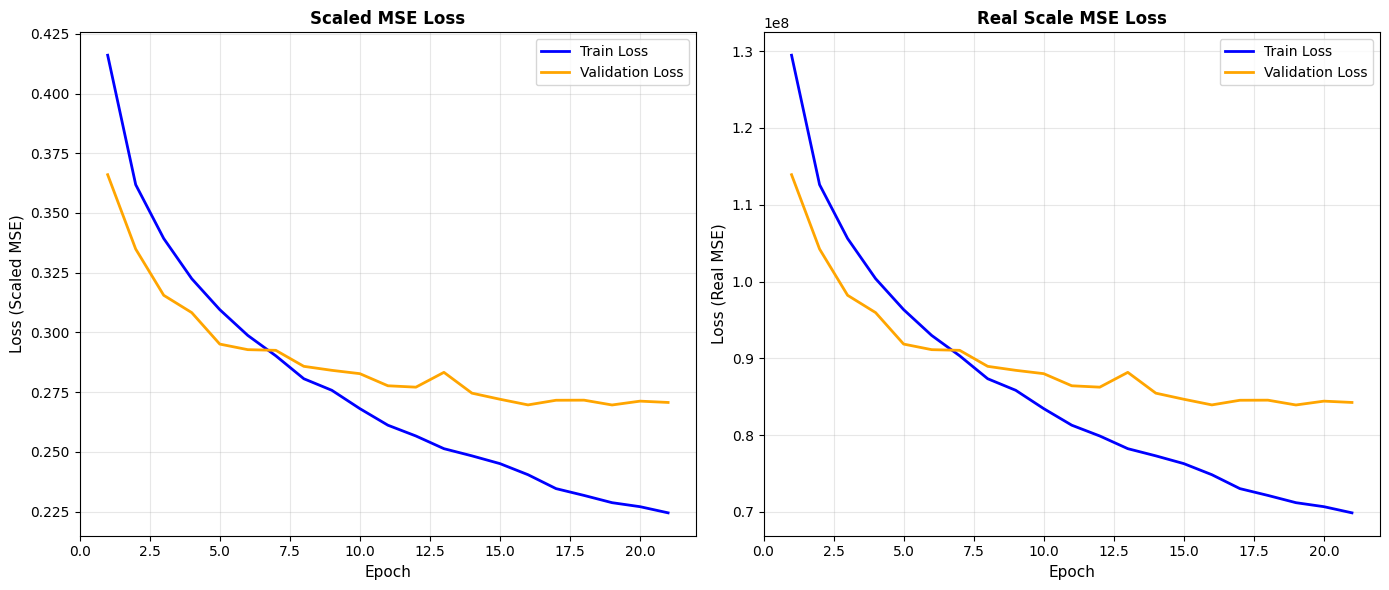

In [145]:
plot_losses(train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real)

In [146]:
model_name = 'emb_int_unk_bs64_adam_lrs_no_hid256_dr30'
torch.save(model.state_dict(), MODELS_DIR + model_name + '.pth')

In [147]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    fulldata_best_models[model_name] = {
        'Test MSE (scaled)': test_loss_scaled_avg,
        'Test MSE (real)': test_loss_real_avg,
        'Test RMSE (real)': np.sqrt(test_loss_real_avg)
    }

Now change order of batch normalization and activation functions.

In [148]:
set_seed()

input_dim = X_train_processed.shape[1]
hidden_size = 256
dropout_prob = 0.3
patience_scheduler = 2
lr = 0.001
batch_norm_before_activation = False

model = IntegratedNN(input_dim, hidden_size, dropout_prob, batch_norm_before_activation).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
### scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=patience_scheduler)

target_scaler = joblib.load(PREPROCESSORS_DIR + 'target_scaler.pkl')

n_epochs = 25
patience = 5
delta = 0.001
early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True, restore_best_weights=True)

# Lists to store training and validation loss
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(X_batch).squeeze()

        # Compute loss
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * X_batch.size(0)

    train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(train_loader.dataset)
    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    with torch.no_grad():
        for X_batch, y_batch in valid_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Forward pass
            predictions = model(X_batch).squeeze()
            loss = loss_fn(predictions, y_batch)
            valid_loss_scaled += loss.item() * X_batch.size(0)

            # Compute MSE in real scale
            predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
            y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
            mse_real = np.mean((predictions_real - y_batch_real) ** 2)
            valid_loss_real += mse_real * X_batch.size(0)

    # Average losses
    valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Step the scheduler
    ### scheduler.step(valid_loss_scaled_avg)

    # Print epoch results
    print(f'Epoch {epoch+1}/{n_epochs}:')
    print(f'  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}')
    print(f'  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}')

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg,  model)
    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch+1}") 
        break

Epoch 1/25:
  Train - MSE: 0.4251, Real MSE: 132308536.00, Real RMSE: 11502.54
  Valid - MSE: 0.3738, Real MSE: 116333328.00, Real RMSE: 10785.79
Validation loss improved to 0.373806.
Epoch 2/25:
  Train - MSE: 0.3751, Real MSE: 116751448.00, Real RMSE: 10805.16
  Valid - MSE: 0.3522, Real MSE: 109600880.00, Real RMSE: 10469.04
Validation loss improved to 0.352173.
Epoch 3/25:
  Train - MSE: 0.3574, Real MSE: 111225320.00, Real RMSE: 10546.34
  Valid - MSE: 0.3508, Real MSE: 109174136.00, Real RMSE: 10448.64
Validation loss improved to 0.350801.
Epoch 4/25:
  Train - MSE: 0.3439, Real MSE: 107013696.00, Real RMSE: 10344.74
  Valid - MSE: 0.3632, Real MSE: 113032400.00, Real RMSE: 10631.67
No improvement in validation loss for 1 epoch.
Epoch 5/25:
  Train - MSE: 0.3296, Real MSE: 102579352.00, Real RMSE: 10128.15
  Valid - MSE: 0.3482, Real MSE: 108359000.00, Real RMSE: 10409.56
Validation loss improved to 0.348182.
Epoch 6/25:
  Train - MSE: 0.3210, Real MSE: 99907528.00, Real RMSE: 99

MSE for validation is high however MAE is relatively low.

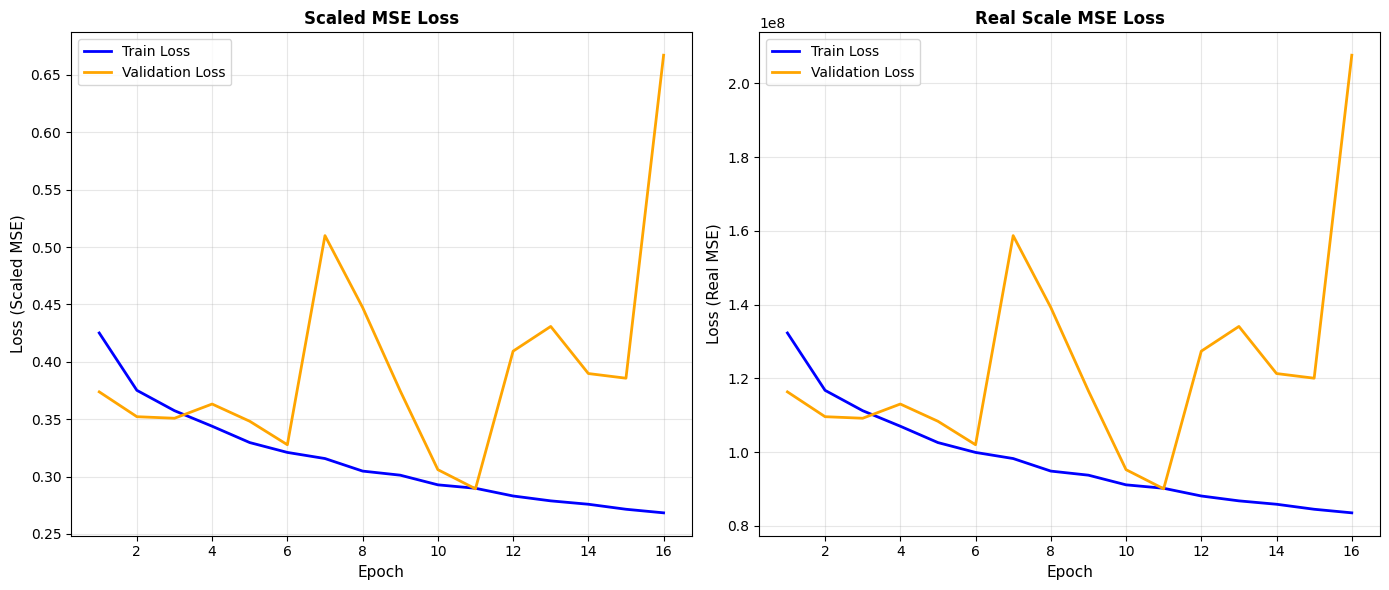

In [149]:
plot_losses(train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real)

In [150]:
print_model_parameters_summary(model)

fc1.weight: 206,336 parameters, trainable=True
fc1.bias: 256 parameters, trainable=True
bn1.weight: 256 parameters, trainable=True
bn1.bias: 256 parameters, trainable=True
fc2.weight: 32,768 parameters, trainable=True
fc2.bias: 128 parameters, trainable=True
bn2.weight: 128 parameters, trainable=True
bn2.bias: 128 parameters, trainable=True
fc3.weight: 8,192 parameters, trainable=True
fc3.bias: 64 parameters, trainable=True
bn3.weight: 64 parameters, trainable=True
bn3.bias: 64 parameters, trainable=True
fc4.weight: 64 parameters, trainable=True
fc4.bias: 1 parameters, trainable=True
----------------------------------------
Total Parameters: 248,705


In [151]:
model_name = 'emb_int_unk_bs64_adam_lrs_no_hid256_dr30_batchnorm_after'
torch.save(model.state_dict(), MODELS_DIR + model_name + '.pth')

In [152]:
model.eval()

with torch.no_grad():
    test_loss_scaled = 0.0
    test_loss_real = 0.0
    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Forward pass
        predictions = model(X_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * X_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        test_loss_real += mse_real * X_batch.size(0)

    # Average losses
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    test_loss_real_avg = test_loss_real / len(test_loader.dataset)

    fulldata_best_models[model_name] = {
        'Test MSE (scaled)': test_loss_scaled_avg,
        'Test MSE (real)': test_loss_real_avg,
        'Test RMSE (real)': np.sqrt(test_loss_real_avg)
    }


Poor performance on validation.

### Building Multi-Input Model with Embeddings and Categorical Features

At first we need to define which columns are representation of embeddings and which are categorical features.

In [ ]:
# Get the fitted transformers to find their dimensions
title_embedder = preprocessor_with_embeddings.named_transformers_['title_embeddings']['embedder']
desc_embedder = preprocessor_with_embeddings.named_transformers_['desc_embeddings']['embedder']
onehot_encoder = preprocessor_with_embeddings.named_transformers_['onehot']['onehot']

# Calculate the dimensions of each feature group
embedding_dim = title_embedder.model.get_sentence_embedding_dimension()  # Should be 384
print(f"Embedding dimension: {embedding_dim}") # two times 384 because we have title and description
title_dim = embedding_dim
desc_dim = embedding_dim
onehot_dim = onehot_encoder.get_feature_names_out().shape[0]  # Total one-hot features
print(f"One-hot dimension: {onehot_dim}")
target_dim = len(high_cardinality_columns) # 3
print(f"Target encoded dimension: {target_dim}")

# Define the start and end indices for each slice
# Note: The order is crucial and must match the ColumnTransformer.
title_end_idx = title_dim
desc_end_idx = title_dim + desc_dim
onehot_end_idx = desc_end_idx + onehot_dim
target_end_idx = onehot_end_idx + target_dim

# Now you can slice the processed data
embeddings_features = X_train_processed[:, :desc_end_idx]
tabular_features = X_train_processed[:, desc_end_idx:]

print(f"Total embeddings shape: {embeddings_features.shape}")
print(f"Total tabular shape: {tabular_features.shape}")

In [ ]:
# Now we can set tabular_start_index
tabular_start_index = desc_end_idx

Now we need to define new custom Dataset class that will handle both types of inputs.

In [ ]:
class MultiInputDataset(Dataset):
    def __init__(self, X_processed: Union[np.ndarray, pd.DataFrame], y_scaled: np.ndarray, tabular_start_index: int):
        """
        Custom PyTorch Dataset for handling multiple input types (e.g., embeddings and tabular data).

        This class splits the preprocessed feature matrix into its constituent parts
        (e.g., text embeddings and tabular features) and prepares them as PyTorch tensors.

        Args:
            X_processed: The combined feature matrix from a `ColumnTransformer`, expected
                         to be a numpy array or pandas DataFrame.
            y_scaled: The scaled target values, as a numpy array.
            tabular_start_index: The column index where the tabular features begin.
                                 Features before this index are considered embeddings.
        """
        # Ensure X_processed is a numpy array for consistent tensor conversion
        if isinstance(X_processed, pd.DataFrame):
            X_processed = X_processed.values
            
        self.X_processed = torch.from_numpy(X_processed).float()
        self.y_scaled = torch.from_numpy(y_scaled).float()
        self.tabular_start_index = tabular_start_index

    def __len__(self) -> int:
        return len(self.X_processed)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Retrieves a single sample by its index, splitting features into embeddings and tabular data.

        Args:
            idx: The index of the sample to retrieve.

        Returns:
            A tuple containing three tensors: the embeddings, the tabular features,
            and the corresponding target value for the given index.
        """
        embeddings = self.X_processed[idx, :self.tabular_start_index]
        tabular_features = self.X_processed[idx, self.tabular_start_index:]
        
        target = self.y_scaled[idx]

        return embeddings, tabular_features, target

In [ ]:
multi_input_train_dataset = MultiInputDataset(X_train_processed, y_train_scaled, tabular_start_index)
multi_input_valid_dataset = MultiInputDataset(X_valid_processed, y_valid_scaled, tabular_start_index)
multi_input_test_dataset = MultiInputDataset(X_test_processed, y_test_scaled, tabular_start_index)

In [ ]:
# Try get a batch
for embeddings, tabular, target in DataLoader(multi_input_train_dataset, batch_size=4, shuffle=True):
    print(f"Embeddings shape: {embeddings.shape}")  # Should be (batch_size, embedding_dim*2)
    print(f"Example embeddings: {embeddings}")
    print(f"Tabular shape: {tabular.shape}")        # Should be (batch_size, tabular_dim)
    print(f"Example tabular: {tabular}")
    print(f"Target shape: {target.shape}")          # Should be (batch_size, 1)
    print(f"Example target: {target}")
    break

Embeddings shape: torch.Size([4, 768])
Example embeddings: tensor([[-0.0782,  0.0810,  0.0020,  ...,  0.0364,  0.0094,  0.0105],
        [-0.0445, -0.0172, -0.0685,  ..., -0.1033, -0.0088,  0.0195],
        [-0.0163,  0.0317,  0.0310,  ...,  0.0765,  0.0951,  0.0436],
        [-0.0729,  0.0436, -0.0455,  ..., -0.1242, -0.0065, -0.0060]])
Tabular shape: torch.Size([4, 38])
Example tabular: tensor([[ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000,
          0.0000,  1.0000,  0.0000, -0.3390, -0.5334, -0.4201],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0

In [ ]:
batch_size = 64 
num_workers = 0

multi_input_train_loader = DataLoader(multi_input_train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)
multi_input_valid_loader = DataLoader(multi_input_valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)
multi_input_test_loader = DataLoader(multi_input_test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=seed_worker, generator=g)

### Building multi-input model

In [19]:
class MultiInputNN(nn.Module):
    def __init__(self, 
                 embedding_dim: int, 
                 tabular_dim: int, 
                 embedding_hidden: List[int] = [256, 128], 
                 tabular_hidden: List[int] = [64, 32], 
                 combined_hidden: List[int] = [128, 64], 
                 dropout_prob: float = 0.3):
        """
        A neural network designed to handle multiple input types, such as text embeddings and tabular data.

        The network consists of three main components: a sub-network for processing embeddings,
        a sub-network for processing tabular features, and a combined network that
        concatenates their outputs to produce a final prediction. Each sub-network
        uses a sequence of linear layers, batch normalization, ReLU activation, and dropout.

        Args:
            embedding_dim: The dimension of the input text embeddings.
            tabular_dim: The number of features in the tabular data.
            embedding_hidden: A list of integers representing the number of neurons in
                              the hidden layers of the embedding sub-network. Defaults to [256, 128].
            tabular_hidden: A list of integers representing the number of neurons in
                            the hidden layers of the tabular sub-network. Defaults to [64, 32].
            combined_hidden: A list of integers representing the number of neurons in
                             the hidden layers of the combined network. Defaults to [128, 64].
            dropout_prob: The dropout probability applied in all dropout layers. Defaults to 0.3.
        """
        super(MultiInputNN, self).__init__()
        self.embedding_dim = embedding_dim
        self.tabular_dim = tabular_dim
        self.embedding_hidden = embedding_hidden
        self.tabular_hidden = tabular_hidden
        self.dropout_prob = dropout_prob

        # Embedding layers
        embedding_layers = []
        input_size = embedding_dim
        for hidden_size in embedding_hidden:
            embedding_layers.append(nn.Linear(input_size, hidden_size))
            embedding_layers.append(nn.BatchNorm1d(hidden_size))
            embedding_layers.append(nn.ReLU())
            embedding_layers.append(nn.Dropout(p=dropout_prob))
            input_size = hidden_size
        
        self.embedding_net = nn.Sequential(*embedding_layers)

        # Tabular layers
        tabular_layers = []
        input_size = tabular_dim
        for hidden_size in tabular_hidden:
            tabular_layers.append(nn.Linear(input_size, hidden_size))
            tabular_layers.append(nn.BatchNorm1d(hidden_size))
            tabular_layers.append(nn.ReLU())
            tabular_layers.append(nn.Dropout(p=dropout_prob))
            input_size = hidden_size

        self.tabular_net = nn.Sequential(*tabular_layers)

        # Combined layers
        combined_input_size = embedding_hidden[-1] + tabular_hidden[-1]
        combined_layers = []
        for hidden_size in combined_hidden:
            combined_layers.append(nn.Linear(combined_input_size, hidden_size))
            combined_layers.append(nn.BatchNorm1d(hidden_size))
            combined_layers.append(nn.ReLU())
            combined_layers.append(nn.Dropout(p=dropout_prob))
            combined_input_size = hidden_size

        combined_layers.append(nn.Linear(combined_input_size, 1))  # Final output layer
        self.combined_net = nn.Sequential(*combined_layers)

    def forward(self, embeddings: torch.Tensor, tabular: torch.Tensor) -> torch.Tensor:
        embeddings = self.embedding_net(embeddings)
        tabular = self.tabular_net(tabular)
        combined = torch.cat((embeddings, tabular), dim=1)
        output = self.combined_net(combined)
        return output

#### Training multi-input model

In [160]:
set_seed()

input_dim = X_train_processed.shape[1]
embedding_dim = 2 * 384 # 2 * 384 because we have title and description = 768
tabular_dim = input_dim - embedding_dim

print(f"Embedding dim: {embedding_dim}, Tabular dim: {tabular_dim}")

dropout_prob = 0.3 
lr = 0.001

model = MultiInputNN(embedding_dim=embedding_dim, tabular_dim=tabular_dim, dropout_prob=dropout_prob).to(device)

loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

target_scaler = joblib.load(PREPROCESSORS_DIR + 'target_scaler.pkl')

n_epochs = 25
patience = 3
delta = 0.001
early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True, restore_best_weights=True)

# Lists to store training and validation loss
train_losses_scaled = []
valid_losses_scaled = []
train_losses_real = []
valid_losses_real = []

for epoch in range(n_epochs):
    model.train()
    train_loss_scaled = 0.0
    train_loss_real = 0.0
    for embeddings_batch, tabular_batch, y_batch in multi_input_train_loader:
        embeddings_batch, tabular_batch, y_batch = embeddings_batch.to(device), tabular_batch.to(device), y_batch.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        predictions = model(embeddings_batch, tabular_batch).squeeze()

        # Compute loss
        loss = loss_fn(predictions, y_batch)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        train_loss_scaled += loss.item() * embeddings_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        train_loss_real += mse_real * embeddings_batch.size(0)

    train_loss_scaled_avg = train_loss_scaled / len(multi_input_train_loader.dataset)
    train_loss_real_avg = train_loss_real / len(multi_input_train_loader.dataset)

    train_losses_scaled.append(train_loss_scaled_avg)
    train_losses_real.append(train_loss_real_avg)

    model.eval()
    valid_loss_scaled = 0.0
    valid_loss_real = 0.0
    for embeddings_batch, tabular_batch, y_batch in multi_input_valid_loader:
        embeddings_batch, tabular_batch, y_batch = embeddings_batch.to(device), tabular_batch.to(device), y_batch.to(device)
        
        # Forward pass
        predictions = model(embeddings_batch, tabular_batch).squeeze()
        loss = loss_fn(predictions, y_batch)
        valid_loss_scaled += loss.item() * embeddings_batch.size(0)

        # Compute MSE in real scale
        predictions_real = target_scaler.inverse_transform(predictions.detach().cpu().numpy().reshape(-1, 1)).ravel()
        y_batch_real = target_scaler.inverse_transform(y_batch.detach().cpu().numpy().reshape(-1, 1)).ravel()
        mse_real = np.mean((predictions_real - y_batch_real) ** 2)
        valid_loss_real += mse_real * embeddings_batch.size(0)

    valid_loss_scaled_avg = valid_loss_scaled / len(multi_input_valid_loader.dataset)
    valid_loss_real_avg = valid_loss_real / len(multi_input_valid_loader.dataset)

    valid_losses_scaled.append(valid_loss_scaled_avg)
    valid_losses_real.append(valid_loss_real_avg)

    # Print epoch results
    print(f'Epoch {epoch+1}/{n_epochs}:')
    print(f'  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {np.sqrt(train_loss_real_avg):.2f}')
    print(f'  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {np.sqrt(valid_loss_real_avg):.2f}')

    # Check early stopping
    early_stopping.check_early_stop(valid_loss_scaled_avg,  model)
    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch+1}") 
        break

Embedding dim: 768, Tabular dim: 38
Epoch 1/25:
  Train - MSE: 0.4379, Real MSE: 136288288.00, Real RMSE: 11674.26
  Valid - MSE: 0.3607, Real MSE: 112255104.00, Real RMSE: 10595.05
Validation loss improved to 0.360701.
Epoch 2/25:
  Train - MSE: 0.3771, Real MSE: 117368928.00, Real RMSE: 10833.69
  Valid - MSE: 0.3306, Real MSE: 102875832.00, Real RMSE: 10142.77
Validation loss improved to 0.330564.
Epoch 3/25:
  Train - MSE: 0.3550, Real MSE: 110472160.00, Real RMSE: 10510.57
  Valid - MSE: 0.3310, Real MSE: 103011600.00, Real RMSE: 10149.46
No improvement in validation loss for 1 epoch.
Epoch 4/25:
  Train - MSE: 0.3375, Real MSE: 105036544.00, Real RMSE: 10248.73
  Valid - MSE: 0.3123, Real MSE: 97196080.00, Real RMSE: 9858.81
Validation loss improved to 0.312313.
Epoch 5/25:
  Train - MSE: 0.3230, Real MSE: 100527320.00, Real RMSE: 10026.33
  Valid - MSE: 0.3184, Real MSE: 99090112.00, Real RMSE: 9954.40
No improvement in validation loss for 1 epoch.
Epoch 6/25:
  Train - MSE: 0.3

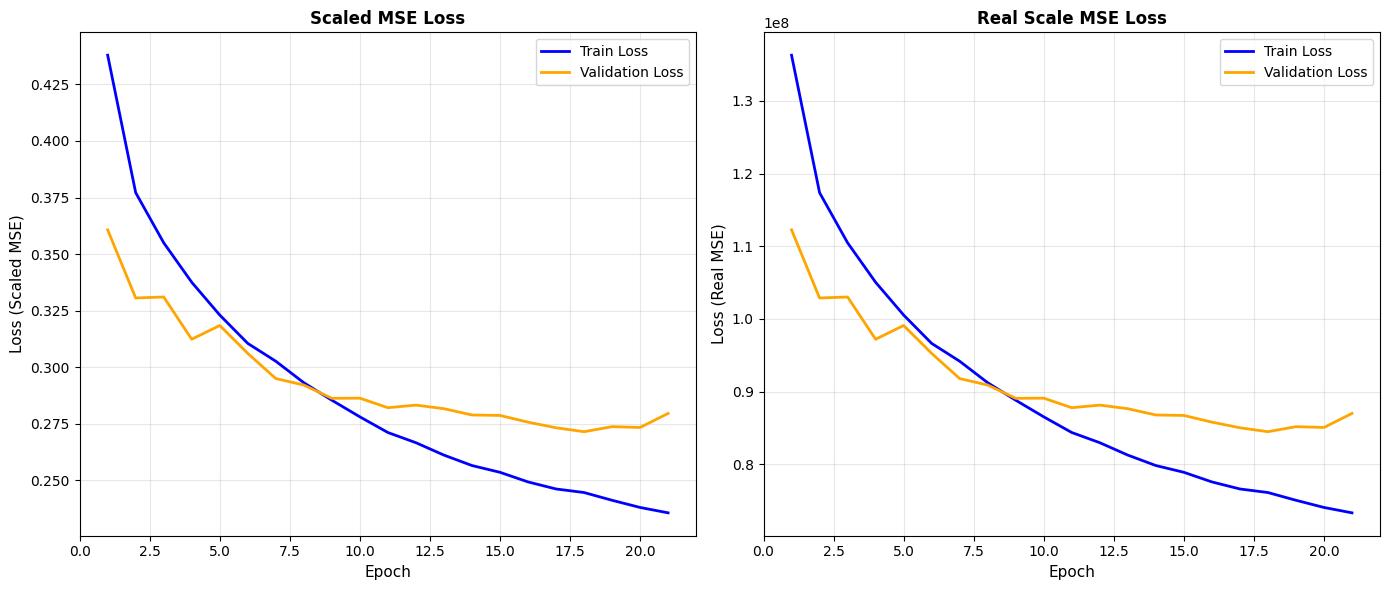

In [161]:
plot_losses(train_losses_scaled, valid_losses_scaled, train_losses_real, valid_losses_real)

In [162]:
print_model_parameters_summary(model)

embedding_net.0.weight: 196,608 parameters, trainable=True
embedding_net.0.bias: 256 parameters, trainable=True
embedding_net.1.weight: 256 parameters, trainable=True
embedding_net.1.bias: 256 parameters, trainable=True
embedding_net.4.weight: 32,768 parameters, trainable=True
embedding_net.4.bias: 128 parameters, trainable=True
embedding_net.5.weight: 128 parameters, trainable=True
embedding_net.5.bias: 128 parameters, trainable=True
tabular_net.0.weight: 2,432 parameters, trainable=True
tabular_net.0.bias: 64 parameters, trainable=True
tabular_net.1.weight: 64 parameters, trainable=True
tabular_net.1.bias: 64 parameters, trainable=True
tabular_net.4.weight: 2,048 parameters, trainable=True
tabular_net.4.bias: 32 parameters, trainable=True
tabular_net.5.weight: 32 parameters, trainable=True
tabular_net.5.bias: 32 parameters, trainable=True
combined_net.0.weight: 20,480 parameters, trainable=True
combined_net.0.bias: 128 parameters, trainable=True
combined_net.1.weight: 128 parameters,

In [163]:
model_name = 'emb_multi_unk_bs64_adam_lrs_no_hid256_dr30'
torch.save(model.state_dict(), MODELS_DIR + model_name + '.pth')

In [164]:
model.eval()

test_loss_scaled = 0.0
all_predictions_real = []
all_targets_real = []

with torch.no_grad():
    for embeddings_batch, tabular_batch, y_batch in multi_input_test_loader:
        embeddings_batch = embeddings_batch.to(device)
        tabular_batch = tabular_batch.to(device)
        y_batch = y_batch.to(device)

        # Forward pass (multi-input)
        predictions = model(embeddings_batch, tabular_batch).squeeze()
        
        # Accumulate loss in scaled domain
        loss = loss_fn(predictions, y_batch)
        test_loss_scaled += loss.item() * embeddings_batch.size(0)

        # Store predictions and targets for real-scale metrics
        all_predictions_real.extend(target_scaler.inverse_transform(predictions.cpu().numpy().reshape(-1, 1)).ravel())
        all_targets_real.extend(target_scaler.inverse_transform(y_batch.cpu().numpy().reshape(-1, 1)).ravel())

# Average loss over the entire dataset
test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)

# Calculate real-scale metrics over the entire dataset
all_predictions_real = np.array(all_predictions_real)
all_targets_real = np.array(all_targets_real)

mse_real = np.mean((all_predictions_real - all_targets_real) ** 2)
rmse_real = np.sqrt(mse_real)

fulldata_best_models[model_name] = {
    'Test MSE (scaled)': test_loss_scaled_avg,
    'Test MSE (real)': mse_real,
    'Test RMSE (real)': rmse_real
}

In [165]:
def evaluate_multi_input_model(
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
    target_scaler,
    device: torch.device,
    loss_fn_str: str = 'mse',
    model_name: str = None,
    results_dict: Dict = None
) -> Dict:
    """
    Evaluates a multi-input PyTorch regression model and stores results in a dictionary.

    Args:
        model: The trained PyTorch model (expects multi-input).
        test_loader: DataLoader for the test data (MultiInputDataset).
        target_scaler: The fitted scaler for inverse transforming predictions.
        device: torch device (cuda or cpu).
        loss_fn_str: The metric to calculate ('mse' or 'mae').
        model_name: Name/identifier for the model (optional).
        results_dict: Dictionary to store results (optional, will update in-place).

    Returns:
        A dictionary containing the calculated metrics.
    """
    model.eval()
    
    # Select the appropriate loss function
    if loss_fn_str == 'mse':
        loss_function = nn.MSELoss()
    elif loss_fn_str == 'mae':
        loss_function = nn.L1Loss()
    else:
        raise ValueError("Unsupported loss function. Use 'mse' or 'mae'.")

    # Metrics for evaluation
    test_loss_scaled = 0.0
    all_predictions_real = []
    all_targets_real = []

    with torch.no_grad():
        for embeddings_batch, tabular_batch, y_batch in test_loader:
            embeddings_batch = embeddings_batch.to(device)
            tabular_batch = tabular_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass (multi-input)
            predictions = model(embeddings_batch, tabular_batch).squeeze()
            
            # Accumulate loss in scaled domain
            loss = loss_function(predictions, y_batch)
            test_loss_scaled += loss.item() * embeddings_batch.size(0)

            # Store predictions and targets for real-scale metrics
            all_predictions_real.extend(target_scaler.inverse_transform(predictions.cpu().numpy().reshape(-1, 1)).ravel())
            all_targets_real.extend(target_scaler.inverse_transform(y_batch.cpu().numpy().reshape(-1, 1)).ravel())

    # Average loss over the entire dataset
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    
    # Calculate real-scale metrics over the entire dataset
    all_predictions_real = np.array(all_predictions_real)
    all_targets_real = np.array(all_targets_real)
    
    metrics = {}
    if loss_fn_str == 'mse':
        mse_real = np.mean((all_predictions_real - all_targets_real) ** 2)
        metrics['Test MSE (scaled)'] = test_loss_scaled_avg
        metrics['Test MSE (real)'] = mse_real
        metrics['Test RMSE (real)'] = np.sqrt(mse_real)
    elif loss_fn_str == 'mae':
        mae_real = np.mean(np.abs(all_predictions_real - all_targets_real))
        metrics['Test MAE (scaled)'] = test_loss_scaled_avg
        metrics['Test MAE (real)'] = mae_real
    
    # Store in results_dict if provided
    if results_dict is not None and model_name is not None:
        results_dict[model_name] = metrics
    
    return metrics


## Combine everything together

**List of models I have created:**

- `SimpleRegressor`
- `SimpleRegressorWithNormalization`
- `IntegratedNN`
- `MultiInputNN`



### Function to load data and handle missing values in 'Title' column

In [ ]:
def load_data(file_path: str = FILEPATH) -> pd.DataFrame:
    """
    Loads data from a CSV and handles missing values in 'Title'.

    Args:
        file_path: Path to the raw CSV data file.
        
    Returns:
        df (pd.DataFrame): Loaded dataset with imputed Title values.
    """
    # Load data from the specified path
    df = pd.read_csv(file_path)

    # Impute missing value in 'Title' based on EDA findings.
    df.loc[df['Title'].isnull(), 'Title'] = 'Quality Improvement Manager'

    return df

### Function to select features and split into train, val, test sets

In [ ]:
def split_data(
    df: pd.DataFrame,
    test_size: float = 0.2,
    valid_size: float = 0.5,
    random_state: int = RANDOM_SEED,
    log: bool = False
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.Series, pd.Series, pd.Series]:
    """
    Splits data into training, validation, and test sets.

    Args:
        df: Input dataframe.
        test_size: Proportion of the dataset to include in the test split.
        valid_size: Proportion of the temporary split to include in the
                    validation split.
        random_state: Seed for reproducible train/test splits.
        log: Whether to apply log transformation to the target variable.
        
    Returns:
        A tuple containing:
        - X_train (pd.DataFrame): Training features.
        - X_valid (pd.DataFrame): Validation features.
        - X_test (pd.DataFrame): Test features.
        - y_train (pd.Series): Training target.
        - y_valid (pd.Series): Validation target.
        - y_test (pd.Series): Test target.
    """
    # Separate features (X) and target (y)
    X = df[['Title', 'FullDescription', 'Category', 'Company', 
            'LocationNormalized', 'ContractType', 'ContractTime', 'SourceName']]
    
    if log:
        y = np.log1p(df['SalaryNormalized'])  # log(1 + x) to handle zero salaries if any
    else:
        y = df['SalaryNormalized']

    # Split data into training, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=test_size, random_state=random_state
    )
    X_valid, X_test, y_valid, y_test = train_test_split(
        X_temp, y_temp, test_size=valid_size, random_state=random_state
    )

    print(f"Train set has {len(X_train)} entries")
    print(f"Validation set has {len(X_valid)} entries")
    print(f"Test set has {len(X_test)} entries")

    return X_train, X_valid, X_test, y_train, y_valid, y_test

### Function to preprocess categorcial data, create datasets and dataloaders for pretrained embeddings

### Function to preprocess text data with pretrained embeddings and save them

### Function to merge preprocessed text data with categorical data

### Function to create datasets

### Function to create dataloaders

In [21]:
def preprocess_salary_data_with_embeddings(
    X_train: pd.DataFrame, 
    X_valid: pd.DataFrame, 
    X_test: pd.DataFrame,
    y_train: pd.Series, 
    y_valid: pd.Series, 
    y_test: pd.Series,
    categorical_columns: Optional[List[str]] = ['Category', 'ContractType', 'ContractTime'],
    high_cardinality_columns: Optional[List[str]] = ['Company', 'LocationNormalized', 'SourceName'],
    title_column: str = 'Title',
    desc_column: str = 'FullDescription',
    embedding_model_name: str = 'all-MiniLM-L12-v2',
    batch_size: int = 64,
    num_workers: int = 0,
    categorical_na_strategy: str = 'constant',
    categorical_fill_value: str = 'unknown',
    high_card_na_strategy: str = 'constant',
    high_card_fill_value: str = 'unknown',
    save_artifacts: bool = True,
    artifact_prefix: str = '',
    multi_input: bool = False,
    seed_worker: Optional[callable] = seed_worker,
    generator: Optional[torch.Generator] = g,
    log: bool = False,
) -> Dict[str, Any]:
    """
    Complete preprocessing pipeline using text embeddings instead of TF-IDF.
    
    Args:
        X_train: The training input data as a pandas DataFrame.
        X_valid: The validation input data as a pandas DataFrame.
        X_test: The test input data as a pandas DataFrame.
        y_train: The training target values as a pandas Series.
        y_valid: The validation target values as a pandas Series.
        y_test: The test target values as a pandas Series.
        categorical_columns: A list of column names for low-cardinality categorical features to be one-hot encoded.
        high_cardinality_columns: A list of column names for high-cardinality categorical features to be target encoded.
        title_column: The name of the column containing the job title text.
        desc_column: The name of the column containing the job description text.
        embedding_model_name: The name of the SentenceTransformer model to use for text embeddings (e.g., 'all-MiniLM-L12-v2').
        batch_size: The batch size for the PyTorch DataLoaders.
        num_workers: The number of subprocesses to use for data loading.
        categorical_na_strategy: The imputation strategy for categorical columns ('constant' or 'most_frequent').
        categorical_fill_value: The value to use for filling missing values in categorical columns if `categorical_na_strategy` is 'constant'.
        high_card_na_strategy: The imputation strategy for high-cardinality columns ('constant' or 'most_frequent').
        high_card_fill_value: The value to use for filling missing values in high-cardinality columns if `high_card_na_strategy` is 'constant'.
        save_artifacts: Whether to save the fitted preprocessors (ColumnTransformer and StandardScaler).
        artifact_prefix: A string prefix for saved artifact filenames.
        multi_input: If True, creates a MultiInputDataset for models expecting separate inputs; otherwise, creates a standard SalaryDataset.
        seed_worker: Function to initialize each worker process (for reproducibility).
        generator: torch.Generator for DataLoader (for reproducibility).
        log: If True, indicates that y is already log-transformed, so skips target scaling and artifact saving.
        
    Returns:
        A dictionary containing:
            - 'train_loader', 'valid_loader', 'test_loader': PyTorch DataLoaders.
            - 'preprocessors': dict of fitted feature and target preprocessors.
            - 'feature_shape': shape of processed features.
            - 'processed_arrays': dict of the processed numpy arrays (X_train, y_train, etc.).
            - 'tabular_start_index': (Optional) index where tabular features start for multi-input models.
    """
    
    # Step 1: Build embedding pipelines
    title_embedding_pipeline = Pipeline([
        ('embedder', TextEmbedder(model_name=embedding_model_name))
    ])
    
    desc_embedding_pipeline = Pipeline([
        ('embedder', TextEmbedder(model_name=embedding_model_name))
    ])
    
    # Step 2: Setup categorical imputer
    if categorical_na_strategy == 'constant':
        cat_imputer = SimpleImputer(strategy='constant', fill_value=categorical_fill_value)
    else:
        cat_imputer = SimpleImputer(strategy='most_frequent')
    
    one_hot_pipeline = Pipeline([
        ('imputer', cat_imputer),  
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])
    
    # Step 3: Setup high cardinality imputer
    if high_card_na_strategy == 'constant':
        high_card_imputer = SimpleImputer(strategy='constant', fill_value=high_card_fill_value)
    else:
        high_card_imputer = SimpleImputer(strategy='most_frequent')
    
    target_pipeline = Pipeline([
        ('imputer', high_card_imputer), 
        ('target_enc', TargetEncoder()), 
        ('scaler', StandardScaler())
    ])
    
    # Step 4: Combine into ColumnTransformer
    preprocessor_with_embeddings = ColumnTransformer([
        ('title_embeddings', title_embedding_pipeline, [title_column]),
        ('desc_embeddings', desc_embedding_pipeline, [desc_column]),
        ('onehot', one_hot_pipeline, categorical_columns),
        ('target_scaled', target_pipeline, high_cardinality_columns)
    ])
    
    # Step 5: Fit and transform features
    print(f"Using embedding model: {embedding_model_name}")
    print("Generating embeddings (this may take a while)...")
    X_train_processed = preprocessor_with_embeddings.fit_transform(X_train, y_train)
    X_valid_processed = preprocessor_with_embeddings.transform(X_valid)
    X_test_processed = preprocessor_with_embeddings.transform(X_test)
    print("Embeddings generated successfully!")
    
    # Step 6: Scale target (skip if log=True, as y is already log-transformed)
    if log:
        # y is already log-transformed, don't apply StandardScaler
        y_train_scaled = y_train.values
        y_valid_scaled = y_valid.values
        y_test_scaled = y_test.values
        target_scaler = None
        print("Log mode: Target is already log-transformed, skipping StandardScaler")
    else:
        target_scaler = StandardScaler()
        y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
        y_valid_scaled = target_scaler.transform(y_valid.values.reshape(-1, 1)).ravel()
        y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()
    
    # Step 7: Calculate tabular_start_index if multi_input
    tabular_start_index: Optional[int] = None
    if multi_input:
        # Get the fitted transformers to find their dimensions
        title_embedder = preprocessor_with_embeddings.named_transformers_['title_embeddings']['embedder']
        desc_embedder = preprocessor_with_embeddings.named_transformers_['desc_embeddings']['embedder']
        
        # Calculate the dimensions of each feature group
        embedding_dim: int = title_embedder.model.get_sentence_embedding_dimension()
        title_dim: int = embedding_dim
        desc_dim: int = embedding_dim
        
        # The tabular features start after title and description embeddings
        tabular_start_index = title_dim + desc_dim
        
        print(f"Embedding dimension: {embedding_dim}")
        print(f"Tabular start index: {tabular_start_index}")
    
    # Step 8: Create datasets
    if multi_input:
        if tabular_start_index is None:
            raise ValueError("Multi-input mode requires tabular_start_index, but it was not calculated.")
        train_dataset = MultiInputDataset(X_train_processed, y_train_scaled, tabular_start_index)
        valid_dataset = MultiInputDataset(X_valid_processed, y_valid_scaled, tabular_start_index)
        test_dataset = MultiInputDataset(X_test_processed, y_test_scaled, tabular_start_index)
    else:
        train_dataset = SalaryDataset(X_train_processed, y_train_scaled)
        valid_dataset = SalaryDataset(X_valid_processed, y_valid_scaled)
        test_dataset = SalaryDataset(X_test_processed, y_test_scaled)
    
    # Step 9: Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=seed_worker, generator=generator)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=seed_worker, generator=generator)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=seed_worker, generator=generator)

    # Step 10: Save artifacts (skip if log=True)
    if save_artifacts and not log:
        print("Saving preprocessor artifacts...")
        os.makedirs(PREPROCESSORS_DIR, exist_ok=True)
        
        preprocessor_path = PREPROCESSORS_DIR + f'{artifact_prefix}preprocessor_with_embeddings.pkl'
        scaler_path = PREPROCESSORS_DIR + f'{artifact_prefix}target_scaler.pkl'
        
        joblib.dump(preprocessor_with_embeddings, preprocessor_path)
        joblib.dump(target_scaler, scaler_path)
    elif log:
        print("Log mode: Skipping artifact saving")

    print(f"\nFinal feature shape: {X_train_processed.shape}")
    print(f"Categorical NA strategy: {categorical_na_strategy}")
    print(f"High cardinality NA strategy: {high_card_na_strategy}")
    print(f"Multi-input mode: {multi_input}")
    print(f"Log mode: {log}")
    
    result: Dict[str, Any] = {
        'train_loader': train_loader,
        'valid_loader': valid_loader,
        'test_loader': test_loader,
        'preprocessors': {
            'feature_prep': preprocessor_with_embeddings,
            'target_scaler': target_scaler
        },
        'feature_shape': X_train_processed.shape,
        'processed_arrays': {
            'X_train': X_train_processed,
            'X_valid': X_valid_processed,
            'X_test': X_test_processed,
            'y_train': y_train_scaled,
            'y_valid': y_valid_scaled,
            'y_test': y_test_scaled
        }
    }
    
    if multi_input and tabular_start_index is not None:
        result['tabular_start_index'] = tabular_start_index
    
    return result

### Function to preprocess data, create datasets and dataloaders for TF-IDF approach

In [22]:
def preprocess_salary_data_with_tfidf(
    X_train: pd.DataFrame, 
    X_valid: pd.DataFrame, 
    X_test: pd.DataFrame,
    y_train: pd.Series, 
    y_valid: pd.Series, 
    y_test: pd.Series,
    categorical_columns: List[str] = ['Category', 'ContractType', 'ContractTime'],
    high_cardinality_columns: List[str] = ['Company', 'LocationNormalized', 'SourceName'],
    title_max_features: int = 50,
    desc_max_features: int = 800,
    title_use_svd: bool = False,
    title_n_components: int = 10,
    desc_use_svd: bool = False,
    desc_n_components: int = 50,
    title_stop_words: Optional[Union[str, List[str]]] = None,
    desc_stop_words: Optional[Union[str, List[str]]] = None,
    batch_size: int = 64,
    num_workers: int = 0,
    categorical_na_strategy: str = 'constant',
    categorical_fill_value: str = 'unknown',
    high_card_na_strategy: str = 'constant',
    high_card_fill_value: str = 'unknown',
    save_artifacts: bool = True,
    artifact_prefix: str = '',
    multi_input: bool = False,
    seed_worker: Optional[callable] = seed_worker,
    generator: Optional[torch.Generator] = g,
    log: bool = False,
) -> Dict[str, Any]:
    """
    Complete preprocessing pipeline for salary prediction data with TF-IDF.
    
    Args:
        X_train, X_valid, X_test: Input dataframes
        y_train, y_valid, y_test: Target values
        categorical_columns: List of low-cardinality categorical columns
        high_cardinality_columns: List of high-cardinality columns for target encoding
        title_max_features: Max TF-IDF features for title column
        desc_max_features: Max TF-IDF features for description column
        title_use_svd: Whether to apply SVD to title TF-IDF features
        title_n_components: Number of SVD components for title (if use_svd=True)
        desc_use_svd: Whether to apply SVD to description TF-IDF features
        desc_n_components: Number of SVD components for description (if use_svd=True)
        title_stop_words: Stop words for title vectorizer ('english', None, or list)
        desc_stop_words: Stop words for description vectorizer ('english', None, or list)
        batch_size: DataLoader batch size
        num_workers: DataLoader num_workers
        categorical_na_strategy: 'constant' or 'most_frequent' for categorical columns
        categorical_fill_value: Fill value when categorical_na_strategy='constant'
        high_card_na_strategy: 'constant' or 'most_frequent' for high cardinality columns
        high_card_fill_value: Fill value when high_card_na_strategy='constant'
        save_artifacts: Whether to save preprocessors
        artifact_prefix: Prefix for saved artifact filenames
        multi_input: If True, create MultiInputDataset; if False, create SalaryDataset
        seed_worker: Function to initialize each worker process (for reproducibility)
        generator: torch.Generator for DataLoader (for reproducibility)
        log: If True, indicates that y is already log-transformed, so skips target scaling and artifact saving.
        
    Returns:
        dict containing:
            - train_loader, valid_loader, test_loader: DataLoaders
            - preprocessors: dict of fitted preprocessors
            - feature_shape: shape of processed features
            - tabular_start_index: (only if multi_input=True) index where tabular features start
    """
    
    # Step 1: Clean text
    shared_text_prep = MinimalTextPreprocessor()
    X_train_clean = shared_text_prep.fit_transform(X_train)
    X_valid_clean = shared_text_prep.transform(X_valid)
    X_test_clean = shared_text_prep.transform(X_test)
    
    # Step 2: Build feature extraction pipelines
    title_pipeline = make_pipeline(
        TfidfTransformer(
            text_column='Title', 
            max_features=title_max_features,
            use_svd=title_use_svd,
            n_components=title_n_components,
            stop_words=title_stop_words
        )
    )
    
    desc_pipeline = make_pipeline(
        TfidfTransformer(
            text_column='FullDescription', 
            max_features=desc_max_features,
            use_svd=desc_use_svd,
            n_components=desc_n_components,
            stop_words=desc_stop_words
        )
    )
    
    # Categorical imputer setup
    if categorical_na_strategy == 'constant':
        cat_imputer = SimpleImputer(strategy='constant', fill_value=categorical_fill_value)
    else:
        cat_imputer = SimpleImputer(strategy='most_frequent')
    
    one_hot_pipeline = Pipeline([
        ('imputer', cat_imputer),  
        ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))
    ])
    
    # High cardinality imputer setup
    if high_card_na_strategy == 'constant':
        high_card_imputer = SimpleImputer(strategy='constant', fill_value=high_card_fill_value)
    else:
        high_card_imputer = SimpleImputer(strategy='most_frequent')
    
    target_pipeline = Pipeline([
        ('imputer', high_card_imputer), 
        ('target_enc', TargetEncoder()),
        ('scaler', StandardScaler())
    ])
    
    # Step 3: Combine into ColumnTransformer
    preprocessor = ColumnTransformer([
        ('title_tfidf', title_pipeline, ['Title']),
        ('desc_tfidf', desc_pipeline, ['FullDescription']),
        ('onehot', one_hot_pipeline, categorical_columns),
        ('target_scaled', target_pipeline, high_cardinality_columns)
    ])
    
    # Step 4: Fit and transform features
    X_train_processed = preprocessor.fit_transform(X_train_clean, y_train)
    X_valid_processed = preprocessor.transform(X_valid_clean)
    X_test_processed = preprocessor.transform(X_test_clean)
    
    # Step 5: Scale target (skip if log=True, as y is already log-transformed)
    if log:
        # y is already log-transformed, don't apply StandardScaler
        y_train_scaled = y_train.values
        y_valid_scaled = y_valid.values
        y_test_scaled = y_test.values
        target_scaler = None
        print("Log mode: Target is already log-transformed, skipping StandardScaler")
    else:
        target_scaler = StandardScaler()
        y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1)).ravel()
        y_valid_scaled = target_scaler.transform(y_valid.values.reshape(-1, 1)).ravel()
        y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1)).ravel()
    
    # Step 6: Calculate tabular_start_index if multi_input
    tabular_start_index = None
    if multi_input:
        # Calculate dimensions based on whether SVD was used
        if title_use_svd:
            title_dim = title_n_components
        else:
            title_dim = title_max_features
            
        if desc_use_svd:
            desc_dim = desc_n_components
        else:
            desc_dim = desc_max_features
        
        # The tabular features start after title and description TF-IDF features
        tabular_start_index = title_dim + desc_dim
        
        print(f"Title TF-IDF dimension: {title_dim}")
        print(f"Description TF-IDF dimension: {desc_dim}")
        print(f"Tabular start index: {tabular_start_index}")
    
    # Step 7: Create datasets
    if multi_input:
        train_dataset = MultiInputDataset(X_train_processed, y_train_scaled, tabular_start_index)
        valid_dataset = MultiInputDataset(X_valid_processed, y_valid_scaled, tabular_start_index)
        test_dataset = MultiInputDataset(X_test_processed, y_test_scaled, tabular_start_index)
    else:
        train_dataset = SalaryDataset(X_train_processed, y_train_scaled)
        valid_dataset = SalaryDataset(X_valid_processed, y_valid_scaled)
        test_dataset = SalaryDataset(X_test_processed, y_test_scaled)
    
    # Step 8: Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=seed_worker, generator=generator)
    valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=seed_worker, generator=generator)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=seed_worker, generator=generator)

    # Step 9: Save artifacts (skip if log=True)
    if save_artifacts and not log:
        joblib.dump(shared_text_prep, PREPROCESSORS_DIR + f'{artifact_prefix}text_preprocessor.pkl')
        joblib.dump(preprocessor, PREPROCESSORS_DIR + f'{artifact_prefix}preprocessor.pkl')
        joblib.dump(target_scaler, PREPROCESSORS_DIR + f'{artifact_prefix}target_scaler.pkl')
    elif log:
        print("Log mode: Skipping artifact saving")
    
    # Print configuration info
    print(f"Final feature shape: {X_train_processed.shape}")
    print(f"Categorical NA strategy: {categorical_na_strategy}")
    print(f"High cardinality NA strategy: {high_card_na_strategy}")
    print(f"Title: max_features={title_max_features}, use_svd={title_use_svd}" + 
          (f", n_components={title_n_components}" if title_use_svd else ""))
    print(f"Description: max_features={desc_max_features}, use_svd={desc_use_svd}" + 
          (f", n_components={desc_n_components}" if desc_use_svd else ""))
    print(f"Multi-input mode: {multi_input}")
    print(f"Log mode: {log}")
    
    result = {
        'train_loader': train_loader,
        'valid_loader': valid_loader,
        'test_loader': test_loader,
        'preprocessors': {
            'text_prep': shared_text_prep,
            'feature_prep': preprocessor,
            'target_scaler': target_scaler
        },
        'feature_shape': X_train_processed.shape
    }
    
    if multi_input:
        result['tabular_start_index'] = tabular_start_index
    
    return result

### Function to train single input model

In [40]:
def train_single_input_model(
    model: nn.Module,
    train_loader: torch.utils.data.DataLoader,
    valid_loader: torch.utils.data.DataLoader,
    target_scaler = None,
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    n_epochs: int = 25,
    lr: float = 0.001,
    loss_fn: str = 'mse',
    optimizer_fn: str = 'adam',
    patience: int = 4,
    delta: float = 0.001,
    early_stopping = None,
    use_lr_scheduler: bool = False,
    scheduler_patience: int = 2,
    scheduler_factor: float = 0.5,
    seed: Optional[int] = RANDOM_SEED,
    log: bool = False,
) -> Tuple[nn.Module, dict]:
    """
    Train a PyTorch regression model with early stopping.
    
    Args:
        model: PyTorch model to train
        train_loader: DataLoader for training data
        valid_loader: DataLoader for validation data
        target_scaler: Fitted scaler for inverse transforming predictions (None if log=True)
        device: torch device (cuda or cpu)
        n_epochs: Maximum number of epochs
        lr: Learning rate
        loss_fn: Loss function ('mse' for Mean Squared Error, 'mae' for Mean Absolute Error, default: 'mse')
        optimizer_fn: Optimizer function ('adam' or 'sgd', default: 'adam')
        patience: Early stopping patience
        delta: Minimum change to qualify as improvement
        early_stopping: EarlyStopping object (if None, creates one)
        use_lr_scheduler: Whether to use ReduceLROnPlateau scheduler
        scheduler_patience: Patience for learning rate scheduler
        scheduler_factor: Factor to reduce learning rate by
        seed: Random seed for reproducibility (None to skip seeding)
        log: If True, indicates that y is log-transformed (e.g., using log1p); real metrics computed using expm1
    
    Returns:
        Tuple of (trained_model, history_dict, elapsed_time)
    """
    # Set seed for reproducibility
    if seed is not None:
        set_seed(seed)
    
    # Move model to device
    model = model.to(device)
    
    # Setup loss function
    if loss_fn == 'mse':
        loss_function = nn.MSELoss()
    elif loss_fn == 'mae':
        loss_function = nn.L1Loss()
    else:
        raise ValueError("Unsupported loss function. Use 'mse' or 'mae'.")
    
    # Setup optimizer
    if optimizer_fn == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_fn == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise ValueError("Unsupported optimizer. Use 'adam' or 'sgd'.")
    
    # Initialize learning rate scheduler if requested
    scheduler = None
    if use_lr_scheduler:
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=scheduler_factor, 
            patience=scheduler_patience
        )
    
    # Initialize early stopping if not provided
    if early_stopping is None:
        early_stopping = EarlyStopping(
            patience=patience, 
            delta=delta, 
            verbose=True, 
            restore_best_weights=True
        )
    
    # Lists to store metrics based on loss function
    if loss_fn == 'mse':
        history = {
            'train_loss_scaled': [],
            'valid_loss_scaled': [],
            'train_mse_real': [],
            'valid_mse_real': [],
            'train_rmse': [],
            'valid_rmse': []
        }
    else:  # mae
        history = {
            'train_loss_scaled': [],
            'valid_loss_scaled': [],
            'train_mae_real': [],
            'valid_mae_real': []
        }

    start_time = time.time()
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss_scaled = 0.0
        train_loss_real = 0.0
        
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass
            predictions = model(X_batch).squeeze()
            
            # Compute loss
            loss = loss_function(predictions, y_batch)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()
            
            train_loss_scaled += loss.item() * X_batch.size(0)
            
            # Compute metric in real scale
            if log:
                # For log1p-transformed targets: use expm1 to get back to original scale
                # expm1(x) = exp(x) - 1, which is the inverse of log1p
                predictions_real = np.expm1(predictions.detach().cpu().numpy())
                y_batch_real = np.expm1(y_batch.detach().cpu().numpy())
            else:
                # For scaled targets: inverse transform using scaler
                if target_scaler is None:
                    raise ValueError("target_scaler must be provided when log=False")
                predictions_real = target_scaler.inverse_transform(
                    predictions.detach().cpu().numpy().reshape(-1, 1)
                ).ravel()
                y_batch_real = target_scaler.inverse_transform(
                    y_batch.detach().cpu().numpy().reshape(-1, 1)
                ).ravel()
            
            if loss_fn == 'mse':
                metric_real = np.mean((predictions_real - y_batch_real) ** 2)
            else:  # mae
                metric_real = np.mean(np.abs(predictions_real - y_batch_real))
            
            train_loss_real += metric_real * X_batch.size(0)
        
        # Calculate average training losses
        train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
        train_loss_real_avg = train_loss_real / len(train_loader.dataset)
        
        if loss_fn == 'mse':
            train_rmse = np.sqrt(train_loss_real_avg)
        
        # Validation phase
        model.eval()
        valid_loss_scaled = 0.0
        valid_loss_real = 0.0
        
        with torch.no_grad():
            for X_batch, y_batch in valid_loader:
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                
                # Forward pass
                predictions = model(X_batch).squeeze()
                
                # Use specified loss function for validation loss
                loss = loss_function(predictions, y_batch)
                valid_loss_scaled += loss.item() * X_batch.size(0)
                
                # Compute metric in real scale
                if log:
                    # For log1p-transformed targets: use expm1 to get back to original scale
                    # expm1(x) = exp(x) - 1, which is the inverse of log1p
                    predictions_real = np.expm1(predictions.detach().cpu().numpy())
                    y_batch_real = np.expm1(y_batch.detach().cpu().numpy())
                else:
                    # For scaled targets: inverse transform using scaler
                    if target_scaler is None:
                        raise ValueError("target_scaler must be provided when log=False")
                    predictions_real = target_scaler.inverse_transform(
                        predictions.detach().cpu().numpy().reshape(-1, 1)
                    ).ravel()
                    y_batch_real = target_scaler.inverse_transform(
                        y_batch.detach().cpu().numpy().reshape(-1, 1)
                    ).ravel()
                
                if loss_fn == 'mse':
                    metric_real = np.mean((predictions_real - y_batch_real) ** 2)
                else:  # mae
                    metric_real = np.mean(np.abs(predictions_real - y_batch_real))
                
                valid_loss_real += metric_real * X_batch.size(0)
        
        # Calculate average validation losses
        valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
        valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)
        
        if loss_fn == 'mse':
            valid_rmse = np.sqrt(valid_loss_real_avg)
        
        # Store metrics
        history['train_loss_scaled'].append(train_loss_scaled_avg)
        history['valid_loss_scaled'].append(valid_loss_scaled_avg)
        
        if loss_fn == 'mse':
            history['train_mse_real'].append(train_loss_real_avg)
            history['valid_mse_real'].append(valid_loss_real_avg)
            history['train_rmse'].append(train_rmse)
            history['valid_rmse'].append(valid_rmse)
        else:  # mae
            history['train_mae_real'].append(train_loss_real_avg)
            history['valid_mae_real'].append(valid_loss_real_avg)
        
        # Print epoch results
        print(f'Epoch {epoch+1}/{n_epochs}:')
        if loss_fn == 'mse':
            print(f'  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {train_rmse:.2f}')
            print(f'  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {valid_rmse:.2f}')
        else:  # mae
            print(f'  Train - MAE: {train_loss_scaled_avg:.4f}, Real MAE: {train_loss_real_avg:.2f}')
            print(f'  Valid - MAE: {valid_loss_scaled_avg:.4f}, Real MAE: {valid_loss_real_avg:.2f}')
        
        # Step the learning rate scheduler if enabled
        if scheduler is not None:
            scheduler.step(valid_loss_scaled_avg)
            current_lr = optimizer.param_groups[0]['lr']
            print(f'  Learning Rate: {current_lr:.6f}')
        
        # Check early stopping
        early_stopping.check_early_stop(valid_loss_scaled_avg, model)
        if early_stopping.stop_training:
            print(f"Early stopping at epoch {epoch+1}")
            break

    elapsed_time = time.time() - start_time
    print(f"Training completed in {elapsed_time/60:.2f} minutes.")
    
    return model, history, elapsed_time

### Function to train multi-input model

In [24]:
def train_multi_input_model(
    model: nn.Module,
    train_loader: DataLoader,
    valid_loader: DataLoader,
    target_scaler = None,
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    n_epochs: int = 25,
    lr: float = 0.001,
    loss_fn: str = 'mse',
    optimizer_fn: str = 'adam',
    patience: int = 3,
    delta: float = 0.001,
    early_stopping = None,
    use_lr_scheduler: bool = False,
    scheduler_patience: int = 2,
    scheduler_factor: float = 0.5,
    seed: Optional[int] = RANDOM_SEED,
    log: bool = False,
) -> Tuple[nn.Module, dict]:
    """
    Train a PyTorch regression model with early stopping.

    Args:
        model: PyTorch model to train
        train_loader: DataLoader for training data
        valid_loader: DataLoader for validation data
        target_scaler: Fitted scaler for inverse transforming predictions (None if log=True)
        device: torch device (cuda or cpu)
        n_epochs: Maximum number of epochs
        lr: Learning rate
        loss_fn: Loss function ('mse' for Mean Squared Error, 'mae' for Mean Absolute Error, default: 'mse')
        optimizer_fn: Optimizer function ('adam' or 'sgd', default: 'adam')
        patience: Early stopping patience
        delta: Minimum change to qualify as improvement
        early_stopping: EarlyStopping object (if None, creates one)
        use_lr_scheduler: Whether to use ReduceLROnPlateau scheduler
        scheduler_patience: Patience for learning rate scheduler
        scheduler_factor: Factor to reduce learning rate by
        seed: Random seed for reproducibility (None to skip seeding)
        log: If True, indicates that y is log-transformed (e.g., using log1p); real metrics computed using expm1

    Returns:
        Tuple of (trained_model, history_dict)
    """
    # Set seed for reproducibility
    if seed is not None:
        set_seed(seed)
    
    # Move model to device
    model = model.to(device)

    # Setup loss function
    if loss_fn == 'mse':
        loss_function = nn.MSELoss()
    elif loss_fn == 'mae':
        loss_function = nn.L1Loss()
    else:
        raise ValueError("Unsupported loss function. Use 'mse' or 'mae'.")

    # Setup optimizer
    if optimizer_fn == 'adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_fn == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise ValueError("Unsupported optimizer. Use 'adam' or 'sgd'.")

    # Initialize learning rate scheduler if requested
    scheduler = None
    if use_lr_scheduler:
        scheduler = ReduceLROnPlateau(
            optimizer, 
            mode='min', 
            factor=scheduler_factor, 
            patience=scheduler_patience
        )

    # Initialize early stopping if not provided
    if early_stopping is None:
        early_stopping = EarlyStopping(
            patience=patience, 
            delta=delta, 
            verbose=True, 
            restore_best_weights=True
        )

    # Lists to store metrics based on loss function
    if loss_fn == 'mse':
        history = {
            'train_loss_scaled': [],
            'valid_loss_scaled': [],
            'train_mse_real': [],
            'valid_mse_real': [],
            'train_rmse': [],
            'valid_rmse': []
        }
    else:  # mae
        history = {
            'train_loss_scaled': [],
            'valid_loss_scaled': [],
            'train_mae_real': [],
            'valid_mae_real': []
        }

    start_time = time.time()
    for epoch in range(n_epochs):
        # Training phase
        model.train()
        train_loss_scaled = 0.0
        train_loss_real = 0.0
        
        # --- Multi-Input Adaptation ---
        for embeddings_batch, tabular_batch, y_batch in train_loader:
            embeddings_batch, tabular_batch, y_batch = (
                embeddings_batch.to(device),
                tabular_batch.to(device),
                y_batch.to(device)
            )

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass with two inputs
            predictions = model(embeddings_batch, tabular_batch).squeeze()

            # Compute loss
            loss = loss_function(predictions, y_batch)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            train_loss_scaled += loss.item() * embeddings_batch.size(0)

            # Compute metric in real scale
            if log:
                # For log1p-transformed targets: use expm1 to get back to original scale
                # expm1(x) = exp(x) - 1, which is the inverse of log1p
                predictions_real = np.expm1(predictions.detach().cpu().numpy())
                y_batch_real = np.expm1(y_batch.detach().cpu().numpy())
            else:
                # For scaled targets: inverse transform using scaler
                if target_scaler is None:
                    raise ValueError("target_scaler must be provided when log=False")
                predictions_real = target_scaler.inverse_transform(
                    predictions.detach().cpu().numpy().reshape(-1, 1)
                ).ravel()
                y_batch_real = target_scaler.inverse_transform(
                    y_batch.detach().cpu().numpy().reshape(-1, 1)
                ).ravel()

            if loss_fn == 'mse':
                metric_real = np.mean((predictions_real - y_batch_real) ** 2)
            else:  # mae
                metric_real = np.mean(np.abs(predictions_real - y_batch_real))

            train_loss_real += metric_real * embeddings_batch.size(0)

        # Calculate average training losses
        train_loss_scaled_avg = train_loss_scaled / len(train_loader.dataset)
        train_loss_real_avg = train_loss_real / len(train_loader.dataset)

        if loss_fn == 'mse':
            train_rmse = np.sqrt(train_loss_real_avg)

        # Validation phase
        model.eval()
        valid_loss_scaled = 0.0
        valid_loss_real = 0.0

        with torch.no_grad():
            # --- Multi-Input Adaptation ---
            for embeddings_batch, tabular_batch, y_batch in valid_loader:
                embeddings_batch, tabular_batch, y_batch = (
                    embeddings_batch.to(device),
                    tabular_batch.to(device),
                    y_batch.to(device)
                )
                
                # Forward pass with two inputs
                predictions = model(embeddings_batch, tabular_batch).squeeze()

                # Use specified loss function for validation loss
                loss = loss_function(predictions, y_batch)
                valid_loss_scaled += loss.item() * embeddings_batch.size(0)

                # Compute metric in real scale
                if log:
                    # For log1p-transformed targets: use expm1 to get back to original scale
                    # expm1(x) = exp(x) - 1, which is the inverse of log1p
                    predictions_real = np.expm1(predictions.detach().cpu().numpy())
                    y_batch_real = np.expm1(y_batch.detach().cpu().numpy())
                else:
                    # For scaled targets: inverse transform using scaler
                    if target_scaler is None:
                        raise ValueError("target_scaler must be provided when log=False")
                    predictions_real = target_scaler.inverse_transform(
                        predictions.detach().cpu().numpy().reshape(-1, 1)
                    ).ravel()
                    y_batch_real = target_scaler.inverse_transform(
                        y_batch.detach().cpu().numpy().reshape(-1, 1)
                    ).ravel()

                if loss_fn == 'mse':
                    metric_real = np.mean((predictions_real - y_batch_real) ** 2)
                else:  # mae
                    metric_real = np.mean(np.abs(predictions_real - y_batch_real))

                valid_loss_real += metric_real * embeddings_batch.size(0)

        # Calculate average validation losses
        valid_loss_scaled_avg = valid_loss_scaled / len(valid_loader.dataset)
        valid_loss_real_avg = valid_loss_real / len(valid_loader.dataset)

        if loss_fn == 'mse':
            valid_rmse = np.sqrt(valid_loss_real_avg)

        # Store metrics
        history['train_loss_scaled'].append(train_loss_scaled_avg)
        history['valid_loss_scaled'].append(valid_loss_scaled_avg)

        if loss_fn == 'mse':
            history['train_mse_real'].append(train_loss_real_avg)
            history['valid_mse_real'].append(valid_loss_real_avg)
            history['train_rmse'].append(train_rmse)
            history['valid_rmse'].append(valid_rmse)
        else:  # mae
            history['train_mae_real'].append(train_loss_real_avg)
            history['valid_mae_real'].append(valid_loss_real_avg)

        # Print epoch results
        print(f'Epoch {epoch+1}/{n_epochs}:')
        if loss_fn == 'mse':
            print(f'  Train - MSE: {train_loss_scaled_avg:.4f}, Real MSE: {train_loss_real_avg:.2f}, Real RMSE: {train_rmse:.2f}')
            print(f'  Valid - MSE: {valid_loss_scaled_avg:.4f}, Real MSE: {valid_loss_real_avg:.2f}, Real RMSE: {valid_rmse:.2f}')
        else:  # mae
            print(f'  Train - MAE: {train_loss_scaled_avg:.4f}, Real MAE: {train_loss_real_avg:.2f}')
            print(f'  Valid - MAE: {valid_loss_scaled_avg:.4f}, Real MAE: {valid_loss_real_avg:.2f}')
        
        # Step the learning rate scheduler if enabled
        if scheduler is not None:
            scheduler.step(valid_loss_scaled_avg)
            current_lr = optimizer.param_groups[0]['lr']
            print(f'  Learning Rate: {current_lr:.6f}')

        # Check early stopping
        early_stopping.check_early_stop(valid_loss_scaled_avg, model)
        if early_stopping.stop_training:
            print(f"Early stopping at epoch {epoch+1}")
            break

    elapsed_time = time.time() - start_time
    print(f"Training completed in {elapsed_time/60:.2f} minutes.")
            
    return model, history, elapsed_time

### Function to evaluate single input model on test set and store results in dictionary

In [25]:
def evaluate_single_input_model(
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
    target_scaler = None,
    device: torch.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    loss_fn_str: str = 'mse',
    model_name: str = None,
    results_dict: Dict = None,
    log: bool = False,
) -> Dict:
    """
    Evaluates a single-input PyTorch regression model and stores results in a dictionary.

    Args:
        model: The trained PyTorch model.
        test_loader: DataLoader for the test data.
        target_scaler: The fitted scaler for inverse transforming predictions (None if log=True).
        device: torch device (cuda or cpu).
        loss_fn_str: The metric to calculate ('mse' or 'mae').
        model_name: Name/identifier for the model (optional).
        results_dict: Dictionary to store results (optional, will update in-place).
        log: If True, indicates that y is log-transformed (e.g., using log1p); real metrics computed using expm1.

    Returns:
        A dictionary containing the calculated metrics.
    """
    model.eval()
    
    # Select the appropriate loss function
    if loss_fn_str == 'mse':
        loss_function = nn.MSELoss()
    elif loss_fn_str == 'mae':
        loss_function = nn.L1Loss()
    else:
        raise ValueError("Unsupported loss function. Use 'mse' or 'mae'.")

    # Metrics for evaluation
    test_loss_scaled = 0.0
    all_predictions_real = []
    all_targets_real = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            # Forward pass
            predictions = model(X_batch).squeeze()
            
            # Accumulate loss in scaled domain
            loss = loss_function(predictions, y_batch)
            test_loss_scaled += loss.item() * X_batch.size(0)

            # Inverse transform to real scale
            if log:
                # For log1p-transformed targets: use expm1 to get back to original scale
                # expm1(x) = exp(x) - 1, which is the inverse of log1p
                predictions_real = np.expm1(predictions.cpu().numpy())
                y_batch_real = np.expm1(y_batch.cpu().numpy())
            else:
                # For scaled targets: inverse transform using scaler
                if target_scaler is None:
                    raise ValueError("target_scaler must be provided when log=False")
                predictions_real = target_scaler.inverse_transform(
                    predictions.cpu().numpy().reshape(-1, 1)
                ).ravel()
                y_batch_real = target_scaler.inverse_transform(
                    y_batch.cpu().numpy().reshape(-1, 1)
                ).ravel()

            # Store predictions and targets for real-scale metrics
            all_predictions_real.extend(predictions_real)
            all_targets_real.extend(y_batch_real)

    # Average loss over the entire dataset
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    
    # Calculate real-scale metrics over the entire dataset
    all_predictions_real = np.array(all_predictions_real)
    all_targets_real = np.array(all_targets_real)
    
    metrics = {}
    if loss_fn_str == 'mse':
        mse_real = np.mean((all_predictions_real - all_targets_real) ** 2)
        metrics['Test MSE (scaled)'] = test_loss_scaled_avg
        metrics['Test MSE (real)'] = mse_real
        metrics['Test RMSE (real)'] = np.sqrt(mse_real)
    elif loss_fn_str == 'mae':
        mae_real = np.mean(np.abs(all_predictions_real - all_targets_real))
        metrics['Test MAE (scaled)'] = test_loss_scaled_avg
        metrics['Test MAE (real)'] = mae_real
    
    # Store in results_dict if provided
    if results_dict is not None and model_name is not None:
        results_dict[model_name] = metrics
    
    return metrics

### Function to evaluate multi-input model on test set and store results in dictionary

In [26]:
def evaluate_multi_input_model(
    model: nn.Module,
    test_loader: torch.utils.data.DataLoader,
    device: torch.device,
    target_scaler = None,
    loss_fn_str: str = 'mse',
    model_name: str = None,
    results_dict: Dict = None,
    log: bool = False,
) -> Dict:
    """
    Evaluates a multi-input PyTorch regression model and stores results in a dictionary.

    Args:
        model: The trained PyTorch model (expects multi-input).
        test_loader: DataLoader for the test data (MultiInputDataset).
        target_scaler: The fitted scaler for inverse transforming predictions.
        device: torch device (cuda or cpu).
        loss_fn_str: The metric to calculate ('mse' or 'mae').
        model_name: Name/identifier for the model (optional).
        results_dict: Dictionary to store results (optional, will update in-place).
        log: If True, indicates that y is log-transformed (e.g., using log1p); real metrics computed using expm1.

    Returns:
        A dictionary containing the calculated metrics.
    """
    model.eval()
    
    # Select the appropriate loss function
    if loss_fn_str == 'mse':
        loss_function = nn.MSELoss()
    elif loss_fn_str == 'mae':
        loss_function = nn.L1Loss()
    else:
        raise ValueError("Unsupported loss function. Use 'mse' or 'mae'.")

    # Metrics for evaluation
    test_loss_scaled = 0.0
    all_predictions_real = []
    all_targets_real = []

    with torch.no_grad():
        for embeddings_batch, tabular_batch, y_batch in test_loader:
            embeddings_batch = embeddings_batch.to(device)
            tabular_batch = tabular_batch.to(device)
            y_batch = y_batch.to(device)

            # Forward pass (multi-input)
            predictions = model(embeddings_batch, tabular_batch).squeeze()
            
            # Accumulate loss in scaled domain
            loss = loss_function(predictions, y_batch)
            test_loss_scaled += loss.item() * embeddings_batch.size(0)

            # Inverse transform to real scale
            if log:
                # For log1p-transformed targets: use expm1 to get back to original scale
                # expm1(x) = exp(x) - 1, which is the inverse of log1p
                predictions_real = np.expm1(predictions.cpu().numpy())
                y_batch_real = np.expm1(y_batch.cpu().numpy())
            else:
                # For scaled targets: inverse transform using scaler
                if target_scaler is None:
                    raise ValueError("target_scaler must be provided when log=False")
                predictions_real = target_scaler.inverse_transform(
                    predictions.cpu().numpy().reshape(-1, 1)
                ).ravel()
                y_batch_real = target_scaler.inverse_transform(
                    y_batch.cpu().numpy().reshape(-1, 1)
                ).ravel()

            # Store predictions and targets for real-scale metrics
            all_predictions_real.extend(predictions_real)
            all_targets_real.extend(y_batch_real)

    # Average loss over the entire dataset
    test_loss_scaled_avg = test_loss_scaled / len(test_loader.dataset)
    
    # Calculate real-scale metrics over the entire dataset
    all_predictions_real = np.array(all_predictions_real)
    all_targets_real = np.array(all_targets_real)
    
    metrics = {}
    if loss_fn_str == 'mse':
        mse_real = np.mean((all_predictions_real - all_targets_real) ** 2)
        metrics['Test MSE (scaled)'] = test_loss_scaled_avg
        metrics['Test MSE (real)'] = mse_real
        metrics['Test RMSE (real)'] = np.sqrt(mse_real)
    elif loss_fn_str == 'mae':
        mae_real = np.mean(np.abs(all_predictions_real - all_targets_real))
        metrics['Test MAE (scaled)'] = test_loss_scaled_avg
        metrics['Test MAE (real)'] = mae_real
    
    # Store in results_dict if provided
    if results_dict is not None and model_name is not None:
        results_dict[model_name] = metrics
    
    return metrics

### Function to plot training and validation curves from dict for given loss function

In [27]:
def plot_losses_curves(history_dict, loss_fn='mse'):
    """
    Plot training and validation losses from a history dictionary.
    Left plot shows scaled losses, right plot shows real-scale losses.
    
    Args:
        history_dict: Dictionary containing loss histories
        loss_fn: 'mse' or 'mae' - determines which losses to plot
    """
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    
    if loss_fn == 'mse':
        # Plot 1: Scaled MSE (left)
        epochs = range(1, len(history_dict['train_loss_scaled']) + 1)
        axes[0].plot(epochs, history_dict['train_loss_scaled'], color='blue', label='Train Loss', linewidth=2)
        axes[0].plot(epochs, history_dict['valid_loss_scaled'], color='orange', label='Validation Loss', linewidth=2)
        axes[0].set_xlabel('Epoch', fontsize=11)
        axes[0].set_ylabel('Loss (Scaled MSE)', fontsize=11)
        axes[0].set_title('Scaled MSE Loss', fontsize=12, fontweight='bold')
        axes[0].legend(fontsize=10)
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Real MSE (right)
        axes[1].plot(epochs, history_dict['train_mse_real'], color='blue', label='Train Loss', linewidth=2)
        axes[1].plot(epochs, history_dict['valid_mse_real'], color='orange', label='Validation Loss', linewidth=2)
        axes[1].set_xlabel('Epoch', fontsize=11)
        axes[1].set_ylabel('Loss (Real MSE)', fontsize=11)
        axes[1].set_title('Real Scale MSE Loss', fontsize=12, fontweight='bold')
        axes[1].legend(fontsize=10)
        axes[1].grid(True, alpha=0.3)
        
    else:  # mae
        # Plot 1: Scaled MAE (left)
        epochs = range(1, len(history_dict['train_loss_scaled']) + 1)
        axes[0].plot(epochs, history_dict['train_loss_scaled'], color='blue', label='Train Loss', linewidth=2)
        axes[0].plot(epochs, history_dict['valid_loss_scaled'], color='orange', label='Validation Loss', linewidth=2)
        axes[0].set_xlabel('Epoch', fontsize=11)
        axes[0].set_ylabel('Loss (Scaled MAE)', fontsize=11)
        axes[0].set_title('Scaled MAE Loss', fontsize=12, fontweight='bold')
        axes[0].legend(fontsize=10)
        axes[0].grid(True, alpha=0.3)
        
        # Plot 2: Real MAE (right)
        axes[1].plot(epochs, history_dict['train_mae_real'], color='blue', label='Train Loss', linewidth=2)
        axes[1].plot(epochs, history_dict['valid_mae_real'], color='orange', label='Validation Loss', linewidth=2)
        axes[1].set_xlabel('Epoch', fontsize=11)
        axes[1].set_ylabel('Loss (Real MAE)', fontsize=11)
        axes[1].set_title('Real Scale MAE Loss', fontsize=12, fontweight='bold')
        axes[1].legend(fontsize=10)
        axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Complete process for TF-IDF approach with single input model

In [174]:
X_train, X_valid, X_test, y_train, y_valid, y_test = load_and_split_data()

/var/folders/t5/ct5bhs3j6k18hj1qyrkwmvj00000gp/T/ipykernel_71072/2592827893.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[X['Title'].isnull(), 'Title'] = 'Quality Improvement Manager'


Train set has 195814 entries
Validation set has 24477 entries
Test set has 24477 entries


In [175]:
preprocessing_results = preprocess_salary_data_with_tfidf(
    X_train, X_valid, X_test,
    y_train, y_valid, y_test,
    categorical_columns=['Category', 'ContractType', 'ContractTime'],
    high_cardinality_columns=['Company', 'LocationNormalized', 'SourceName'],
    title_max_features=50,
    desc_max_features=800,
    batch_size=64,
    num_workers=0,
    categorical_na_strategy='constant',  # 'constant' or 'most_frequent'
    categorical_fill_value='unknown',    # used when strategy='constant'
    high_card_na_strategy='constant',    # 'constant' or 'most_frequent'
    high_card_fill_value='unknown',      # used when strategy='constant'
    save_artifacts=True,
    artifact_prefix=''
)
train_loader = preprocessing_results['train_loader']
valid_loader = preprocessing_results['valid_loader']
test_loader = preprocessing_results['test_loader']

Final feature shape: (195814, 888)
Categorical NA strategy: constant
High cardinality NA strategy: constant
Title: max_features=50, use_svd=False
Description: max_features=800, use_svd=False
Multi-input mode: False


In [176]:
model = IntegratedNN(input_dim=preprocessing_results['feature_shape'][1]).to(device)
loss_fn = 'mse'
n_epochs = 25
optimizer_fn = 'adam'
patience = 3
lr = 0.001

trained_model, history, elapsed_time = train_single_input_model(
    model,
    train_loader,
    valid_loader,
    preprocessing_results['preprocessors']['target_scaler'],
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=False,
    seed=RANDOM_SEED
)

Epoch 1/25:
  Train - MSE: 0.4125, Real MSE: 128378672.00, Real RMSE: 11330.43
  Valid - MSE: 0.3572, Real MSE: 111172832.00, Real RMSE: 10543.85
Validation loss improved to 0.357224.
Epoch 2/25:
  Train - MSE: 0.3642, Real MSE: 113352368.00, Real RMSE: 10646.71
  Valid - MSE: 0.3341, Real MSE: 103977040.00, Real RMSE: 10196.91
Validation loss improved to 0.334102.
Epoch 3/25:
  Train - MSE: 0.3394, Real MSE: 105611848.00, Real RMSE: 10276.76
  Valid - MSE: 0.3202, Real MSE: 99646400.00, Real RMSE: 9982.30
Validation loss improved to 0.320187.
Epoch 4/25:
  Train - MSE: 0.3183, Real MSE: 99055816.00, Real RMSE: 9952.68
  Valid - MSE: 0.3142, Real MSE: 97790360.00, Real RMSE: 9888.90
Validation loss improved to 0.314223.
Epoch 5/25:
  Train - MSE: 0.2991, Real MSE: 93096960.00, Real RMSE: 9648.68
  Valid - MSE: 0.3012, Real MSE: 93734616.00, Real RMSE: 9681.66
Validation loss improved to 0.301191.
Epoch 6/25:
  Train - MSE: 0.2840, Real MSE: 88398208.00, Real RMSE: 9402.03
  Valid - MSE

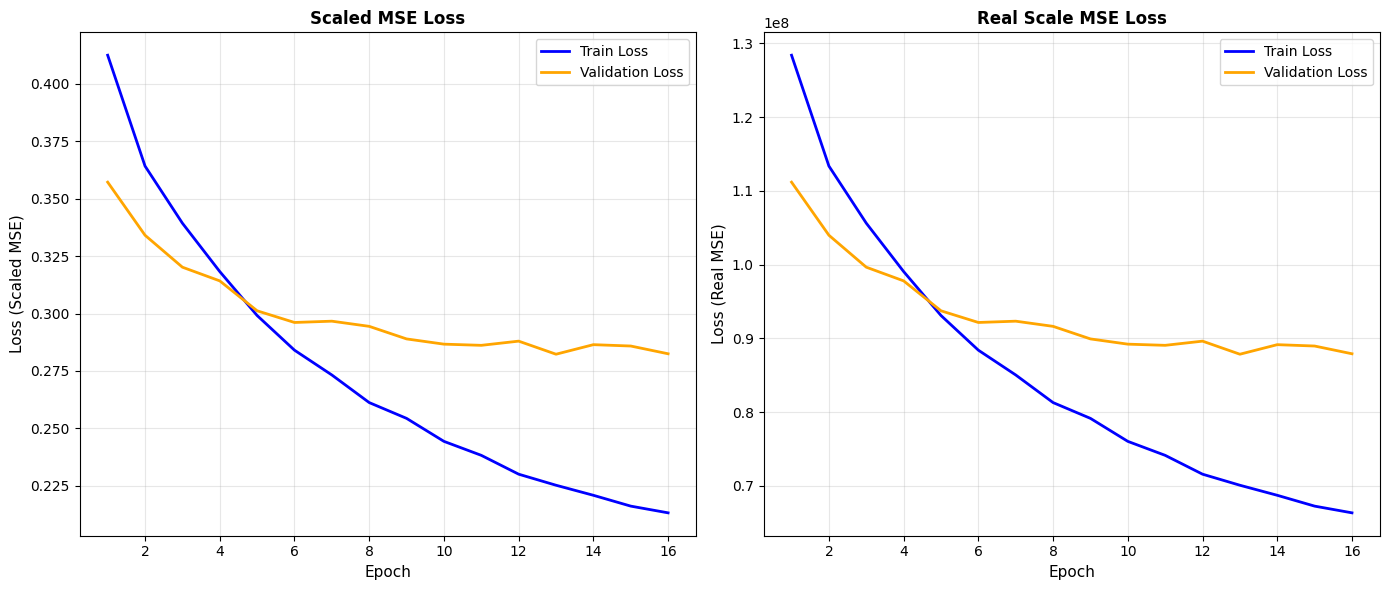

In [177]:
plot_losses_curves(history, loss_fn='mse')

#### **Best validation scaled MSE: 0.282282**

In [178]:
print_model_parameters_summary(model)

fc1.weight: 227,328 parameters, trainable=True
fc1.bias: 256 parameters, trainable=True
bn1.weight: 256 parameters, trainable=True
bn1.bias: 256 parameters, trainable=True
fc2.weight: 32,768 parameters, trainable=True
fc2.bias: 128 parameters, trainable=True
bn2.weight: 128 parameters, trainable=True
bn2.bias: 128 parameters, trainable=True
fc3.weight: 8,192 parameters, trainable=True
fc3.bias: 64 parameters, trainable=True
bn3.weight: 64 parameters, trainable=True
bn3.bias: 64 parameters, trainable=True
fc4.weight: 64 parameters, trainable=True
fc4.bias: 1 parameters, trainable=True
----------------------------------------
Total Parameters: 269,697


In [179]:
model_name = 'tfidf_800_50_int_unk_bs64_adam_lrs_no_hid256_dr30'
torch.save(trained_model.state_dict(), MODELS_DIR + f'{model_name}.pth')

In [180]:
evaluation_metrics = evaluate_single_input_model(
    model,
    test_loader,
    preprocessing_results['preprocessors']['target_scaler'],
    device,
    loss_fn_str='mse',
    model_name=model_name,
    results_dict=fulldata_best_models
)

### Complete process for pretrained embeddings approach with single input model

In [181]:
X_train, X_valid, X_test, y_train, y_valid, y_test = load_and_split_data()

/var/folders/t5/ct5bhs3j6k18hj1qyrkwmvj00000gp/T/ipykernel_71072/2592827893.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[X['Title'].isnull(), 'Title'] = 'Quality Improvement Manager'


Train set has 195814 entries
Validation set has 24477 entries
Test set has 24477 entries


In [182]:
preprocessing_results = preprocess_salary_data_with_embeddings(
    X_train, X_valid, X_test,
    y_train, y_valid, y_test,
    categorical_columns=['Category', 'ContractType', 'ContractTime'],
    high_cardinality_columns=['Company', 'LocationNormalized', 'SourceName'],
    title_column='Title',
    desc_column='FullDescription',
    embedding_model_name='all-MiniLM-L12-v2',
    batch_size=64,
    num_workers=0,
    categorical_na_strategy='constant',
    categorical_fill_value='unknown',
    high_card_na_strategy='constant',
    high_card_fill_value='unknown',
    save_artifacts=True,
    artifact_prefix='',
    multi_input=False
)
train_loader = preprocessing_results['train_loader']
valid_loader = preprocessing_results['valid_loader']
test_loader = preprocessing_results['test_loader']

Using embedding model: all-MiniLM-L12-v2
Generating embeddings (this may take a while)...


/Users/klipiec/Desktop/Internship/projects/project2_neural_networks/venv/lib/python3.13/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/klipiec/Desktop/Internship/projects/project2_neural_networks/venv/lib/python3.13/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/klipiec/Desktop/Internship/projects/project2_neural_networks/venv/lib/python3.13/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, 

Embeddings generated successfully!
Saving preprocessor artifacts...

Final feature shape: (195814, 806)
Categorical NA strategy: constant
High cardinality NA strategy: constant
Multi-input mode: False


In [ ]:
model = IntegratedNN(input_dim=preprocessing_results['feature_shape'][1]).to(device)
loss_fn = 'mse'
n_epochs = 25
optimizer_fn = 'adam'
patience = 3
lr = 0.001

trained_model, history, elapsed_time = train_single_input_model(
    model,
    train_loader,
    valid_loader,
    target_scaler=preprocessing_results['preprocessors']['target_scaler'],
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=False,
    seed=RANDOM_SEED
)

Epoch 1/25:
  Train - MSE: 0.4142, Real MSE: 128893760.00, Real RMSE: 11353.14
  Valid - MSE: 0.3535, Real MSE: 110007776.00, Real RMSE: 10488.46
Validation loss improved to 0.353480.
Epoch 2/25:
  Train - MSE: 0.3625, Real MSE: 112812968.00, Real RMSE: 10621.34
  Valid - MSE: 0.3281, Real MSE: 102121640.00, Real RMSE: 10105.53
Validation loss improved to 0.328140.
Epoch 3/25:
  Train - MSE: 0.3413, Real MSE: 106208584.00, Real RMSE: 10305.75
  Valid - MSE: 0.3126, Real MSE: 97289160.00, Real RMSE: 9863.53
Validation loss improved to 0.312612.
Epoch 4/25:
  Train - MSE: 0.3228, Real MSE: 100467784.00, Real RMSE: 10023.36
  Valid - MSE: 0.3042, Real MSE: 94671488.00, Real RMSE: 9729.93
Validation loss improved to 0.304201.
Epoch 5/25:
  Train - MSE: 0.3112, Real MSE: 96842384.00, Real RMSE: 9840.85
  Valid - MSE: 0.3010, Real MSE: 93676632.00, Real RMSE: 9678.67
Validation loss improved to 0.301004.
Epoch 6/25:
  Train - MSE: 0.2981, Real MSE: 92785680.00, Real RMSE: 9632.53
  Valid - M

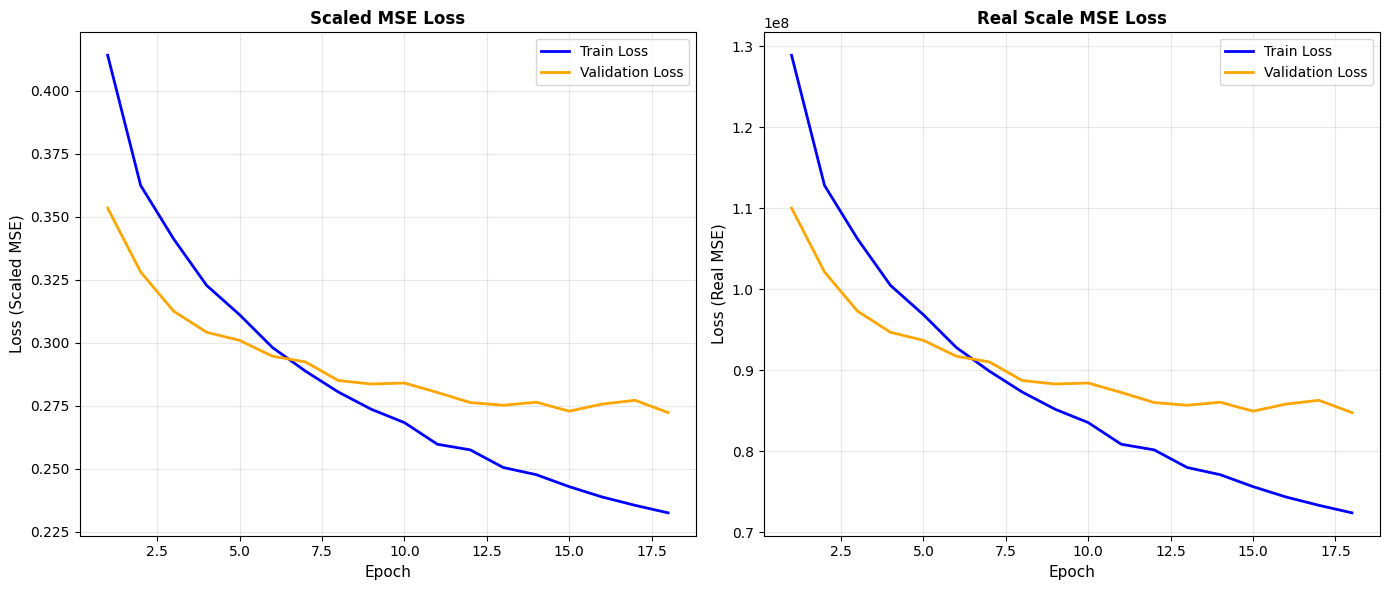

In [184]:
plot_losses_curves(history, loss_fn='mse')

#### **Best validation scaled MSE: 0.272884**

In [185]:
print_model_parameters_summary(model)

fc1.weight: 206,336 parameters, trainable=True
fc1.bias: 256 parameters, trainable=True
bn1.weight: 256 parameters, trainable=True
bn1.bias: 256 parameters, trainable=True
fc2.weight: 32,768 parameters, trainable=True
fc2.bias: 128 parameters, trainable=True
bn2.weight: 128 parameters, trainable=True
bn2.bias: 128 parameters, trainable=True
fc3.weight: 8,192 parameters, trainable=True
fc3.bias: 64 parameters, trainable=True
bn3.weight: 64 parameters, trainable=True
bn3.bias: 64 parameters, trainable=True
fc4.weight: 64 parameters, trainable=True
fc4.bias: 1 parameters, trainable=True
----------------------------------------
Total Parameters: 248,705


In [186]:
model_name = 'emb_int_unk_bs64_adam_lrs_no_hid256_dr30'
torch.save(model.state_dict(), MODELS_DIR + model_name + '.pth')

In [187]:
results = evaluate_single_input_model(
    model,
    test_loader,
    preprocessing_results['preprocessors']['target_scaler'],
    device,
    loss_fn_str='mse',
    model_name=model_name,
    results_dict=fulldata_best_models
)

### Complete process for pretrained embeddings approach with multi-input model

In [188]:
X_train, X_valid, X_test, y_train, y_valid, y_test = load_and_split_data()

/var/folders/t5/ct5bhs3j6k18hj1qyrkwmvj00000gp/T/ipykernel_71072/2592827893.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[X['Title'].isnull(), 'Title'] = 'Quality Improvement Manager'


Train set has 195814 entries
Validation set has 24477 entries
Test set has 24477 entries


In [189]:
preprocessing_results = preprocess_salary_data_with_embeddings(
    X_train, X_valid, X_test,
    y_train, y_valid, y_test,
    categorical_columns=['Category', 'ContractType', 'ContractTime'],
    high_cardinality_columns=['Company', 'LocationNormalized', 'SourceName'],
    title_column='Title',
    desc_column='FullDescription',
    embedding_model_name='all-MiniLM-L12-v2',
    batch_size=64,
    num_workers=0,
    categorical_na_strategy='constant',
    categorical_fill_value='unknown',
    high_card_na_strategy='constant',
    high_card_fill_value='unknown',
    save_artifacts=True,
    artifact_prefix='',
    multi_input=True
)
train_loader = preprocessing_results['train_loader']
valid_loader = preprocessing_results['valid_loader']
test_loader = preprocessing_results['test_loader']
embedding_dim = preprocessing_results['tabular_start_index']

Using embedding model: all-MiniLM-L12-v2
Generating embeddings (this may take a while)...


/Users/klipiec/Desktop/Internship/projects/project2_neural_networks/venv/lib/python3.13/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/klipiec/Desktop/Internship/projects/project2_neural_networks/venv/lib/python3.13/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, etc. This will raise an error in 1.8 instead of the current warning.
  warnings.warn(
/Users/klipiec/Desktop/Internship/projects/project2_neural_networks/venv/lib/python3.13/site-packages/sklearn/pipeline.py:61: FutureWarning: This Pipeline instance is not fitted yet. Call 'fit' with appropriate arguments before using other methods such as transform, predict, 

Embeddings generated successfully!
Embedding dimension: 384
Tabular start index: 768
Saving preprocessor artifacts...

Final feature shape: (195814, 806)
Categorical NA strategy: constant
High cardinality NA strategy: constant
Multi-input mode: True


In [ ]:
model = MultiInputNN(embedding_dim=embedding_dim, tabular_dim=preprocessing_results['feature_shape'][1] - embedding_dim).to(device)
loss_fn = 'mse'
n_epochs = 25
optimizer_fn = 'adam'
patience = 3
lr = 0.001

trained_model, history, elapsed_time = train_multi_input_model(
    model,
    train_loader,
    valid_loader,
    target_scaler=preprocessing_results['preprocessors']['target_scaler'],
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=False,
    seed=RANDOM_SEED
)

Epoch 1/25:
  Train - MSE: 0.4389, Real MSE: 136606304.00, Real RMSE: 11687.87
  Valid - MSE: 0.3497, Real MSE: 108837752.00, Real RMSE: 10432.53
Validation loss improved to 0.349721.
Epoch 2/25:
  Train - MSE: 0.3773, Real MSE: 117424888.00, Real RMSE: 10836.28
  Valid - MSE: 0.3316, Real MSE: 103189312.00, Real RMSE: 10158.21
Validation loss improved to 0.331571.
Epoch 3/25:
  Train - MSE: 0.3557, Real MSE: 110690224.00, Real RMSE: 10520.94
  Valid - MSE: 0.3139, Real MSE: 97700056.00, Real RMSE: 9884.33
Validation loss improved to 0.313933.
Epoch 4/25:
  Train - MSE: 0.3359, Real MSE: 104525456.00, Real RMSE: 10223.77
  Valid - MSE: 0.3210, Real MSE: 99886384.00, Real RMSE: 9994.32
No improvement in validation loss for 1 epoch.
Epoch 5/25:
  Train - MSE: 0.3239, Real MSE: 100810504.00, Real RMSE: 10040.44
  Valid - MSE: 0.2989, Real MSE: 93020336.00, Real RMSE: 9644.71
Validation loss improved to 0.298896.
Epoch 6/25:
  Train - MSE: 0.3106, Real MSE: 96666056.00, Real RMSE: 9831.89


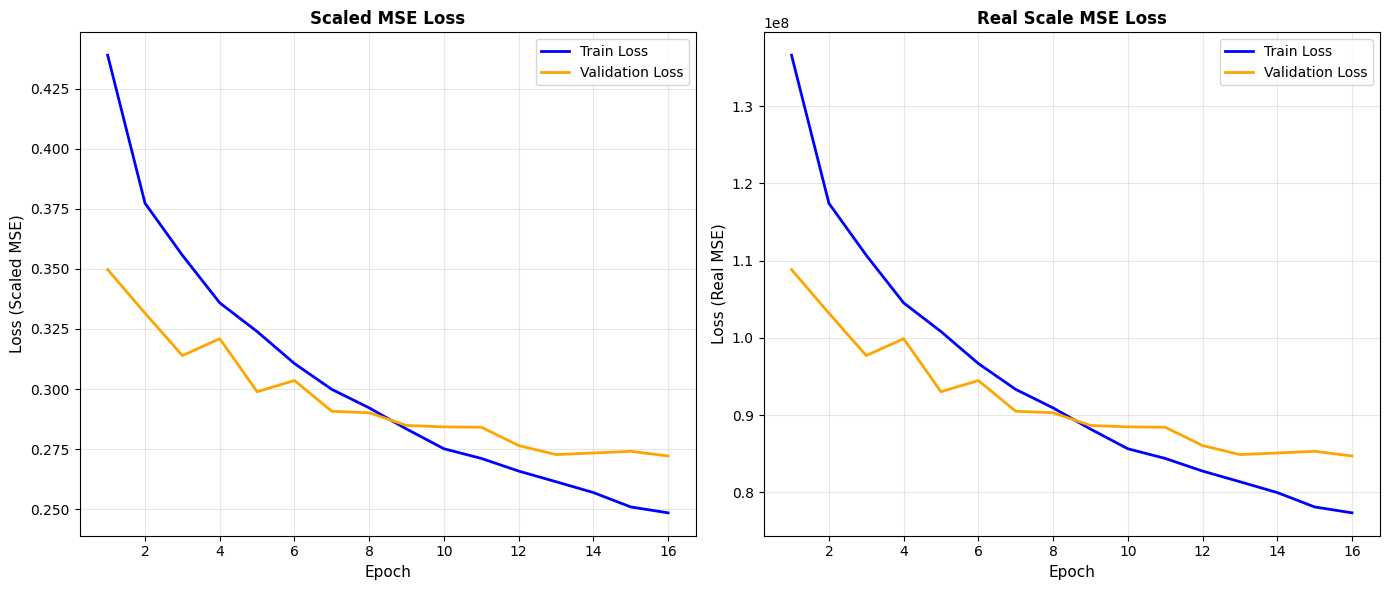

In [191]:
plot_losses_curves(history, loss_fn='mse')

#### **Best validation scaled MSE: 0.272726**

In [192]:
print_model_parameters_summary(model)

embedding_net.0.weight: 196,608 parameters, trainable=True
embedding_net.0.bias: 256 parameters, trainable=True
embedding_net.1.weight: 256 parameters, trainable=True
embedding_net.1.bias: 256 parameters, trainable=True
embedding_net.4.weight: 32,768 parameters, trainable=True
embedding_net.4.bias: 128 parameters, trainable=True
embedding_net.5.weight: 128 parameters, trainable=True
embedding_net.5.bias: 128 parameters, trainable=True
tabular_net.0.weight: 2,432 parameters, trainable=True
tabular_net.0.bias: 64 parameters, trainable=True
tabular_net.1.weight: 64 parameters, trainable=True
tabular_net.1.bias: 64 parameters, trainable=True
tabular_net.4.weight: 2,048 parameters, trainable=True
tabular_net.4.bias: 32 parameters, trainable=True
tabular_net.5.weight: 32 parameters, trainable=True
tabular_net.5.bias: 32 parameters, trainable=True
combined_net.0.weight: 20,480 parameters, trainable=True
combined_net.0.bias: 128 parameters, trainable=True
combined_net.1.weight: 128 parameters,

In [193]:
model_name = 'emb_multi_unk_bs64_adam_lrs_no_hid256_dr30'
torch.save(model.state_dict(), MODELS_DIR + model_name + '.pth')

In [194]:
results = evaluate_multi_input_model(
    model,
    test_loader,
    preprocessing_results['preprocessors']['target_scaler'],
    device,
    loss_fn_str='mse',
    model_name=model_name,
    results_dict=fulldata_best_models
)


### Complete process for multi-input model with TF-IDF

In [195]:
X_train, X_valid, X_test, y_train, y_valid, y_test = load_and_split_data()

/var/folders/t5/ct5bhs3j6k18hj1qyrkwmvj00000gp/T/ipykernel_71072/2592827893.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[X['Title'].isnull(), 'Title'] = 'Quality Improvement Manager'


Train set has 195814 entries
Validation set has 24477 entries
Test set has 24477 entries


In [196]:
preprocessing_results = preprocess_salary_data_with_tfidf(
    X_train, X_valid, X_test,
    y_train, y_valid, y_test,
    categorical_columns=['Category', 'ContractType', 'ContractTime'],
    high_cardinality_columns=['Company', 'LocationNormalized', 'SourceName'],
    title_max_features=50,
    desc_max_features=800,
    batch_size=64,
    num_workers=0,
    categorical_na_strategy='constant',  # 'constant' or 'most_frequent'
    categorical_fill_value='unknown',    # used when strategy='constant'
    high_card_na_strategy='constant',    # 'constant' or 'most_frequent'
    high_card_fill_value='unknown',      # used when strategy='constant'
    save_artifacts=True,
    artifact_prefix='',
    multi_input=True
)
train_loader = preprocessing_results['train_loader']
valid_loader = preprocessing_results['valid_loader']
test_loader = preprocessing_results['test_loader']
embedding_dim = preprocessing_results['tabular_start_index']

Title TF-IDF dimension: 50
Description TF-IDF dimension: 800
Tabular start index: 850
Final feature shape: (195814, 888)
Categorical NA strategy: constant
High cardinality NA strategy: constant
Title: max_features=50, use_svd=False
Description: max_features=800, use_svd=False
Multi-input mode: True


In [ ]:
model = MultiInputNN(embedding_dim=embedding_dim, tabular_dim=preprocessing_results['feature_shape'][1] - embedding_dim).to(device)
loss_fn = 'mse'
n_epochs = 25
optimizer_fn = 'adam'
patience = 3
lr = 0.001

trained_model, history, elapsed_time = train_multi_input_model(
    model,
    train_loader,
    valid_loader,
    target_scaler=preprocessing_results['preprocessors']['target_scaler'],
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=False,
    seed=RANDOM_SEED
)

Epoch 1/25:
  Train - MSE: 0.4354, Real MSE: 135513408.00, Real RMSE: 11641.02
  Valid - MSE: 0.3734, Real MSE: 116214744.00, Real RMSE: 10780.29
Validation loss improved to 0.373424.
Epoch 2/25:
  Train - MSE: 0.3770, Real MSE: 117330856.00, Real RMSE: 10831.94
  Valid - MSE: 0.3407, Real MSE: 106020528.00, Real RMSE: 10296.63
Validation loss improved to 0.340668.
Epoch 3/25:
  Train - MSE: 0.3503, Real MSE: 109021392.00, Real RMSE: 10441.33
  Valid - MSE: 0.3339, Real MSE: 103922600.00, Real RMSE: 10194.24
Validation loss improved to 0.333927.
Epoch 4/25:
  Train - MSE: 0.3241, Real MSE: 100855056.00, Real RMSE: 10042.66
  Valid - MSE: 0.3089, Real MSE: 96148200.00, Real RMSE: 9805.52
Validation loss improved to 0.308946.
Epoch 5/25:
  Train - MSE: 0.3054, Real MSE: 95042400.00, Real RMSE: 9748.97
  Valid - MSE: 0.3060, Real MSE: 95217504.00, Real RMSE: 9757.95
Validation loss improved to 0.305956.
Epoch 6/25:
  Train - MSE: 0.2888, Real MSE: 89881896.00, Real RMSE: 9480.61
  Valid -

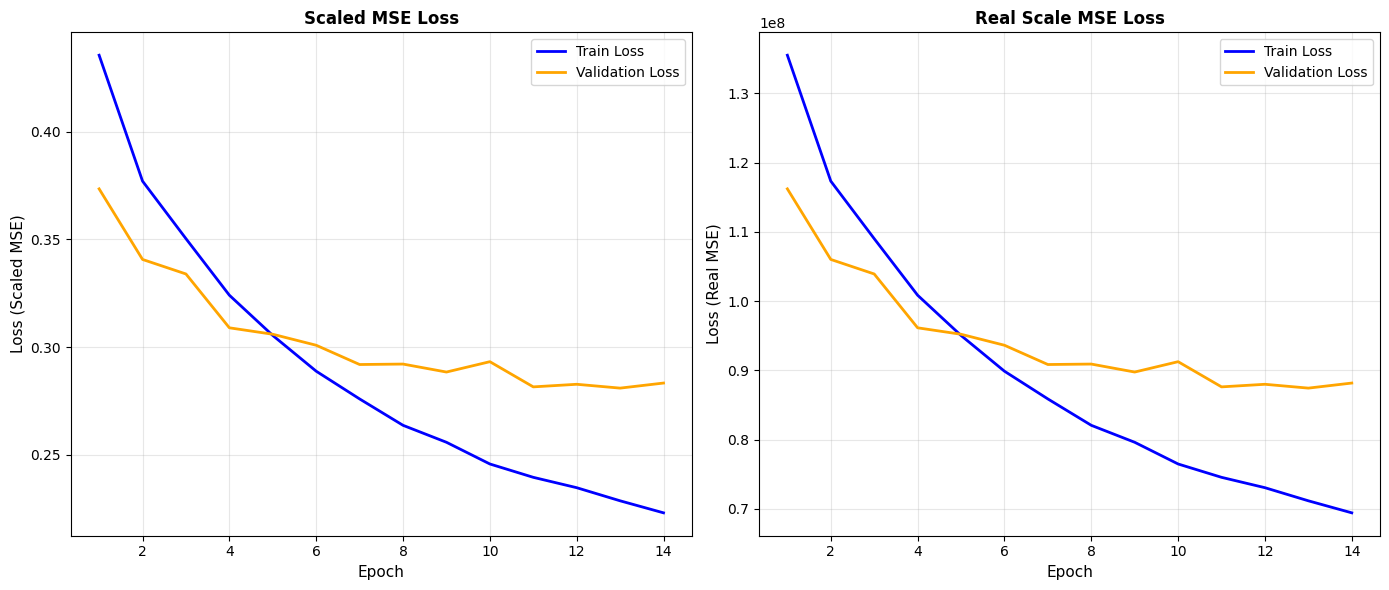

In [198]:
plot_losses_curves(history, loss_fn='mse')

#### **Best validation scaled MSE: 0.281541.**

In [199]:
model_name = 'tfidf_800_50_multi_unk_bs64_adam_lrs_no_hid256_dr30'
torch.save(model.state_dict(), MODELS_DIR + model_name + '.pth')

In [200]:
results = evaluate_multi_input_model(
    model,
    test_loader,
    preprocessing_results['preprocessors']['target_scaler'],
    device,
    loss_fn_str='mse',
    model_name=model_name,
    results_dict=fulldata_best_models
)


### Results summary


We can see that pretrained embeddings give better results than TF-IDF approach. However, the difference is not very large and pretrained embeddings take longer to prepare data for training. Multi-input models do not perform better than single-input models in this case.


### Tuning hyperparameters for single-input model with TF-IDF

#### Filling missing values with most frequent value instead of 'Unknown'

/var/folders/t5/ct5bhs3j6k18hj1qyrkwmvj00000gp/T/ipykernel_71072/2592827893.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[X['Title'].isnull(), 'Title'] = 'Quality Improvement Manager'


Train set has 195814 entries
Validation set has 24477 entries
Test set has 24477 entries
Final feature shape: (195814, 886)
Categorical NA strategy: most_frequent
High cardinality NA strategy: most_frequent
Title: max_features=50, use_svd=False
Description: max_features=800, use_svd=False
Multi-input mode: False
Epoch 1/25:
  Train - MSE: 0.4096, Real MSE: 127483768.00, Real RMSE: 11290.87
  Valid - MSE: 0.3623, Real MSE: 112766968.00, Real RMSE: 10619.18
Validation loss improved to 0.362346.
Epoch 2/25:
  Train - MSE: 0.3596, Real MSE: 111905392.00, Real RMSE: 10578.53
  Valid - MSE: 0.3390, Real MSE: 105510672.00, Real RMSE: 10271.84
Validation loss improved to 0.339030.
Epoch 3/25:
  Train - MSE: 0.3343, Real MSE: 104030600.00, Real RMSE: 10199.54
  Valid - MSE: 0.3168, Real MSE: 98582768.00, Real RMSE: 9928.89
Validation loss improved to 0.316769.
Epoch 4/25:
  Train - MSE: 0.3127, Real MSE: 97325992.00, Real RMSE: 9865.39
  Valid - MSE: 0.3118, Real MSE: 97051040.00, Real RMSE: 98

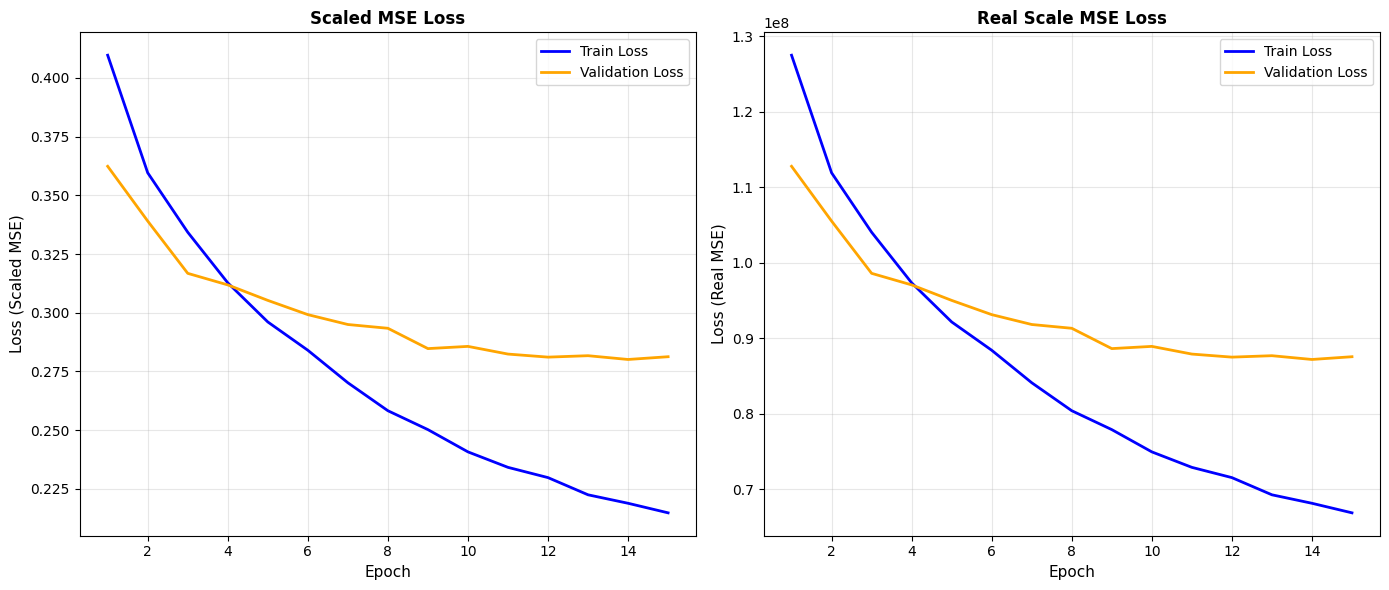

In [ ]:
X_train, X_valid, X_test, y_train, y_valid, y_test = load_and_split_data()

preprocessing_results = preprocess_salary_data_with_tfidf(
    X_train, X_valid, X_test,
    y_train, y_valid, y_test,
    categorical_columns=['Category', 'ContractType', 'ContractTime'],
    high_cardinality_columns=['Company', 'LocationNormalized', 'SourceName'],
    title_max_features=50,
    desc_max_features=800,
    batch_size=64,
    num_workers=0,
    categorical_na_strategy='most_frequent',  # 'constant' or 'most_frequent'
    high_card_na_strategy='most_frequent',    # 'constant' or 'most_frequent'
    save_artifacts=False
)
train_loader = preprocessing_results['train_loader']
valid_loader = preprocessing_results['valid_loader']
test_loader = preprocessing_results['test_loader']

model = IntegratedNN(input_dim=preprocessing_results['feature_shape'][1]).to(device)
loss_fn = 'mse'
n_epochs = 25
optimizer_fn = 'adam'
patience = 3
lr = 0.001

trained_model, history, elapsed_time = train_single_input_model(
    model,
    train_loader,
    valid_loader,
    target_scaler=preprocessing_results['preprocessors']['target_scaler'],
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=False,
    seed=RANDOM_SEED
)

plot_losses_curves(history, loss_fn='mse')

**Validation Scaled MSE result: 0.281541 - better result.** From now we will use this approach.

In [202]:
print_model_parameters_summary(model)

fc1.weight: 226,816 parameters, trainable=True
fc1.bias: 256 parameters, trainable=True
bn1.weight: 256 parameters, trainable=True
bn1.bias: 256 parameters, trainable=True
fc2.weight: 32,768 parameters, trainable=True
fc2.bias: 128 parameters, trainable=True
bn2.weight: 128 parameters, trainable=True
bn2.bias: 128 parameters, trainable=True
fc3.weight: 8,192 parameters, trainable=True
fc3.bias: 64 parameters, trainable=True
bn3.weight: 64 parameters, trainable=True
bn3.bias: 64 parameters, trainable=True
fc4.weight: 64 parameters, trainable=True
fc4.bias: 1 parameters, trainable=True
----------------------------------------
Total Parameters: 269,185


In [203]:
model_name = 'tfidf_800_50_int_mf_bs64_adam_lrs_no_hid256_dr30'
torch.save(trained_model.state_dict(), MODELS_DIR + f'{model_name}.pth')

In [204]:
results = evaluate_single_input_model(
    model,
    test_loader,
    preprocessing_results['preprocessors']['target_scaler'],
    device,
    loss_fn_str='mse',
    model_name=model_name,
    results_dict=fulldata_best_models
)


#### Using Simpler Model with one less layer and less neurons

Epoch 1/25:
  Train - MSE: 0.4346, Real MSE: 135242272.00, Real RMSE: 11629.37
  Valid - MSE: 0.3664, Real MSE: 114013352.00, Real RMSE: 10677.70
Validation loss improved to 0.366351.
Epoch 2/25:
  Train - MSE: 0.3912, Real MSE: 121745880.00, Real RMSE: 11033.85
  Valid - MSE: 0.3555, Real MSE: 110631808.00, Real RMSE: 10518.17
Validation loss improved to 0.355485.
Epoch 3/25:
  Train - MSE: 0.3736, Real MSE: 116281024.00, Real RMSE: 10783.37
  Valid - MSE: 0.3477, Real MSE: 108216976.00, Real RMSE: 10402.74
Validation loss improved to 0.347726.
Epoch 4/25:
  Train - MSE: 0.3635, Real MSE: 113133672.00, Real RMSE: 10636.43
  Valid - MSE: 0.3379, Real MSE: 105162680.00, Real RMSE: 10254.89
Validation loss improved to 0.337912.
Epoch 5/25:
  Train - MSE: 0.3535, Real MSE: 110013088.00, Real RMSE: 10488.71
  Valid - MSE: 0.3302, Real MSE: 102758040.00, Real RMSE: 10136.96
Validation loss improved to 0.330185.
Epoch 6/25:
  Train - MSE: 0.3465, Real MSE: 107825176.00, Real RMSE: 10383.89
 

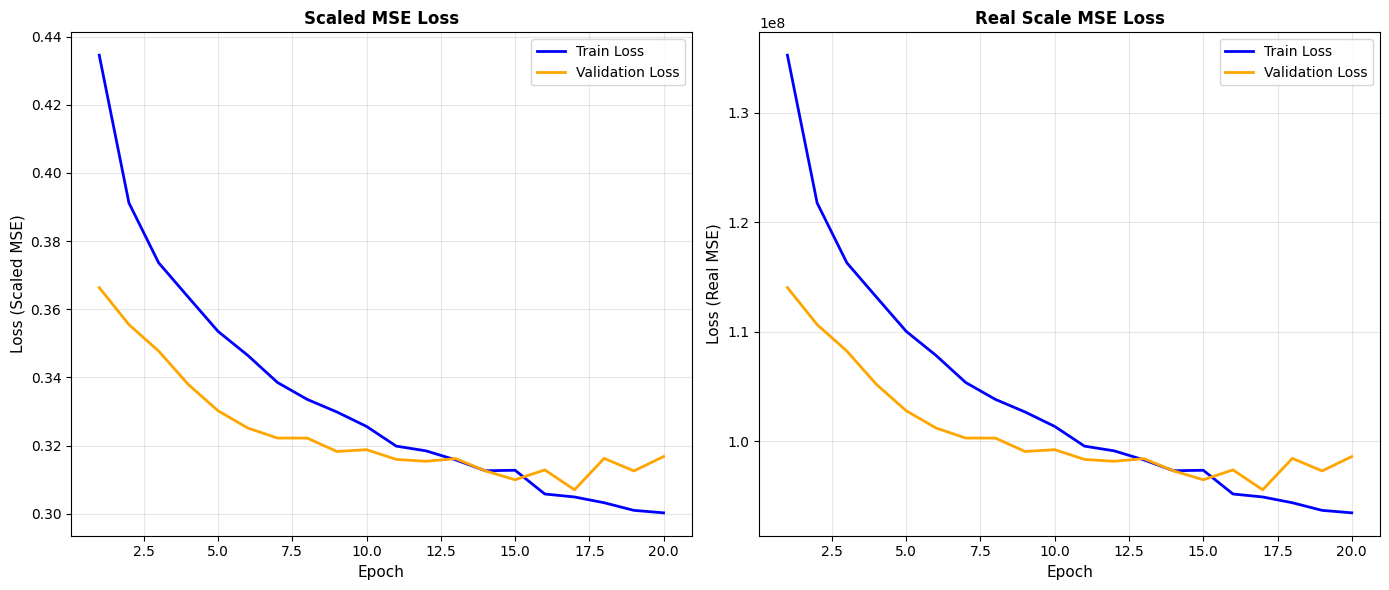

In [ ]:
model = SimpleRegressorWithNormalization(input_dim=preprocessing_results['feature_shape'][1], hidden_size=64).to(device)
loss_fn = 'mse'
n_epochs = 25
optimizer_fn = 'adam'
patience = 3
lr = 0.001

trained_model, history, elapsed_time = train_single_input_model(
    model,
    train_loader,
    valid_loader,
    target_scaler=preprocessing_results['preprocessors']['target_scaler'],
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=False,
    seed=RANDOM_SEED
)

plot_losses_curves(history, loss_fn='mse')

**0.307010 - Worse result.** We will not use this approach in further experiments.

In [206]:
print_model_parameters_summary(model)

fc1.weight: 56,704 parameters, trainable=True
fc1.bias: 64 parameters, trainable=True
bn1.weight: 64 parameters, trainable=True
bn1.bias: 64 parameters, trainable=True
fc2.weight: 2,048 parameters, trainable=True
fc2.bias: 32 parameters, trainable=True
bn2.weight: 32 parameters, trainable=True
bn2.bias: 32 parameters, trainable=True
fc3.weight: 32 parameters, trainable=True
fc3.bias: 1 parameters, trainable=True
----------------------------------------
Total Parameters: 59,073


In [207]:
model_name = 'tfidf_800_50_srbn_unk_bs64_adam_lrs_no_hid64_dr30'
torch.save(trained_model.state_dict(), MODELS_DIR + f'{model_name}.pth')

results = evaluate_single_input_model(
    model,
    test_loader,
    preprocessing_results['preprocessors']['target_scaler'],
    device,
    loss_fn_str='mse',
    model_name=model_name,
    results_dict=fulldata_best_models
)

#### More complex model but with 2 times fewer neurons in each layer

Epoch 1/25:
  Train - MSE: 0.4279, Real MSE: 133155168.00, Real RMSE: 11539.29
  Valid - MSE: 0.3648, Real MSE: 113542760.00, Real RMSE: 10655.64
Validation loss improved to 0.364839.
Epoch 2/25:
  Train - MSE: 0.3785, Real MSE: 117789368.00, Real RMSE: 10853.08
  Valid - MSE: 0.3501, Real MSE: 108966880.00, Real RMSE: 10438.72
Validation loss improved to 0.350135.
Epoch 3/25:
  Train - MSE: 0.3572, Real MSE: 111170776.00, Real RMSE: 10543.75
  Valid - MSE: 0.3325, Real MSE: 103465760.00, Real RMSE: 10171.81
Validation loss improved to 0.332459.
Epoch 4/25:
  Train - MSE: 0.3402, Real MSE: 105866272.00, Real RMSE: 10289.13
  Valid - MSE: 0.3292, Real MSE: 102460968.00, Real RMSE: 10122.30
Validation loss improved to 0.329231.
Epoch 5/25:
  Train - MSE: 0.3260, Real MSE: 101446128.00, Real RMSE: 10072.05
  Valid - MSE: 0.3207, Real MSE: 99791520.00, Real RMSE: 9989.57
Validation loss improved to 0.320653.
Epoch 6/25:
  Train - MSE: 0.3156, Real MSE: 98207312.00, Real RMSE: 9909.96
  Val

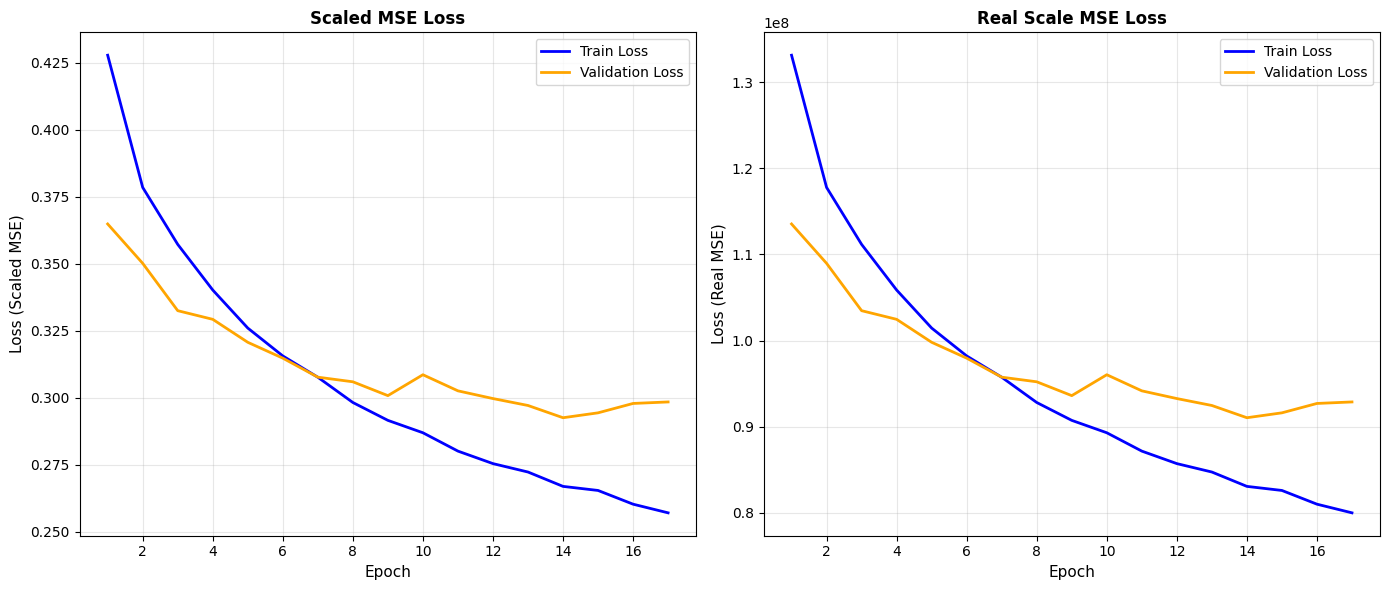

In [208]:
model = IntegratedNN(input_dim=preprocessing_results['feature_shape'][1], hidden_size=128).to(device)
loss_fn = 'mse'
n_epochs = 25
optimizer_fn = 'adam'
patience = 3
lr = 0.001

trained_model, history, elapsed_time = train_single_input_model(
    model,
    train_loader,
    valid_loader,
    preprocessing_results['preprocessors']['target_scaler'],
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=False,
    seed=RANDOM_SEED
)

plot_losses_curves(history, loss_fn='mse')

**0.292486- Worse result.** 

In [209]:
print_model_parameters_summary(model)

fc1.weight: 113,408 parameters, trainable=True
fc1.bias: 128 parameters, trainable=True
bn1.weight: 128 parameters, trainable=True
bn1.bias: 128 parameters, trainable=True
fc2.weight: 8,192 parameters, trainable=True
fc2.bias: 64 parameters, trainable=True
bn2.weight: 64 parameters, trainable=True
bn2.bias: 64 parameters, trainable=True
fc3.weight: 2,048 parameters, trainable=True
fc3.bias: 32 parameters, trainable=True
bn3.weight: 32 parameters, trainable=True
bn3.bias: 32 parameters, trainable=True
fc4.weight: 32 parameters, trainable=True
fc4.bias: 1 parameters, trainable=True
----------------------------------------
Total Parameters: 124,353


In [210]:
model_name = 'tfidf_800_50_int_unk_bs64_adam_lrs_no_hid128_dr30'
torch.save(trained_model.state_dict(), MODELS_DIR + f'{model_name}.pth')

results = evaluate_single_input_model(
    model,
    test_loader,
    preprocessing_results['preprocessors']['target_scaler'],
    device,
    loss_fn_str='mse',
    model_name=model_name,
    results_dict=fulldata_best_models
)

#### Using learning rate scheduler

Epoch 1/25:
  Train - MSE: 0.4130, Real MSE: 128521200.00, Real RMSE: 11336.72
  Valid - MSE: 0.3659, Real MSE: 113862784.00, Real RMSE: 10670.65
  Learning Rate: 0.001000
Validation loss improved to 0.365867.
Epoch 2/25:
  Train - MSE: 0.3596, Real MSE: 111913496.00, Real RMSE: 10578.92
  Valid - MSE: 0.3315, Real MSE: 103163672.00, Real RMSE: 10156.95
  Learning Rate: 0.001000
Validation loss improved to 0.331489.
Epoch 3/25:
  Train - MSE: 0.3358, Real MSE: 104513952.00, Real RMSE: 10223.21
  Valid - MSE: 0.3202, Real MSE: 99639200.00, Real RMSE: 9981.94
  Learning Rate: 0.001000
Validation loss improved to 0.320164.
Epoch 4/25:
  Train - MSE: 0.3145, Real MSE: 97869344.00, Real RMSE: 9892.89
  Valid - MSE: 0.3112, Real MSE: 96835856.00, Real RMSE: 9840.52
  Learning Rate: 0.001000
Validation loss improved to 0.311156.
Epoch 5/25:
  Train - MSE: 0.2983, Real MSE: 92825136.00, Real RMSE: 9634.58
  Valid - MSE: 0.3029, Real MSE: 94274056.00, Real RMSE: 9709.48
  Learning Rate: 0.00100

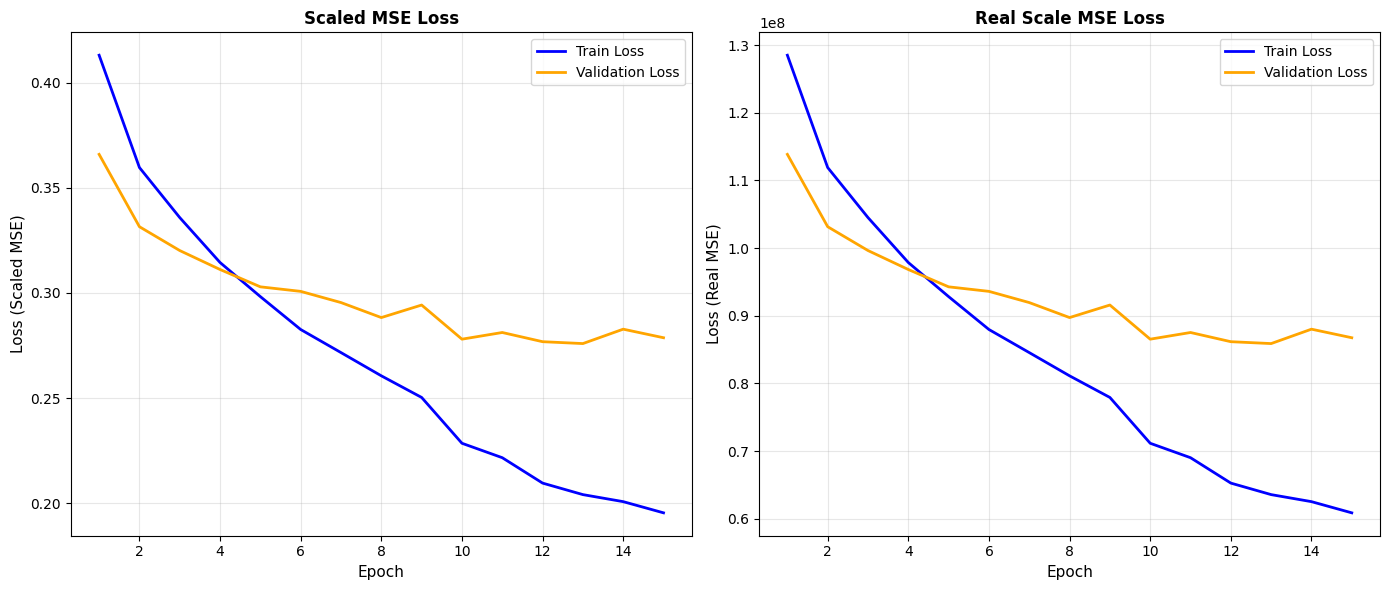

In [ ]:
model = IntegratedNN(input_dim=preprocessing_results['feature_shape'][1]).to(device)
loss_fn = 'mse'
n_epochs = 25
optimizer_fn = 'adam'
patience = 3
lr = 0.001

trained_model, history, elapsed_time = train_single_input_model(
    model,
    train_loader,
    valid_loader,
    target_scaler=preprocessing_results['preprocessors']['target_scaler'],
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=0,
    scheduler_factor=0.5,
    seed=RANDOM_SEED
)

plot_losses_curves(history, loss_fn='mse')

**0.276861 - better result - using patience=0, factor=0.5 for scheduler may help stabilize training**

In [212]:
print_model_parameters_summary(model)

fc1.weight: 226,816 parameters, trainable=True
fc1.bias: 256 parameters, trainable=True
bn1.weight: 256 parameters, trainable=True
bn1.bias: 256 parameters, trainable=True
fc2.weight: 32,768 parameters, trainable=True
fc2.bias: 128 parameters, trainable=True
bn2.weight: 128 parameters, trainable=True
bn2.bias: 128 parameters, trainable=True
fc3.weight: 8,192 parameters, trainable=True
fc3.bias: 64 parameters, trainable=True
bn3.weight: 64 parameters, trainable=True
bn3.bias: 64 parameters, trainable=True
fc4.weight: 64 parameters, trainable=True
fc4.bias: 1 parameters, trainable=True
----------------------------------------
Total Parameters: 269,185


In [213]:
model_name = 'tfidf_800_50_int_unk_bs64_adam_lrs_hid256_dr30'
torch.save(trained_model.state_dict(), MODELS_DIR + f'{model_name}.pth')

results = evaluate_single_input_model(
    model,
    test_loader,
    preprocessing_results['preprocessors']['target_scaler'],
    device,
    loss_fn_str='mse',
    model_name=model_name,
    results_dict=fulldata_best_models
)

#### Using other optimizer - SGD with momentum=0.9

Epoch 1/50:
  Train - MSE: 0.4741, Real MSE: 147557856.00, Real RMSE: 12147.34
  Valid - MSE: 0.4096, Real MSE: 127486216.00, Real RMSE: 11290.98
  Learning Rate: 0.005000
Validation loss improved to 0.409642.
Epoch 2/50:
  Train - MSE: 0.4176, Real MSE: 129953872.00, Real RMSE: 11399.73
  Valid - MSE: 0.3778, Real MSE: 117564872.00, Real RMSE: 10842.73
  Learning Rate: 0.005000
Validation loss improved to 0.377763.
Epoch 3/50:
  Train - MSE: 0.3990, Real MSE: 124185048.00, Real RMSE: 11143.83
  Valid - MSE: 0.3775, Real MSE: 117488352.00, Real RMSE: 10839.20
  Learning Rate: 0.005000
No improvement in validation loss for 1 epoch.
Epoch 4/50:
  Train - MSE: 0.3895, Real MSE: 121206760.00, Real RMSE: 11009.39
  Valid - MSE: 0.3717, Real MSE: 115692384.00, Real RMSE: 10756.04
  Learning Rate: 0.005000
Validation loss improved to 0.371746.
Epoch 5/50:
  Train - MSE: 0.3813, Real MSE: 118660512.00, Real RMSE: 10893.14
  Valid - MSE: 0.3762, Real MSE: 117069720.00, Real RMSE: 10819.88
  Lea

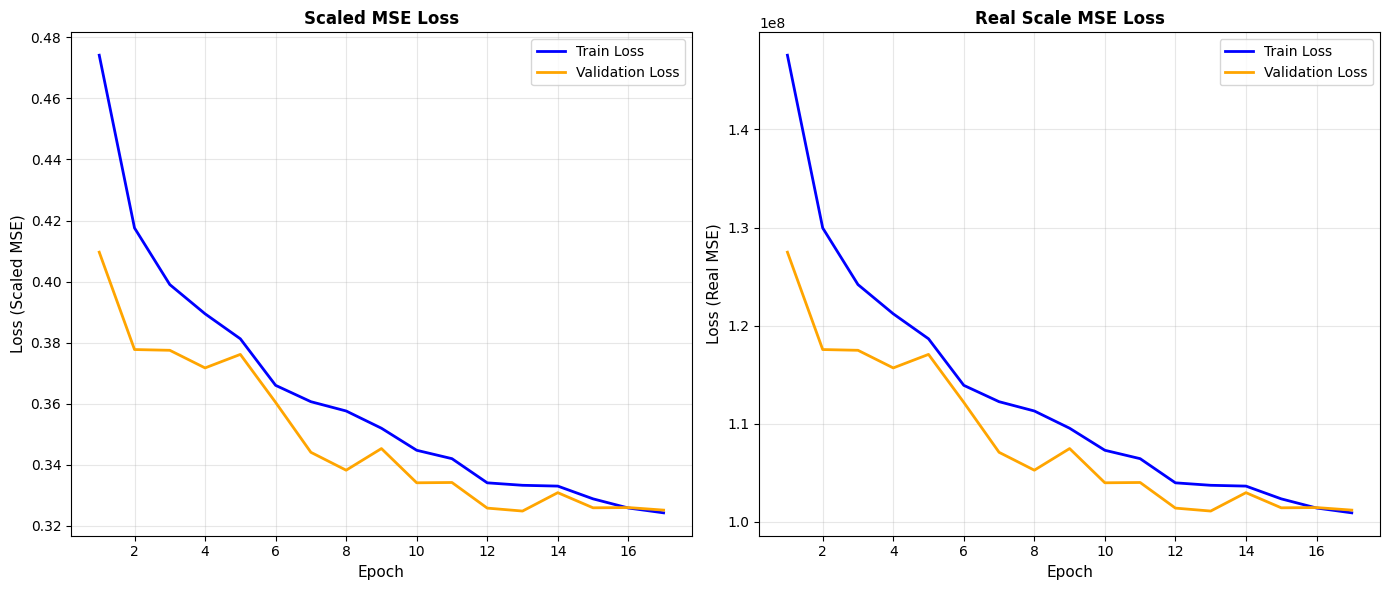

In [ ]:
model = IntegratedNN(input_dim=preprocessing_results['feature_shape'][1]).to(device)
loss_fn = 'mse'
n_epochs = 50
optimizer_fn = 'sgd'
patience = 5
lr = 0.005

trained_model, history, elapsed_time = train_single_input_model(
    model,
    train_loader,
    valid_loader,
    target_scaler=preprocessing_results['preprocessors']['target_scaler'],
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=0,
    scheduler_factor=0.5,
    seed=RANDOM_SEED
)

plot_losses_curves(history, loss_fn='mse')

**Adam seems to work better - it is faster to converge.**

In [215]:
print_model_parameters_summary(model)

fc1.weight: 226,816 parameters, trainable=True
fc1.bias: 256 parameters, trainable=True
bn1.weight: 256 parameters, trainable=True
bn1.bias: 256 parameters, trainable=True
fc2.weight: 32,768 parameters, trainable=True
fc2.bias: 128 parameters, trainable=True
bn2.weight: 128 parameters, trainable=True
bn2.bias: 128 parameters, trainable=True
fc3.weight: 8,192 parameters, trainable=True
fc3.bias: 64 parameters, trainable=True
bn3.weight: 64 parameters, trainable=True
bn3.bias: 64 parameters, trainable=True
fc4.weight: 64 parameters, trainable=True
fc4.bias: 1 parameters, trainable=True
----------------------------------------
Total Parameters: 269,185


In [216]:
model_name = 'tfidf_800_50_int_unk_bs64_sgd_lrs_no_hid256_dr30'
torch.save(trained_model.state_dict(), MODELS_DIR + f'{model_name}.pth')

results = evaluate_single_input_model(
    model,
    test_loader,
    preprocessing_results['preprocessors']['target_scaler'],
    device,
    loss_fn_str='mse',
    model_name=model_name,
    results_dict=fulldata_best_models
)

Ok, so the best model for single-input with TF-IDF is the one with filling missing values with most frequent value, IntegratedNN model, batch size of 64, Adam optimizer and learning rate scheduler.

Now I will try to modify TfidfVectorizer parameters.

#### Adding svd to reduce dimensionality of text features

Final feature shape: (195814, 246)
Categorical NA strategy: most_frequent
High cardinality NA strategy: most_frequent
Title: max_features=50, use_svd=True, n_components=10
Description: max_features=800, use_svd=True, n_components=200
Multi-input mode: False
Epoch 1/25:
  Train - MSE: 0.4484, Real MSE: 139555248.00, Real RMSE: 11813.35
  Valid - MSE: 0.3997, Real MSE: 124390184.00, Real RMSE: 11153.04
  Learning Rate: 0.001000
Validation loss improved to 0.399694.
Epoch 2/25:
  Train - MSE: 0.4015, Real MSE: 124960072.00, Real RMSE: 11178.55
  Valid - MSE: 0.3714, Real MSE: 115591224.00, Real RMSE: 10751.34
  Learning Rate: 0.001000
Validation loss improved to 0.371421.
Epoch 3/25:
  Train - MSE: 0.3823, Real MSE: 118982120.00, Real RMSE: 10907.89
  Valid - MSE: 0.3586, Real MSE: 111586584.00, Real RMSE: 10563.46
  Learning Rate: 0.001000
Validation loss improved to 0.358553.
Epoch 4/25:
  Train - MSE: 0.3697, Real MSE: 115046104.00, Real RMSE: 10725.96
  Valid - MSE: 0.3483, Real MSE: 

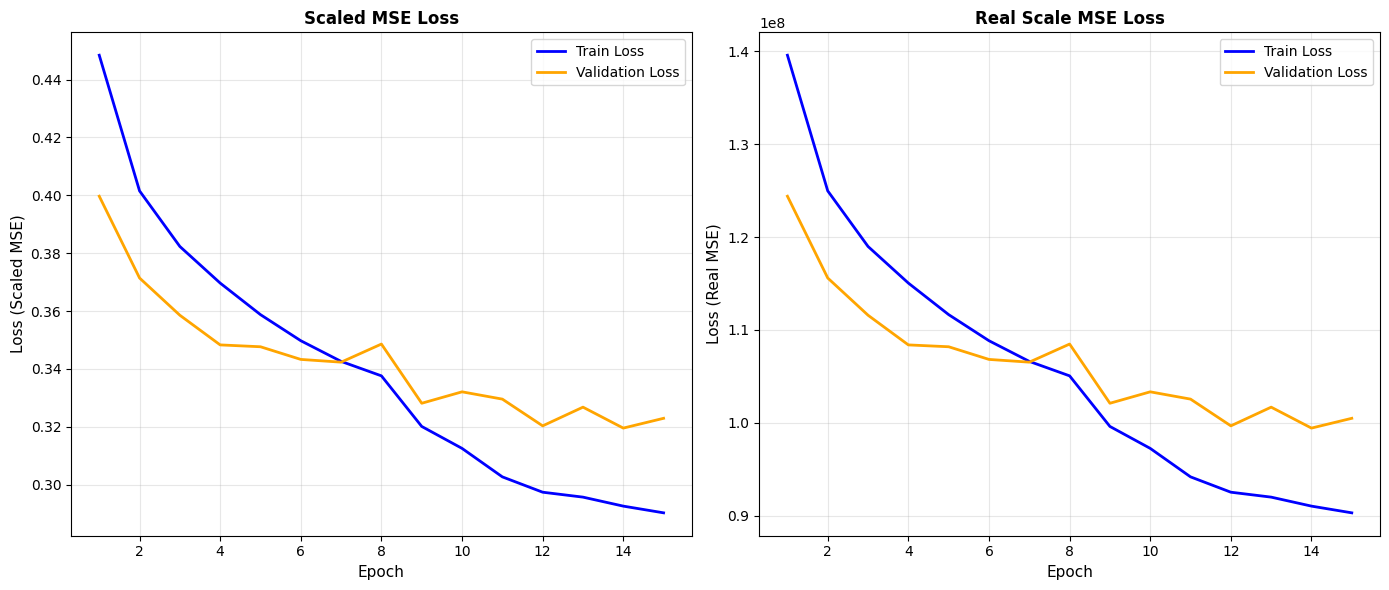

In [ ]:
preprocessing_results = preprocess_salary_data_with_tfidf(
    X_train, X_valid, X_test,
    y_train, y_valid, y_test,
    categorical_columns=['Category', 'ContractType', 'ContractTime'],
    high_cardinality_columns=['Company', 'LocationNormalized', 'SourceName'],
    title_max_features=50,
    desc_max_features=800,
    desc_use_svd=True,
    desc_n_components=200,
    title_use_svd=True,
    title_n_components=10,
    batch_size=64,
    num_workers=0,
    categorical_na_strategy='most_frequent',  # 'constant' or 'most_frequent'
    high_card_na_strategy='most_frequent',    # 'constant' or 'most_frequent'
    save_artifacts=False
)
train_loader = preprocessing_results['train_loader']
valid_loader = preprocessing_results['valid_loader']
test_loader = preprocessing_results['test_loader']

model = IntegratedNN(input_dim=preprocessing_results['feature_shape'][1]).to(device)
loss_fn = 'mse'
n_epochs = 25
optimizer_fn = 'adam'
patience = 3
lr = 0.001

trained_model, history, elapsed_time = train_single_input_model(
    model,
    train_loader,
    valid_loader,
    target_scaler=preprocessing_results['preprocessors']['target_scaler'],
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=0,
    scheduler_factor=0.5,
    seed=RANDOM_SEED
)

plot_losses_curves(history, loss_fn='mse')


**The validation Scaled MSE is 0.320322 - definitely worse result - although the training was much faster. We need to select between performance and training time.**

In [218]:
print_model_parameters_summary(model)

fc1.weight: 62,976 parameters, trainable=True
fc1.bias: 256 parameters, trainable=True
bn1.weight: 256 parameters, trainable=True
bn1.bias: 256 parameters, trainable=True
fc2.weight: 32,768 parameters, trainable=True
fc2.bias: 128 parameters, trainable=True
bn2.weight: 128 parameters, trainable=True
bn2.bias: 128 parameters, trainable=True
fc3.weight: 8,192 parameters, trainable=True
fc3.bias: 64 parameters, trainable=True
bn3.weight: 64 parameters, trainable=True
bn3.bias: 64 parameters, trainable=True
fc4.weight: 64 parameters, trainable=True
fc4.bias: 1 parameters, trainable=True
----------------------------------------
Total Parameters: 105,345


In [219]:
model_name = 'tfidf_scd_200_10_int_unk_bs64_adam_lrs_no_hid256_dr30'
torch.save(trained_model.state_dict(), MODELS_DIR + f'{model_name}.pth')
results = evaluate_single_input_model(
    model,
    test_loader,
    preprocessing_results['preprocessors']['target_scaler'],
    device,
    loss_fn_str='mse',  
    model_name=model_name,
    results_dict=fulldata_best_models
)

#### Using remove stop words for title and description in TfidfVectorizer

In [41]:
X_train, X_valid, X_test, y_train, y_valid, y_test = load_and_split_data()

/var/folders/t5/ct5bhs3j6k18hj1qyrkwmvj00000gp/T/ipykernel_5789/1698176672.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[X['Title'].isnull(), 'Title'] = 'Quality Improvement Manager'


Train set has 195814 entries
Validation set has 24477 entries
Test set has 24477 entries


Final feature shape: (195814, 886)
Categorical NA strategy: most_frequent
High cardinality NA strategy: most_frequent
Title: max_features=50, use_svd=False
Description: max_features=800, use_svd=False
Multi-input mode: False
Log mode: False
Epoch 1/25:
  Train - MSE: 0.4010, Real MSE: 124781896.00, Real RMSE: 11170.58
  Valid - MSE: 0.3416, Real MSE: 106324504.00, Real RMSE: 10311.38
  Learning Rate: 0.001000
Validation loss improved to 0.341645.
Epoch 2/25:
  Train - MSE: 0.3497, Real MSE: 108830584.00, Real RMSE: 10432.19
  Valid - MSE: 0.3251, Real MSE: 101177056.00, Real RMSE: 10058.68
  Learning Rate: 0.001000
Validation loss improved to 0.325105.
Epoch 3/25:
  Train - MSE: 0.3268, Real MSE: 101695112.00, Real RMSE: 10084.40
  Valid - MSE: 0.3046, Real MSE: 94809200.00, Real RMSE: 9737.00
  Learning Rate: 0.001000
Validation loss improved to 0.304644.
Epoch 4/25:
  Train - MSE: 0.3044, Real MSE: 94718936.00, Real RMSE: 9732.37
  Valid - MSE: 0.3079, Real MSE: 95836056.00, Real RMS

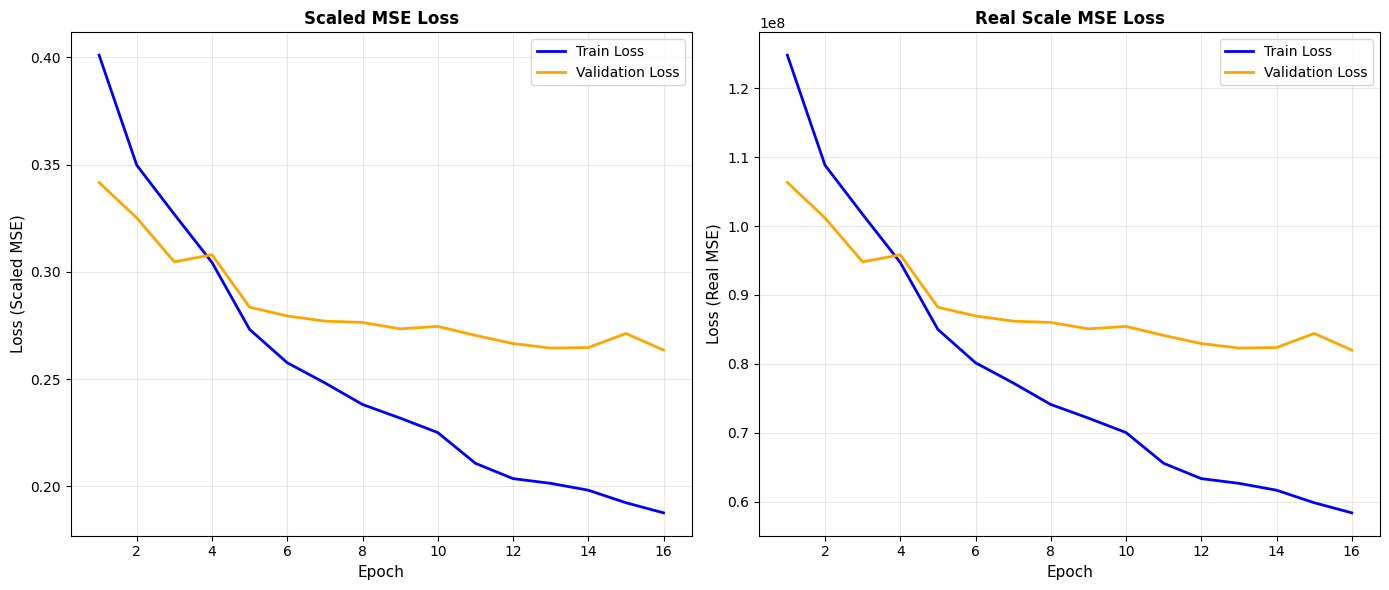

In [42]:
preprocessing_results = preprocess_salary_data_with_tfidf(
    X_train, X_valid, X_test,
    y_train, y_valid, y_test,
    categorical_columns=['Category', 'ContractType', 'ContractTime'],
    high_cardinality_columns=['Company', 'LocationNormalized', 'SourceName'],
    title_max_features=50,
    desc_max_features=800,
    batch_size=64,
    num_workers=0,
    desc_stop_words='english', # using stop words
    title_stop_words='english', # using stop words
    categorical_na_strategy='most_frequent',  
    high_card_na_strategy='most_frequent',    
    save_artifacts=False
)
train_loader = preprocessing_results['train_loader']
valid_loader = preprocessing_results['valid_loader']
test_loader = preprocessing_results['test_loader']

model = IntegratedNN(input_dim=preprocessing_results['feature_shape'][1]).to(device)
loss_fn = 'mse'
n_epochs = 25
optimizer_fn = 'adam'
patience = 3
lr = 0.001

trained_model, history, elapsed_time = train_single_input_model(
    model,
    train_loader,
    valid_loader,
    target_scaler=preprocessing_results['preprocessors']['target_scaler'],
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=0,
    scheduler_factor=0.5,
    seed=RANDOM_SEED
)

plot_losses_curves(history, loss_fn='mse')

**Validation loss improved to 0.261083- better than previous best result - removing stop words seems to help**

In [221]:
print_model_parameters_summary(model)

fc1.weight: 226,816 parameters, trainable=True
fc1.bias: 256 parameters, trainable=True
bn1.weight: 256 parameters, trainable=True
bn1.bias: 256 parameters, trainable=True
fc2.weight: 32,768 parameters, trainable=True
fc2.bias: 128 parameters, trainable=True
bn2.weight: 128 parameters, trainable=True
bn2.bias: 128 parameters, trainable=True
fc3.weight: 8,192 parameters, trainable=True
fc3.bias: 64 parameters, trainable=True
bn3.weight: 64 parameters, trainable=True
bn3.bias: 64 parameters, trainable=True
fc4.weight: 64 parameters, trainable=True
fc4.bias: 1 parameters, trainable=True
----------------------------------------
Total Parameters: 269,185


In [222]:
model_name = 'tfidf_stopwords_800_50_int_unk_bs64_adam_lrs_no_hid256_dr30'
torch.save(trained_model.state_dict(), MODELS_DIR + f'{model_name}.pth')
results = evaluate_single_input_model(
    model,
    test_loader,
    preprocessing_results['preprocessors']['target_scaler'],
    device,
    loss_fn_str='mse',  
    model_name=model_name,
    results_dict=fulldata_best_models
)

## Compare results of best models on the test set

In [223]:
fulldata_best_models

{'tfidf_800_50_sr_unk_bs64_adam_lrs_no_hid128_dr30': {'Test MSE (scaled)': 0.26948145748343877,
  'Test MSE (real)': np.float32(8.3866264e+07),
  'Test RMSE (real)': np.float32(9157.853)},
 'tfidf_800_50_srbn_unk_bs64_adam_lrs_no_hid128_dr30': {'Test MSE (scaled)': 0.27984383846803024,
  'Test MSE (real)': np.float32(8.7091176e+07),
  'Test RMSE (real)': np.float32(9332.266)},
 'emb_srbn_unk_bs64_adam_lrs_no_hid128_dr30': {'Test MSE (scaled)': 0.2752834456856843,
  'Test MSE (real)': np.float32(8.567189e+07),
  'Test RMSE (real)': np.float32(9255.911)},
 'emb_int_unk_bs64_adam_lrs_no_hid256_dr30': {'Test MSE (scaled)': 0.2579456583750902,
  'Test MSE (real)': np.float32(8.027616e+07),
  'Test RMSE (real)': np.float32(8959.696)},
 'emb_int_unk_bs64_adam_lrs_no_hid256_dr30_batchnorm_after': {'Test MSE (scaled)': 0.608699059860912,
  'Test MSE (real)': np.float32(1.8943528e+08),
  'Test RMSE (real)': np.float32(13763.549)},
 'emb_multi_unk_bs64_adam_lrs_no_hid256_dr30': {'Test MSE (scaled

In [224]:
def plot_top_models_comparison(
    results_dict: Dict = fulldata_best_models,
    top_n: int = 10,
    figsize: tuple = (16, 6),
):
    """
    Creates side-by-side bar plots comparing models by Test MSE (scaled) and Test RMSE (real).
    
    Args:
        results_dict: Dictionary with model names as keys and metrics as values
        top_n: Number of top models to display (default: 10)
        figsize: Figure size as (width, height) tuple
        save_path: Optional path to save the figure
    """
    # Extract data from results dictionary
    model_names = list(results_dict.keys())
    mse_scaled = [results_dict[name]['Test MSE (scaled)'] for name in model_names]
    rmse_real = [float(results_dict[name]['Test RMSE (real)']) for name in model_names]
    
    # Create dataframe-like structure for sorting
    data = list(zip(model_names, mse_scaled, rmse_real))
    
    # Sort by MSE (scaled) and get top N
    data_sorted_mse = sorted(data, key=lambda x: x[1])[:top_n]
    top_names_mse = [x[0] for x in data_sorted_mse]
    top_mse_scaled = [x[1] for x in data_sorted_mse]
    top_mse_real = [results_dict[x]['Test MSE (real)'] for x in top_names_mse]
    
    # Sort by RMSE (real) and get top N
    data_sorted_rmse = sorted(data, key=lambda x: x[2])[:top_n]
    top_names_rmse = [x[0] for x in data_sorted_rmse]
    top_rmse_real = [x[2] for x in data_sorted_rmse]
    
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Left plot: Top 10 by Test MSE (scaled)
    y_pos_1 = np.arange(len(top_names_mse))
    bars1 = ax1.barh(y_pos_1, top_mse_scaled, color='steelblue', alpha=0.8)
    ax1.set_yticks(y_pos_1)
    ax1.set_yticklabels(top_names_mse, fontsize=9)
    ax1.invert_yaxis()  # Best model at top
    ax1.set_xlabel('Test MSE (scaled)', fontsize=11, fontweight='bold')
    ax1.set_title(f'Top {top_n} Models by Test MSE (Scaled)', fontsize=13, fontweight='bold', pad=15)
    ax1.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars1, top_mse_scaled)):
        ax1.text(val, i, f' {val:.4f}', va='center', fontsize=8)
    
    # Right plot: Top 10 by Test RMSE (real)
    y_pos_2 = np.arange(len(top_names_rmse))
    bars2 = ax2.barh(y_pos_2, top_rmse_real, color='coral', alpha=0.8)
    ax2.set_yticks(y_pos_2)
    ax2.set_yticklabels(top_names_rmse, fontsize=9)
    ax2.invert_yaxis()  # Best model at top
    ax2.set_xlabel('Test RMSE (real)', fontsize=11, fontweight='bold')
    ax2.set_title(f'Top {top_n} Models by Test RMSE (Real Scale)', fontsize=13, fontweight='bold', pad=15)
    ax2.grid(axis='x', alpha=0.3, linestyle='--')
    
    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars2, top_rmse_real)):
        ax2.text(val, i, f' {val:.1f}', va='center', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\n{'='*70}")
    print(f"TOP {top_n} MODELS SUMMARY")
    print(f"{'='*70}")
    
    # Best model by scaled MSE
    best_mse_name = top_names_mse[0]
    best_mse_metrics = results_dict[best_mse_name]
    print(f"\nBest Model (by scaled MSE): {best_mse_name}")
    print(f"  All Metrics:")
    for metric_name, metric_value in best_mse_metrics.items():
        if isinstance(metric_value, (np.floating, np.integer)):
            metric_value = float(metric_value)
        if 'scaled' in metric_name.lower():
            print(f"    - {metric_name}: {metric_value:.6f}")
        else:
            print(f"    - {metric_name}: {metric_value:,.2f}")
    
    # Best model by real RMSE
    best_rmse_name = top_names_rmse[0]
    best_rmse_metrics = results_dict[best_rmse_name]
    print(f"\nBest Model (by real RMSE): {best_rmse_name}")
    print(f"  All Metrics:")
    for metric_name, metric_value in best_rmse_metrics.items():
        if isinstance(metric_value, (np.floating, np.integer)):
            metric_value = float(metric_value)
        if 'scaled' in metric_name.lower():
            print(f"    - {metric_name}: {metric_value:.6f}")
        else:
            print(f"    - {metric_name}: {metric_value:,.2f}")
    
    print(f"{'='*70}\n")

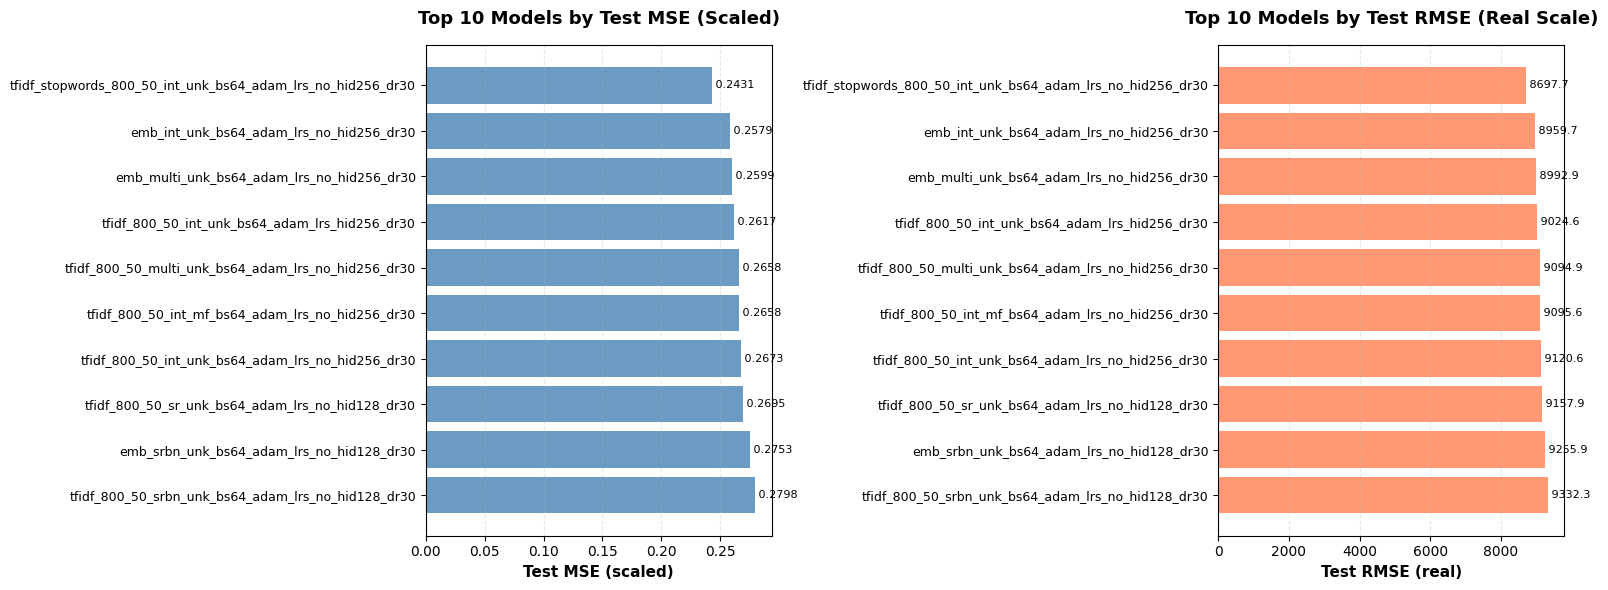


TOP 10 MODELS SUMMARY

Best Model (by scaled MSE): tfidf_stopwords_800_50_int_unk_bs64_adam_lrs_no_hid256_dr30
  All Metrics:
    - Test MSE (scaled): 0.243079
    - Test MSE (real): 75,649,424.00
    - Test RMSE (real): 8,697.67

Best Model (by real RMSE): tfidf_stopwords_800_50_int_unk_bs64_adam_lrs_no_hid256_dr30
  All Metrics:
    - Test MSE (scaled): 0.243079
    - Test MSE (real): 75,649,424.00
    - Test RMSE (real): 8,697.67



In [225]:
plot_top_models_comparison()

## Conclusions

- Best score achieved by fine-tuned tf-idf single input model with stop words removed, learning rate scheduler and filling missing values with most frequent value
- On 2 and 3  place are models with pretrained embeddings - if we use better embeddings and experiment we will probably be able to improve results and beat tf-idf approach, however time of generating embeddings is much longer than tf-idf vectorization

## New approach - trying to predict log of salary instead of standardized salary

I updated functions to include option to log-transform the target variable and perform propere transformations when evaluating the model.

In [43]:
LOG = True
log_models_dict = {}

In [47]:
X_train, X_valid, X_test, y_train, y_valid, y_test = load_and_split_data(log=LOG)

Train set has 195814 entries
Validation set has 24477 entries
Test set has 24477 entries


/var/folders/t5/ct5bhs3j6k18hj1qyrkwmvj00000gp/T/ipykernel_5789/1698176672.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.loc[X['Title'].isnull(), 'Title'] = 'Quality Improvement Manager'


Log mode: Target is already log-transformed, skipping StandardScaler
Log mode: Skipping artifact saving
Final feature shape: (195814, 886)
Categorical NA strategy: most_frequent
High cardinality NA strategy: most_frequent
Title: max_features=50, use_svd=False
Description: max_features=800, use_svd=False
Multi-input mode: False
Log mode: True
Epoch 1/40:
  Train - MSE: 5.1850, Real MSE: 4424422400.00, Real RMSE: 66516.33
  Valid - MSE: 0.1380, Real MSE: 225573472.00, Real RMSE: 15019.10
  Learning Rate: 0.001000
Validation loss improved to 0.137975.
Epoch 2/40:
  Train - MSE: 0.7474, Real MSE: 1997395328.00, Real RMSE: 44692.23
  Valid - MSE: 0.1364, Real MSE: 174426944.00, Real RMSE: 13207.08
  Learning Rate: 0.001000
Validation loss improved to 0.136423.
Epoch 3/40:
  Train - MSE: 0.5956, Real MSE: 1368314368.00, Real RMSE: 36990.73
  Valid - MSE: 0.1421, Real MSE: 230966464.00, Real RMSE: 15197.58
  Learning Rate: 0.001000
No improvement in validation loss for 1 epoch.
Epoch 4/40:
  

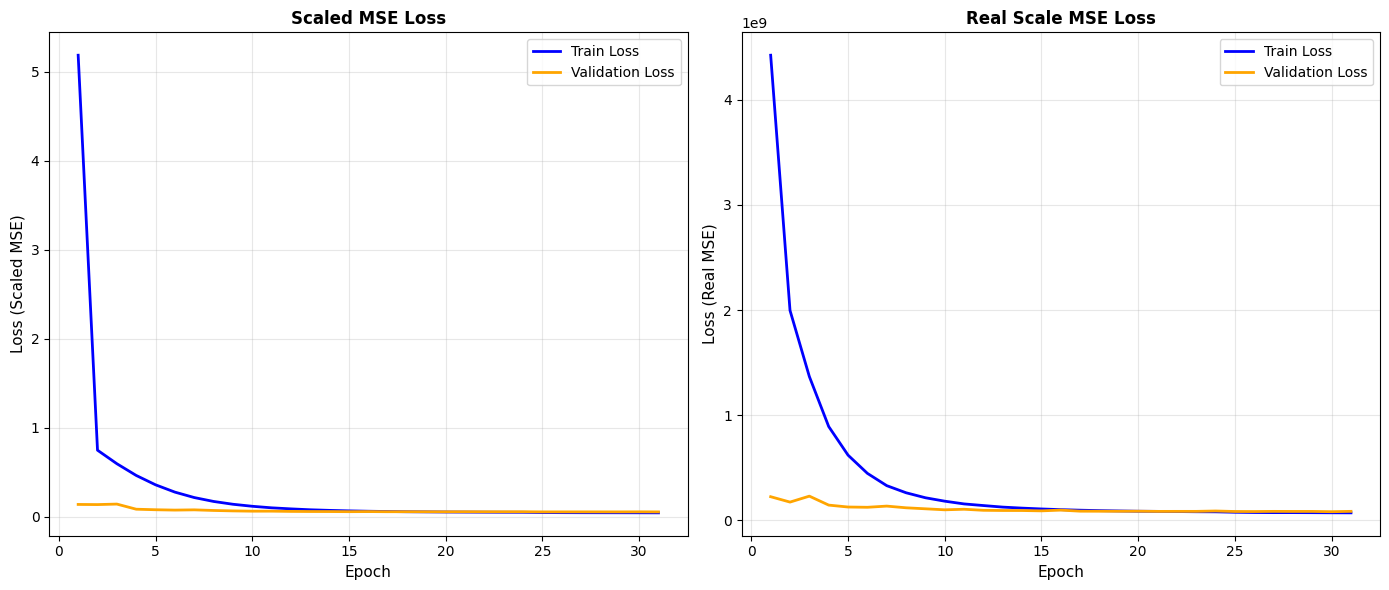

In [48]:
preprocessing_results = preprocess_salary_data_with_tfidf(
    X_train, X_valid, X_test,
    y_train, y_valid, y_test,
    categorical_columns=['Category', 'ContractType', 'ContractTime'],
    high_cardinality_columns=['Company', 'LocationNormalized', 'SourceName'],
    title_max_features=50,
    desc_max_features=800,
    batch_size=64,
    num_workers=0,
    desc_stop_words='english', # using stop words
    title_stop_words='english', # using stop words
    categorical_na_strategy='most_frequent',  
    high_card_na_strategy='most_frequent',    
    log=LOG,
)
train_loader = preprocessing_results['train_loader']
valid_loader = preprocessing_results['valid_loader']
test_loader = preprocessing_results['test_loader']

model = IntegratedNN(input_dim=preprocessing_results['feature_shape'][1]).to(device)
loss_fn = 'mse'
n_epochs = 40
optimizer_fn = 'adam'
patience = 6
lr = 0.001

trained_model, history, elapsed_time = train_single_input_model(
    model,
    train_loader,
    valid_loader,
    device=device,
    n_epochs=n_epochs,
    lr=lr,
    loss_fn=loss_fn,
    optimizer_fn=optimizer_fn,
    patience=patience,
    delta=0.001,
    early_stopping=None,
    use_lr_scheduler=True,
    scheduler_patience=3,
    scheduler_factor=0.5,
    seed=RANDOM_SEED,
    log=LOG
)

plot_losses_curves(history, loss_fn='mse')

In [ ]:
evaluate_single_input_model(
    model,
    test_loader,
    target_scaler=None,
    device=device,
    loss_fn_str='mse',
    model_name='tfidf_800_50_int_mf_bs64_adam_lrs_no_hid256_dr30_log',
    results_dict=log_models_dict,
    log=LOG
)

{'Test MSE (scaled)': 0.05222582359509347,
 'Test MSE (real)': np.float32(8.059359e+07),
 'Test RMSE (real)': np.float32(8977.394)}